<h1> Esp. em Ciência de Dados UTFPR/DV - Projeto Integrador M2 </h1>

_Data science specialization, second (of 6) module project_

 This work aims to identify the ability of transition of a ficticious freight company from fuel powered trucks to electric trucks, based on a small amount of data provided by Volvo Group.
 
 Este trabalho visa identificar a possibilidade de transição de uma frota fictícia de caminhões, movidos a diesel, por veículos elétricos.
 
Therefore, we need to answer some questions
 
 - What would be the best places to recharge the batteries?
 - What's the current Diesel consumption? What is the recommended autonomy? 
 - What would be the environmental impact?
 - Considering only the fuel, would this transition be financially interesting?
 
 
_Autor: Clayton R. Lambert_

In [1]:
#imports
import psycopg2
from haversine import haversine
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#options
#pd.options.display.max_rows = 999 

In [2]:
#OPERAÇÕES NO BANCO DE DADOS / DATABASE OPS
#conectando / connecting...

connection = psycopg2.connect("dbname=pi2 user=lmbrt password=Göteborg1927")
crsr = connection.cursor()

In [3]:
# !SINGLE EXECUTION! criando banco de dados / creating database (foi necessário recriar a base no ambiente do Anaconda)
#crsr.execute("CREATE TABLE trucks ( vehicle_id varchar(11) NOT NULL, vehicle_name varchar(21), CONSTRAINT trucks_pk PRIMARY KEY (vehicle_id))")
#crsr.execute("ALTER TABLE trucks ADD COLUMN vehicle_type varchar(10), ADD COLUMN charge_time numeric, ADD COLUMN vehicle_range numeric;")
#crsr.execute("CREATE TABLE travel_logbook (log_id serial,vehicle_id varchar(11),timestamp_t timestamp,latitude numeric,longitude numeric,heading integer,odometer_km numeric,acc_fuel_use_lt numeric,CONSTRAINT travel_log_pk PRIMARY KEY (log_id),CONSTRAINT vehicle_id_fk FOREIGN KEY (vehicle_id) REFERENCES trucks (vehicle_id) ON UPDATE CASCADE ON DELETE NO ACTION)")

In [4]:
#verificando criação das tabelas / verifying tables
crsr.execute("select * from information_schema.tables")
for l in crsr:
    if l[1]=='public':
        print(l[0:3])

('pi2', 'public', 'travel_logbook')
('pi2', 'public', 'trucks')


In [5]:
# !SINGLE EXECUTION! realizando inserção nas tabelas / inserting values - 5 values
#crsr.execute("insert into trucks values ('3gJrn9_s02','ficticious_truck_1'), ('8lDkx0_s02','ficticious_truck_2');")
#crsr.execute("commit;")
#crsr.execute("insert into trucks values ('3gJrn9_s02','ficticious_truck_1'), ('8lDkx0_s02','ficticious_truck_2');")
#crsr.execute("insert into trucks values ('FH_FM_FMX','FH-FM-FMX Electric','ELECTRIC', 2.5, 300), ('FE','FE Electric','ELECTRIC', 2.5, 200), ('FL','FL Electric','ELECTRIC', 2.5, 300);")
#crsr.execute("commit;")

In [6]:
# !SINGLE EXECUTION! 1436  values
#crsr.execute("insert into travel_logbook values (2,'3gJrn9_s02',' 2021-03-24 08:59:17 ',  57.721864   ,   11.96814    ,   0   ,   53201.1 ,   16707.12    ),(3,'3gJrn9_s02',' 2021-03-24 09:01:01 ',  57.720246   ,   11.96201    ,   245 ,   53201.6 ,   16707.28    ),(4,'8lDkx0_s02',' 2021-03-24 09:01:07 ', 57.721864 , 11.96814 , 0 , 43594.5 , 13872.48 ),(5,'3gJrn9_s02',' 2021-03-24 09:02:35 ', 57.721492 , 11.957442 , 33 , 53201.9 , 16707.43 ),(6,'3gJrn9_s02',' 2021-03-24 09:03:55 ', 57.725319 , 11.965144 , 67 , 53202.6 , 16707.66 ),(7,'8lDkx0_s02',' 2021-03-24 09:04:38 ', 57.723468 , 11.983403 , 87 , 43595.6 , 13872.86 ),(8,'3gJrn9_s02',' 2021-03-24 09:05:12 ', 57.725569 , 11.980408 , 100 , 53203.5 , 16707.97 ),(9,'8lDkx0_s02',' 2021-03-24 09:06:16 ', 57.72737 , 11.988461 , 28 , 43596.1 , 13873.07 ),(10,'3gJrn9_s02',' 2021-03-24 09:06:43 ', 57.718835 , 11.991287 , 148 , 53204.5 , 16708.31 ),(11,'8lDkx0_s02',' 2021-03-24 09:06:57 ', 57.729939 , 11.989967 , 352 , 43596.4 , 13873.17 ),(12,'3gJrn9_s02',' 2021-03-24 09:07:51 ', 57.711924 , 11.996281 , 134 , 53205.4 , 16708.59 ),(13,'8lDkx0_s02',' 2021-03-24 09:08:11 ', 57.731236 , 11.986594 , 344 , 43596.7 , 13873.28 ),(14,'3gJrn9_s02',' 2021-03-24 09:10:15 ', 57.695687 , 11.996517 , 167 , 53207.2 , 16709.2 ),(15,'3gJrn9_s02',' 2021-03-24 09:11:24 ', 57.688829 , 12.002083 , 108 , 53208.1 , 16709.49 ),(16,'8lDkx0_s02',' 2021-03-24 09:11:30 ', 57.748454 , 11.990572 , 10 , 43598.9 , 13874.02 ),(17,'3gJrn9_s02',' 2021-03-24 09:12:40 ', 57.683465 , 12.015358 , 137 , 53209.1 , 16709.84 ),(18,'3gJrn9_s02',' 2021-03-24 09:14:10 ', 57.67571 , 12.031198 , 96 , 53210.4 , 16710.25 ),(19,'3gJrn9_s02',' 2021-03-24 09:15:49 ', 57.675505 , 12.05233 , 96 , 53211.8 , 16710.74 ),(20,'8lDkx0_s02',' 2021-03-24 09:15:49 ', 57.782153 , 11.999428 , 6 , 43602.6 , 13875.22 ),(21,'3gJrn9_s02',' 2021-03-24 09:17:48 ', 57.672871 , 12.086033 , 100 , 53213.8 , 16711.33 ),(22,'8lDkx0_s02',' 2021-03-24 09:18:29 ', 57.801982 , 12.007864 , 2 , 43604.9 , 13875.97 ),(23,'3gJrn9_s02',' 2021-03-24 09:19:53 ', 57.671788 , 12.117632 , 73 , 53215.8 , 16711.98 ),(24,'8lDkx0_s02',' 2021-03-24 09:22:11 ', 57.832971 , 12.005345 , 5 , 43608.4 , 13877.05 ),(25,'3gJrn9_s02',' 2021-03-24 09:22:43 ', 57.680604 , 12.164225 , 65 , 53218.7 , 16712.87 ),(26,'8lDkx0_s02',' 2021-03-24 09:23:52 ', 57.846681 , 12.003371 , 343 , 43609.9 , 13877.55 ),(27,'3gJrn9_s02',' 2021-03-24 09:24:42 ', 57.686787 , 12.196466 , 94 , 53220.7 , 16713.45 ),(28,'8lDkx0_s02',' 2021-03-24 09:26:26 ', 57.861526 , 11.97907 , 303 , 43612.2 , 13878.26 ),(29,'3gJrn9_s02',' 2021-03-24 09:27:36 ', 57.683979 , 12.238386 , 100 , 53223.3 , 16714.3 ),(30,'8lDkx0_s02',' 2021-03-24 09:28:57 ', 57.875029 , 11.964143 , 325 , 43613.9 , 13878.85 ),(31,'3gJrn9_s02',' 2021-03-24 09:29:22 ', 57.685037 , 12.267013 , 70 , 53225.0 , 16714.82 ),(32,'8lDkx0_s02',' 2021-03-24 09:31:28 ', 57.891107 , 11.936629 , 320 , 43616.5 , 13879.66 ),(33,'3gJrn9_s02',' 2021-03-24 09:32:05 ', 57.681946 , 12.308679 , 122 , 53227.6 , 16715.64 ),(34,'3gJrn9_s02',' 2021-03-24 09:34:12 ', 57.67642 , 12.343736 , 108 , 53229.8 , 16716.32 ),(35,'8lDkx0_s02',' 2021-03-24 09:34:29 ', 57.912468 , 11.892346 , 318 , 43620.0 , 13880.69 ),(36,'3gJrn9_s02',' 2021-03-24 09:37:36 ', 57.661725 , 12.552758 , 108 , 53233.6 , 16717.45 ),(37,'8lDkx0_s02',' 2021-03-24 09:38:07 ', 58.019497 , 11.844266 , 6 , 43624.1 , 13881.92 ),(38,'8lDkx0_s02',' 2021-03-24 09:39:17 ', 58.025866 , 11.849932 , 167 , 43625.0 , 13882.18 ),(39,'3gJrn9_s02',' 2021-03-24 09:39:17 ', 57.664104 , 12.582812 , 68 , 53235.4 , 16718.01 ),(40,'8lDkx0_s02',' 2021-03-24 09:40:28 ', 58.025153 , 11.841787 , 254 , 43625.6 , 13882.36 ),(41,'3gJrn9_s02',' 2021-03-24 09:41:10 ', 57.669535 , 12.615248 , 65 , 53237.5 , 16718.62 ),(42,'3gJrn9_s02',' 2021-03-24 09:43:06 ', 57.670097 , 12.651403 , 86 , 53239.7 , 16719.28 ),(43,'8lDkx0_s02',' 2021-03-24 09:43:37 ', 58.037262 , 11.821836 , 336 , 43627.5 , 13883.04 ),(44,'8lDkx0_s02',' 2021-03-24 09:45:11 ', 58.046725 , 11.815576 , 353 , 43628.6 , 13883.4 ),(45,'3gJrn9_s02',' 2021-03-24 09:45:32 ', 57.676994 , 12.695612 , 71 , 53242.4 , 16720.11 ),(46,'8lDkx0_s02',' 2021-03-24 09:46:47 ', 58.055781 , 11.822074 , 6 , 43629.7 , 13883.77 ),(47,'3gJrn9_s02',' 2021-03-24 09:47:59 ', 57.681851 , 12.739009 , 75 , 53245.2 , 16720.94 ),(48,'8lDkx0_s02',' 2021-03-24 09:48:28 ', 58.061011 , 11.819179 , 329 , 43630.3 , 13884.01 ),(49,'8lDkx0_s02',' 2021-03-24 09:50:17 ', 58.063299 , 11.815659 , 283 , 43630.7 , 13884.14 ),(50,'3gJrn9_s02',' 2021-03-24 09:50:23 ', 57.686241 , 12.784479 , 66 , 53247.9 , 16721.73 ),(51,'8lDkx0_s02',' 2021-03-24 09:51:51 ', 58.061503 , 11.818756 , 157 , 43631.1 , 13884.3 ),(52,'8lDkx0_s02',' 2021-03-24 09:52:45 ', 58.060587 , 11.817821 , 124 , 43631.4 , 13884.42 ),(53,'3gJrn9_s02',' 2021-03-24 09:53:19 ', 57.698994 , 12.825514 , 55 , 53250.7 , 16722.62 ),(54,'8lDkx0_s02',' 2021-03-24 09:53:53 ', 58.05501 , 11.821797 , 195 , 43632.1 , 13884.67 ),(55,'8lDkx0_s02',' 2021-03-24 09:55:32 ', 58.045483 , 11.816073 , 161 , 43633.3 , 13885.05 ),(56,'3gJrn9_s02',' 2021-03-24 09:55:37 ', 57.710873 , 12.859207 , 85 , 53253.2 , 16723.39 ),(57,'3gJrn9_s02',' 2021-03-24 09:57:54 ', 57.713615 , 12.899044 , 82 , 53255.5 , 16724.08 ),(58,'8lDkx0_s02',' 2021-03-24 09:58:09 ', 58.031583 , 11.8291 , 145 , 43635.1 , 13885.66 ),(59,'3gJrn9_s02',' 2021-03-24 09:59:45 ', 57.717881 , 12.925247 , 75 , 53257.1 , 16724.59 ),(60,'8lDkx0_s02',' 2021-03-24 09:59:49 ', 58.024815 , 11.841776 , 130 , 43636.1 , 13886.01 ),(61,'3gJrn9_s02',' 2021-03-24 10:01:08 ', 57.715633 , 12.941285 , 104 , 53258.1 , 16724.92 ),(62,'8lDkx0_s02',' 2021-03-24 10:01:16 ', 58.016756 , 11.843547 , 185 , 43637.2 , 13886.37 ),(63,'3gJrn9_s02',' 2021-03-24 10:02:50 ', 57.717268 , 12.962121 , 68 , 53259.4 , 16725.35 ),(64,'8lDkx0_s02',' 2021-03-24 10:03:04 ', 57.997449 , 11.842969 , 190 , 43639.3 , 13886.98 ),(65,'3gJrn9_s02',' 2021-03-24 10:04:43 ', 57.724668 , 12.981952 , 77 , 53260.8 , 16725.83 ),(66,'8lDkx0_s02',' 2021-03-24 10:04:43 ', 57.980883 , 11.841135 , 186 , 43641.1 , 13887.54 ),(67,'3gJrn9_s02',' 2021-03-24 10:06:27 ', 57.726661 , 13.00392 , 72 , 53262.2 , 16726.28 ),(68,'8lDkx0_s02',' 2021-03-24 10:06:35 ', 57.96542 , 11.842229 , 162 , 43643.0 , 13888.11 ),(69,'3gJrn9_s02',' 2021-03-24 10:08:38 ', 57.732778 , 13.035076 , 48 , 53264.3 , 16726.95 ),(70,'8lDkx0_s02',' 2021-03-24 10:09:01 ', 57.945347 , 11.856038 , 151 , 43645.3 , 13888.85 ),(71,'3gJrn9_s02',' 2021-03-24 10:11:12 ', 57.748093 , 13.069943 , 38 , 53267.1 , 16727.79 ),(72,'8lDkx0_s02',' 2021-03-24 10:11:29 ', 57.924831 , 11.877621 , 158 , 43648.0 , 13889.67 ),(73,'3gJrn9_s02',' 2021-03-24 10:13:23 ', 57.759916 , 13.105687 , 44 , 53269.5 , 16728.51 ),(74,'8lDkx0_s02',' 2021-03-24 10:14:33 ', 57.90214 , 11.915435 , 128 , 43651.5 , 13890.71 ),(75,'3gJrn9_s02',' 2021-03-24 10:15:37 ', 57.780436 , 13.119223 , 22 , 53272.0 , 16729.26 ),(76,'8lDkx0_s02',' 2021-03-24 10:17:53 ', 57.877868 , 11.958892 , 130 , 43655.1 , 13891.77 ),(77,'3gJrn9_s02',' 2021-03-24 10:18:05 ', 57.79732 , 13.15184 , 61 , 53274.8 , 16730.09 ),(78,'8lDkx0_s02',' 2021-03-24 10:19:02 ', 57.874186 , 11.964076 , 188 , 43655.6 , 13891.94 ),(79,'8lDkx0_s02',' 2021-03-24 10:19:21 ', 57.87394 , 11.962507 , 298 , 43655.7 , 13891.98 ),(80,'8lDkx0_s02',' 2021-03-24 10:20:09 ', 57.875085 , 11.962954 , 87 , 43656.0 , 13892.1 ),(81,'3gJrn9_s02',' 2021-03-24 10:20:38 ', 57.809108 , 13.195504 , 94 , 53277.7 , 16730.95 ),(82,'8lDkx0_s02',' 2021-03-24 10:21:39 ', 57.876359 , 11.973478 , 124 , 43656.6 , 13892.31 ),(83,'3gJrn9_s02',' 2021-03-24 10:23:09 ', 57.80967 , 13.239746 , 71 , 53280.4 , 16731.79 ),(84,'8lDkx0_s02',' 2021-03-24 10:24:20 ', 57.871571 , 11.980134 , 144 , 43657.2 , 13892.56 ),(85,'3gJrn9_s02',' 2021-03-24 10:24:58 ', 57.817973 , 13.272429 , 58 , 53282.6 , 16732.4 ),(86,'8lDkx0_s02',' 2021-03-24 10:25:46 ', 57.868461 , 11.98324 , 144 , 43657.6 , 13892.71 ),(87,'3gJrn9_s02',' 2021-03-24 10:26:24 ', 57.81894 , 13.298187 , 76 , 53284.1 , 16732.88 ),(88,'8lDkx0_s02',' 2021-03-24 10:27:47 ', 57.865116 , 11.992885 , 132 , 43658.3 , 13892.98 ),(89,'3gJrn9_s02',' 2021-03-24 10:28:55 ', 57.81815 , 13.342001 , 111 , 53286.9 , 16733.72 ),(90,'8lDkx0_s02',' 2021-03-24 10:29:24 ', 57.861684 , 11.996673 , 161 , 43658.8 , 13893.16 ),(91,'8lDkx0_s02',' 2021-03-24 10:30:59 ', 57.857644 , 11.998894 , 186 , 43659.3 , 13893.33 ),(92,'3gJrn9_s02',' 2021-03-24 10:31:12 ', 57.810634 , 13.38442 , 88 , 53289.4 , 16734.48 ),(93,'8lDkx0_s02',' 2021-03-24 10:32:27 ', 57.853725 , 12.001533 , 170 , 43659.8 , 13893.54 ),(94,'3gJrn9_s02',' 2021-03-24 10:33:18 ', 57.809683 , 13.417935 , 111 , 53291.5 , 16735.11 ),(95,'8lDkx0_s02',' 2021-03-24 10:33:43 ', 57.845489 , 12.003789 , 164 , 43660.8 , 13893.84 ),(96,'3gJrn9_s02',' 2021-03-24 10:34:53 ', 57.81077 , 13.442367 , 93 , 53293.0 , 16735.59 ),(97,'8lDkx0_s02',' 2021-03-24 10:35:10 ', 57.834367 , 12.005382 , 185 , 43662.1 , 13894.27 ),(98,'3gJrn9_s02',' 2021-03-24 10:37:29 ', 57.803174 , 13.479397 , 98 , 53295.5 , 16736.38 ),(99,'8lDkx0_s02',' 2021-03-24 10:38:47 ', 57.804258 , 12.007511 , 173 , 43665.4 , 13895.34 ),(100,'3gJrn9_s02',' 2021-03-24 10:41:15 ', 57.796447 , 13.540747 , 108 , 53299.2 , 16737.51 ),(101,'8lDkx0_s02',' 2021-03-24 10:42:10 ', 57.782813 , 11.999344 , 185 , 43668.3 , 13896.28 ),(102,'3gJrn9_s02',' 2021-03-24 10:44:38 ', 57.796918 , 13.592782 , 89 , 53302.3 , 16738.51 ),(103,'8lDkx0_s02',' 2021-03-24 10:46:12 ', 57.749452 , 11.990768 , 188 , 43671.7 , 13897.4 ),(104,'8lDkx0_s02',' 2021-03-24 10:48:41 ', 57.728629 , 11.982798 , 164 , 43673.9 , 13898.06 ),(105,'3gJrn9_s02',' 2021-03-24 10:49:12 ', 57.78217 , 13.651938 , 125 , 53306.4 , 16739.84 ),(106,'8lDkx0_s02',' 2021-03-24 10:49:23 ', 57.728428 , 11.988688 , 94 , 43674.4 , 13898.21 ),(107,'8lDkx0_s02',' 2021-03-24 10:50:21 ', 57.725127 , 11.999006 , 97 , 43675.1 , 13898.45 ),(108,'8lDkx0_s02',' 2021-03-24 10:51:40 ', 57.723993 , 12.012883 , 69 , 43676.0 , 13898.78 ),(109,'8lDkx0_s02',' 2021-03-24 10:54:18 ', 57.728802 , 12.046716 , 67 , 43678.2 , 13899.48 ),(110,'3gJrn9_s02',' 2021-03-24 10:54:28 ', 57.764826 , 13.728236 , 117 , 53311.3 , 16741.35 ),(111,'8lDkx0_s02',' 2021-03-24 10:57:40 ', 57.73586 , 12.094429 , 70 , 43681.1 , 13900.42 ),(112,'3gJrn9_s02',' 2021-03-24 10:59:04 ', 57.769248 , 13.799129 , 84 , 53315.5 , 16742.7 ),(113,'8lDkx0_s02',' 2021-03-24 11:00:19 ', 57.739945 , 12.129953 , 83 , 43683.3 , 13901.15 ),(114,'3gJrn9_s02',' 2021-03-24 11:01:50 ', 57.76082 , 13.835386 , 133 , 53318.0 , 16743.49 ),(115,'8lDkx0_s02',' 2021-03-24 11:02:39 ', 57.742861 , 12.16503 , 121 , 43685.5 , 13901.82 ),(116,'8lDkx0_s02',' 2021-03-24 11:05:13 ', 57.741723 , 12.205871 , 96 , 43688.0 , 13902.61 ),(117,'3gJrn9_s02',' 2021-03-24 11:05:22 ', 57.754568 , 13.891469 , 85 , 53321.4 , 16744.55 ),(118,'3gJrn9_s02',' 2021-03-24 11:07:44 ', 57.754636 , 13.927306 , 89 , 53323.6 , 16745.24 ),(119,'3gJrn9_s02',' 2021-03-24 11:10:27 ', 57.751098 , 13.963728 , 92 , 53325.8 , 16745.98 ),(120,'3gJrn9_s02',' 2021-03-24 11:13:23 ', 57.759858 , 14.004834 , 52 , 53328.5 , 16746.83 ),(121,'3gJrn9_s02',' 2021-03-24 11:16:27 ', 57.772701 , 14.047592 , 62 , 53331.4 , 16747.72 ),(122,'3gJrn9_s02',' 2021-03-24 11:18:14 ', 57.773441 , 14.076472 , 109 , 53333.2 , 16748.29 ),(123,'3gJrn9_s02',' 2021-03-24 11:20:04 ', 57.763805 , 14.100542 , 139 , 53334.9 , 16748.82 ),(124,'3gJrn9_s02',' 2021-03-24 11:21:03 ', 57.764284 , 14.100445 , 27 , 53335.3 , 16748.95 ),(125,'3gJrn9_s02',' 2021-03-24 11:22:06 ', 57.768904 , 14.10445 , 16 , 53335.9 , 16749.17 ),(126,'3gJrn9_s02',' 2021-03-24 11:23:34 ', 57.771516 , 14.111525 , 80 , 53336.5 , 16749.37 ),(127,'3gJrn9_s02',' 2021-03-24 11:25:34 ', 57.773873 , 14.125732 , 42 , 53337.4 , 16749.69 ),(128,'3gJrn9_s02',' 2021-03-24 11:26:59 ', 57.772617 , 14.130381 , 119 , 53337.9 , 16749.87 ),(129,'3gJrn9_s02',' 2021-03-24 11:28:55 ', 57.771615 , 14.138377 , 28 , 53338.5 , 16750.11 ),(130,'3gJrn9_s02',' 2021-03-24 11:30:59 ', 57.77738 , 14.145903 , 70 , 53339.3 , 16750.4 ),(131,'3gJrn9_s02',' 2021-03-24 11:34:49 ', 57.777992 , 14.159804 , 129 , 53340.3 , 16750.77 ),(132,'8lDkx0_s02',' 2021-03-24 12:06:11 ', 57.74951 , 12.238144 , 58 , 43690.2 , 13903.28 ),(133,'8lDkx0_s02',' 2021-03-24 12:07:23 ', 57.752648 , 12.248639 , 48 , 43690.8 , 13903.48 ),(134,'8lDkx0_s02',' 2021-03-24 12:09:45 ', 57.760381 , 12.257255 , 34 , 43691.9 , 13903.87 ),(135,'8lDkx0_s02',' 2021-03-24 12:11:52 ', 57.765287 , 12.262552 , 41 , 43692.6 , 13904.13 ),(136,'8lDkx0_s02',' 2021-03-24 12:14:40 ', 57.768744 , 12.268789 , 236 , 43693.4 , 13904.45 ),(137,'8lDkx0_s02',' 2021-03-24 12:15:29 ', 57.766552 , 12.267054 , 98 , 43693.7 , 13904.55 ),(138,'8lDkx0_s02',' 2021-03-24 12:17:25 ', 57.769498 , 12.274763 , 56 , 43694.4 , 13904.8 ),(139,'8lDkx0_s02',' 2021-03-24 12:19:24 ', 57.772984 , 12.292006 , 79 , 43695.4 , 13905.16 ),(140,'8lDkx0_s02',' 2021-03-24 12:21:04 ', 57.777052 , 12.299881 , 51 , 43696.2 , 13905.45 ),(141,'8lDkx0_s02',' 2021-03-24 12:23:50 ', 57.792123 , 12.340286 , 64 , 43699.2 , 13906.33 ),(142,'8lDkx0_s02',' 2021-03-24 12:26:47 ', 57.807059 , 12.380729 , 56 , 43702.1 , 13907.26 ),(143,'8lDkx0_s02',' 2021-03-24 12:29:47 ', 57.815868 , 12.415273 , 21 , 43704.5 , 13908.01 ),(144,'8lDkx0_s02',' 2021-03-24 12:32:30 ', 57.828699 , 12.42967 , 28 , 43706.1 , 13908.59 ),(145,'8lDkx0_s02',' 2021-03-24 12:35:15 ', 57.839335 , 12.448757 , 61 , 43707.8 , 13909.16 ),(146,'8lDkx0_s02',' 2021-03-24 12:39:18 ', 57.855659 , 12.476231 , 25 , 43710.8 , 13910.19 ),(147,'8lDkx0_s02',' 2021-03-24 12:41:29 ', 57.879207 , 12.493027 , 1 , 43713.2 , 13910.88 ),(148,'8lDkx0_s02',' 2021-03-24 12:42:21 ', 57.886479 , 12.489231 , 352 , 43714.1 , 13911.15 ),(149,'8lDkx0_s02',' 2021-03-24 12:43:37 ', 57.897915 , 12.490697 , 30 , 43715.4 , 13911.55 ),(150,'8lDkx0_s02',' 2021-03-24 12:45:18 ', 57.909661 , 12.506233 , 48 , 43717.0 , 13912.06 ),(151,'8lDkx0_s02',' 2021-03-24 12:48:13 ', 57.923988 , 12.530105 , 67 , 43719.1 , 13912.75 ),(152,'8lDkx0_s02',' 2021-03-24 13:44:00 ', 57.926758 , 12.545548 , 74 , 43720.1 , 13913.09 ),(153,'8lDkx0_s02',' 2021-03-24 13:47:01 ', 57.933196 , 12.571049 , 52 , 43721.8 , 13913.7 ),(154,'8lDkx0_s02',' 2021-03-24 13:48:06 ', 57.938653 , 12.584361 , 45 , 43722.8 , 13914.02 ),(155,'8lDkx0_s02',' 2021-03-24 13:49:23 ', 57.945229 , 12.601069 , 58 , 43724.1 , 13914.41 ),(156,'3gJrn9_s02',' 2021-03-24 13:50:11 ', 57.771004 , 14.15542 , 204 , 53341.2 , 16751.09 ),(157,'8lDkx0_s02',' 2021-03-24 13:51:16 ', 57.950497 , 12.632159 , 61 , 43726.1 , 13915.02 ),(158,'3gJrn9_s02',' 2021-03-24 13:52:15 ', 57.764515 , 14.153155 , 187 , 53341.9 , 16751.36 ),(159,'3gJrn9_s02',' 2021-03-24 13:53:14 ', 57.76243 , 14.153155 , 141 , 53342.2 , 16751.47 ),(160,'8lDkx0_s02',' 2021-03-24 13:53:27 ', 57.964443 , 12.66149 , 76 , 43728.5 , 13915.76 ),(161,'3gJrn9_s02',' 2021-03-24 13:55:09 ', 57.75868 , 14.15133 , 271 , 53342.9 , 16751.75 ),(162,'8lDkx0_s02',' 2021-03-24 13:56:26 ', 57.978016 , 12.710764 , 41 , 43731.9 , 13916.78 ),(163,'3gJrn9_s02',' 2021-03-24 13:56:32 ', 57.756052 , 14.135399 , 202 , 53344.1 , 16752.14 ),(164,'3gJrn9_s02',' 2021-03-24 13:57:28 ', 57.749604 , 14.125114 , 262 , 53345.0 , 16752.4 ),(165,'3gJrn9_s02',' 2021-03-24 13:58:50 ', 57.754629 , 14.108659 , 332 , 53346.2 , 16752.79 ),(166,'8lDkx0_s02',' 2021-03-24 13:58:59 ', 57.996941 , 12.744216 , 54 , 43734.8 , 13917.64 ),(167,'3gJrn9_s02',' 2021-03-24 14:00:14 ', 57.763984 , 14.100579 , 316 , 53347.4 , 16753.19 ),(168,'8lDkx0_s02',' 2021-03-24 14:01:07 ', 58.01253 , 12.767078 , 52 , 43737.0 , 13918.31 ),(169,'3gJrn9_s02',' 2021-03-24 14:02:03 ', 57.773239 , 14.077698 , 296 , 53349.1 , 16753.73 ),(170,'8lDkx0_s02',' 2021-03-24 14:02:42 ', 58.022507 , 12.782334 , 57 , 43738.4 , 13918.72 ),(171,'8lDkx0_s02',' 2021-03-24 14:03:27 ', 58.022595 , 12.786262 , 76 , 43738.7 , 13918.81 ),(172,'3gJrn9_s02',' 2021-03-24 14:03:44 ', 57.772851 , 14.047868 , 244 , 53350.9 , 16754.26 ),(173,'8lDkx0_s02',' 2021-03-24 14:04:57 ', 58.023242 , 12.799516 , 83 , 43739.5 , 13919.12 ),(174,'8lDkx0_s02',' 2021-03-24 14:06:43 ', 58.029861 , 12.803206 , 31 , 43740.3 , 13919.42 ),(175,'3gJrn9_s02',' 2021-03-24 14:06:51 ', 57.760949 , 14.007157 , 231 , 53353.8 , 16755.19 ),(176,'8lDkx0_s02',' 2021-03-24 14:08:41 ', 58.031696 , 12.809907 , 181 , 43741.0 , 13919.64 ),(177,'3gJrn9_s02',' 2021-03-24 14:09:32 ', 57.751119 , 13.971649 , 267 , 53356.2 , 16755.96 ),(178,'8lDkx0_s02',' 2021-03-24 14:10:02 ', 58.032482 , 12.804726 , 290 , 43741.4 , 13919.79 ),(179,'8lDkx0_s02',' 2021-03-24 14:12:08 ', 58.025088 , 12.799921 , 166 , 43742.3 , 13920.14 ),(180,'3gJrn9_s02',' 2021-03-24 14:12:15 ', 57.754697 , 13.934047 , 274 , 53358.4 , 16756.7 ),(181,'8lDkx0_s02',' 2021-03-24 14:13:48 ', 58.023194 , 12.79015 , 254 , 43743.2 , 13920.44 ),(182,'8lDkx0_s02',' 2021-03-24 14:14:35 ', 58.022834 , 12.78248 , 288 , 43743.6 , 13920.59 ),(183,'3gJrn9_s02',' 2021-03-24 14:14:51 ', 57.75472 , 13.893571 , 270 , 53360.8 , 16757.45 ),(184,'8lDkx0_s02',' 2021-03-24 14:15:52 ', 58.02278 , 12.781861 , 203 , 43744.0 , 13920.72 ),(185,'8lDkx0_s02',' 2021-03-24 14:18:24 ', 58.01055 , 12.76231 , 223 , 43745.9 , 13921.33 ),(186,'3gJrn9_s02',' 2021-03-24 14:18:36 ', 57.760891 , 13.83552 , 312 , 53364.5 , 16758.58 ),(187,'8lDkx0_s02',' 2021-03-24 14:20:35 ', 57.995414 , 12.739084 , 241 , 43748.1 , 13922.04 ),(188,'3gJrn9_s02',' 2021-03-24 14:21:10 ', 57.769359 , 13.799695 , 270 , 53366.8 , 16759.3 ),(189,'8lDkx0_s02',' 2021-03-24 14:23:30 ', 57.973456 , 12.701037 , 233 , 43751.5 , 13923.03 ),(190,'3gJrn9_s02',' 2021-03-24 14:25:32 ', 57.764067 , 13.733979 , 273 , 53370.8 , 16760.58 ),(191,'8lDkx0_s02',' 2021-03-24 14:26:09 ', 57.963049 , 12.653111 , 241 , 43754.5 , 13923.93 ),(192,'8lDkx0_s02',' 2021-03-24 14:28:07 ', 57.949229 , 12.625437 , 254 , 43756.8 , 13924.6 ),(193,'3gJrn9_s02',' 2021-03-24 14:29:32 ', 57.776344 , 13.675667 , 285 , 53374.5 , 16761.77 ),(194,'8lDkx0_s02',' 2021-03-24 14:29:33 ', 57.945038 , 12.599733 , 240 , 43758.4 , 13925.07 ),(195,'3gJrn9_s02',' 2021-03-24 14:34:14 ', 57.795282 , 13.616343 , 290 , 53378.8 , 16763.12 ),(196,'3gJrn9_s02',' 2021-03-24 14:38:05 ', 57.795542 , 13.553779 , 265 , 53382.4 , 16764.27 ),(197,'3gJrn9_s02',' 2021-03-24 14:41:03 ', 57.800613 , 13.512011 , 276 , 53385.0 , 16765.11 ),(198,'3gJrn9_s02',' 2021-03-24 14:44:21 ', 57.806478 , 13.45968 , 295 , 53388.2 , 16766.11 ),(199,'3gJrn9_s02',' 2021-03-24 14:46:10 ', 57.809545 , 13.429754 , 251 , 53390.1 , 16766.67 ),(200,'3gJrn9_s02',' 2021-03-24 14:47:52 ', 57.812309 , 13.403942 , 275 , 53391.7 , 16767.18 ),(201,'3gJrn9_s02',' 2021-03-24 14:50:00 ', 57.811671 , 13.369602 , 284 , 53393.8 , 16767.84 ),(202,'3gJrn9_s02',' 2021-03-24 14:52:53 ', 57.821332 , 13.318074 , 271 , 53397.1 , 16768.82 ),(203,'3gJrn9_s02',' 2021-03-24 14:54:26 ', 57.819226 , 13.286181 , 281 , 53398.9 , 16769.34 ),(204,'3gJrn9_s02',' 2021-03-24 14:56:02 ', 57.813478 , 13.261421 , 237 , 53400.6 , 16769.87 ),(205,'3gJrn9_s02',' 2021-03-24 14:58:13 ', 57.807693 , 13.22269 , 265 , 53403.1 , 16770.6 ),(206,'3gJrn9_s02',' 2021-03-24 15:00:34 ', 57.807607 , 13.17929 , 245 , 53405.7 , 16771.39 ),(207,'3gJrn9_s02',' 2021-03-24 15:03:08 ', 57.793687 , 13.140095 , 234 , 53408.5 , 16772.26 ),(208,'3gJrn9_s02',' 2021-03-24 15:05:59 ', 57.769844 , 13.113201 , 192 , 53411.8 , 16773.22 ),(209,'3gJrn9_s02',' 2021-03-24 15:07:14 ', 57.75735 , 13.099088 , 241 , 53413.3 , 16773.64 ),(210,'3gJrn9_s02',' 2021-03-24 15:09:48 ', 57.743567 , 13.062152 , 227 , 53416.1 , 16774.48 ),(211,'3gJrn9_s02',' 2021-03-24 15:12:00 ', 57.73085 , 13.030213 , 235 , 53418.5 , 16775.21 ),(212,'3gJrn9_s02',' 2021-03-24 15:14:16 ', 57.724812 , 12.995978 , 242 , 53420.7 , 16775.88 ),(213,'3gJrn9_s02',' 2021-03-24 15:15:30 ', 57.724103 , 12.979053 , 237 , 53421.6 , 16776.21 ),(214,'3gJrn9_s02',' 2021-03-24 15:17:18 ', 57.717101 , 12.9605 , 257 , 53423.0 , 16776.66 ),(215,'3gJrn9_s02',' 2021-03-24 15:19:24 ', 57.716808 , 12.934524 , 287 , 53424.6 , 16777.18 ),(216,'3gJrn9_s02',' 2021-03-24 15:21:04 ', 57.716432 , 12.914712 , 256 , 53425.8 , 16777.61 ),(217,'3gJrn9_s02',' 2021-03-24 15:22:56 ', 57.712764 , 12.887488 , 253 , 53427.6 , 16778.15 ),(218,'3gJrn9_s02',' 2021-03-24 15:25:32 ', 57.708756 , 12.845641 , 234 , 53430.1 , 16778.95 ),(219,'3gJrn9_s02',' 2021-03-24 15:27:59 ', 57.694999 , 12.812254 , 244 , 53432.7 , 16779.73 ),(220,'3gJrn9_s02',' 2021-03-24 15:30:30 ', 57.683704 , 12.768698 , 259 , 53435.5 , 16780.59 ),(221,'3gJrn9_s02',' 2021-03-24 15:33:17 ', 57.680817 , 12.716116 , 264 , 53438.7 , 16781.53 ),(222,'3gJrn9_s02',' 2021-03-24 16:09:15 ', 57.673696 , 12.674769 , 242 , 53441.4 , 16782.33 ),(223,'3gJrn9_s02',' 2021-03-24 16:11:20 ', 57.670867 , 12.63384 , 279 , 53443.8 , 16783.04 ),(224,'3gJrn9_s02',' 2021-03-24 16:13:49 ', 57.665253 , 12.588324 , 255 , 53446.6 , 16783.87 ),(225,'3gJrn9_s02',' 2021-03-24 16:15:33 ', 57.661336 , 12.557033 , 278 , 53448.5 , 16784.45 ),(226,'3gJrn9_s02',' 2021-03-24 16:18:18 ', 57.671952 , 12.51174 , 284 , 53451.5 , 16785.35 ),(227,'3gJrn9_s02',' 2021-03-24 16:20:00 ', 57.673969 , 12.480967 , 289 , 53453.4 , 16785.91 ),(228,'3gJrn9_s02',' 2021-03-24 16:21:51 ', 57.671382 , 12.447126 , 254 , 53455.4 , 16786.54 ),(229,'3gJrn9_s02',' 2021-03-24 16:23:51 ', 57.667264 , 12.410469 , 257 , 53457.7 , 16787.21 ),(230,'3gJrn9_s02',' 2021-03-24 16:27:13 ', 57.675105 , 12.351001 , 292 , 53461.5 , 16788.35 ),(231,'3gJrn9_s02',' 2021-03-24 16:29:18 ', 57.680796 , 12.313035 , 295 , 53463.7 , 16789.02 ),(232,'3gJrn9_s02',' 2021-03-24 16:31:43 ', 57.685834 , 12.272567 , 263 , 53466.3 , 16789.79 ),(233,'3gJrn9_s02',' 2021-03-24 16:33:19 ', 57.68319 , 12.245264 , 279 , 53467.9 , 16790.3 ),(234,'3gJrn9_s02',' 2021-03-24 16:36:20 ', 57.68676 , 12.19873 , 284 , 53470.7 , 16791.18 ),(235,'8lDkx0_s02',' 2021-03-24 16:38:12 ', 57.943667 , 12.593706 , 247 , 43759.9 , 13925.51 ),(236,'3gJrn9_s02',' 2021-03-24 16:38:29 ', 57.681934 , 12.168589 , 240 , 53472.7 , 16791.82 ),(237,'8lDkx0_s02',' 2021-03-24 16:38:42 ', 57.934521 , 12.575991 , 241 , 43760.3 , 13925.66 ),(238,'8lDkx0_s02',' 2021-03-24 16:39:53 ', 57.933763 , 12.572535 , 246 , 43761.3 , 13925.97 ),(239,'3gJrn9_s02',' 2021-03-24 16:40:52 ', 57.675309 , 12.134368 , 246 , 53475.0 , 16792.57 ),(240,'8lDkx0_s02',' 2021-03-24 16:41:59 ', 57.927339 , 12.546412 , 239 , 43762.2 , 13926.3 ),(241,'8lDkx0_s02',' 2021-03-24 16:42:42 ', 57.926734 , 12.544045 , 250 , 43762.6 , 13926.43 ),(242,'3gJrn9_s02',' 2021-03-24 16:43:13 ', 57.672415 , 12.090555 , 287 , 53477.6 , 16793.31 ),(243,'8lDkx0_s02',' 2021-03-24 16:44:31 ', 57.922985 , 12.52689 , 233 , 43763.5 , 13926.77 ),(244,'3gJrn9_s02',' 2021-03-24 16:45:18 ', 57.675279 , 12.059154 , 279 , 53479.4 , 16793.94 ),(245,'3gJrn9_s02',' 2021-03-24 16:46:53 ', 57.675785 , 12.032269 , 268 , 53481.0 , 16794.39 ),(246,'8lDkx0_s02',' 2021-03-24 16:47:30 ', 57.907812 , 12.502918 , 210 , 43765.7 , 13927.51 ),(247,'3gJrn9_s02',' 2021-03-24 16:48:33 ', 57.683533 , 12.015546 , 318 , 53482.4 , 16794.85 ),(248,'8lDkx0_s02',' 2021-03-24 16:49:25 ', 57.893887 , 12.488446 , 182 , 43767.6 , 13928.09 ),(249,'3gJrn9_s02',' 2021-03-24 16:49:47 ', 57.689309 , 12.001677 , 306 , 53483.4 , 16795.18 ),(250,'8lDkx0_s02',' 2021-03-24 16:50:00 ', 57.8878 , 12.488753 , 174 , 43768.2 , 13928.27 ),(251,'8lDkx0_s02',' 2021-03-24 16:50:44 ', 57.881099 , 12.492458 , 163 , 43769.0 , 13928.51 ),(252,'8lDkx0_s02',' 2021-03-24 16:51:35 ', 57.87859 , 12.492836 , 180 , 43769.9 , 13928.77 ),(253,'3gJrn9_s02',' 2021-03-24 16:51:43 ', 57.700631 , 11.995168 , 355 , 53484.9 , 16795.67 ),(254,'3gJrn9_s02',' 2021-03-24 16:53:11 ', 57.711191 , 11.99714 , 351 , 53486.0 , 16796.03 ),(255,'3gJrn9_s02',' 2021-03-24 16:54:03 ', 57.715795 , 11.9941 , 333 , 53486.5 , 16796.22 ),(256,'8lDkx0_s02',' 2021-03-24 16:54:43 ', 57.848037 , 12.469104 , 203 , 43773.1 , 13929.76 ),(257,'3gJrn9_s02',' 2021-03-24 16:55:19 ', 57.720379 , 11.994452 , 30 , 53487.1 , 16796.44 ),(258,'3gJrn9_s02',' 2021-03-24 16:56:13 ', 57.721694 , 11.996226 , 34 , 53487.9 , 16796.65 ),(259,'3gJrn9_s02',' 2021-03-24 16:56:21 ', 57.72665 , 11.999502 , 82 , 53487.9 , 16796.67 ),(260,'3gJrn9_s02',' 2021-03-24 16:57:17 ', 57.726042 , 11.995688 , 294 , 53488.3 , 16796.81 ),(261,'3gJrn9_s02',' 2021-03-24 16:57:21 ', 57.726042 , 11.995688 , 294 , 53488.3 , 16796.83 ),(262,'8lDkx0_s02',' 2021-03-24 16:57:24 ', 57.843773 , 12.462603 , 230 , 43775.2 , 13930.49 ),(263,'3gJrn9_s02',' 2021-03-24 16:58:10 ', 57.728631 , 11.986752 , 257 , 53488.9 , 16797.03 ),(264,'3gJrn9_s02',' 2021-03-24 16:58:32 ', 57.728701 , 11.987799 , 269 , 53489.1 , 16797.09 ),(265,'3gJrn9_s02',' 2021-03-24 16:58:55 ', 57.727027 , 11.986175 , 96 , 53489.3 , 16797.15 ),(266,'8lDkx0_s02',' 2021-03-24 16:59:51 ', 57.83604 , 12.440486 , 235 , 43776.9 , 13931.01 ),(267,'3gJrn9_s02',' 2021-03-24 17:00:34 ', 57.723468 , 11.983403 , 232 , 53489.9 , 16797.37 ),(268,'8lDkx0_s02',' 2021-03-24 17:03:15 ', 57.821814 , 12.421067 , 206 , 43778.8 , 13931.73 ),(269,'3gJrn9_s02',' 2021-03-24 17:04:14 ', 57.721487 , 11.968359 , 342 , 53491.0 , 16797.8 ),(270,'3gJrn9_s02',' 2021-03-24 17:05:27 ', 57.720443 , 11.962232 , 186 , 53491.4 , 16797.92 ),(271,'3gJrn9_s02',' 2021-03-24 17:06:54 ', 57.72102 , 11.957279 , 339 , 53491.7 , 16798.05 ),(272,'3gJrn9_s02',' 2021-03-24 17:07:31 ', 57.722667 , 11.959132 , 35 , 53492.0 , 16798.14 ),(273,'3gJrn9_s02',' 2021-03-24 17:08:37 ', 57.725666 , 11.966622 , 65 , 53492.5 , 16798.35 ),(274,'3gJrn9_s02',' 2021-03-24 17:09:05 ', 57.726032 , 11.968319 , 67 , 53492.9 , 16798.46 ),(275,'3gJrn9_s02',' 2021-03-24 17:10:05 ', 57.724303 , 11.983124 , 140 , 53493.6 , 16798.7 ),(276,'3gJrn9_s02',' 2021-03-24 17:11:49 ', 57.716212 , 11.993286 , 164 , 53494.7 , 16799.1 ),(277,'3gJrn9_s02',' 2021-03-24 17:13:03 ', 57.709365 , 11.996552 , 190 , 53495.6 , 16799.4 ),(278,'3gJrn9_s02',' 2021-03-24 17:15:27 ', 57.69133 , 11.998271 , 168 , 53497.6 , 16800.02 ),(279,'3gJrn9_s02',' 2021-03-24 17:16:17 ', 57.688241 , 12.00598 , 116 , 53498.2 , 16800.23 ),(280,'3gJrn9_s02',' 2021-03-24 17:18:00 ', 57.678718 , 12.022032 , 143 , 53499.6 , 16800.7 ),(281,'3gJrn9_s02',' 2021-03-24 17:19:00 ', 57.675794 , 12.034404 , 80 , 53500.5 , 16800.98 ),(282,'3gJrn9_s02',' 2021-03-24 17:20:52 ', 57.67475 , 12.06268 , 102 , 53502.2 , 16801.53 ),(283,'3gJrn9_s02',' 2021-03-24 17:22:50 ', 57.671909 , 12.092713 , 105 , 53504.1 , 16802.12 ),(284,'3gJrn9_s02',' 2021-03-24 17:25:29 ', 57.67565 , 12.136667 , 67 , 53506.8 , 16802.96 ),(285,'3gJrn9_s02',' 2021-03-24 17:27:53 ', 57.676473 , 12.140756 , 70 , 53509.3 , 16803.72 ),(286,'3gJrn9_s02',' 2021-03-24 17:30:23 ', 57.684455 , 12.177988 , 65 , 53511.7 , 16804.49 ),(287,'3gJrn9_s02',' 2021-03-24 17:32:28 ', 57.683947 , 12.175946 , 64 , 53513.6 , 16805.1 ),(288,'3gJrn9_s02',' 2021-03-24 17:34:40 ', 57.685303 , 12.209648 , 99 , 53515.7 , 16805.75 ),(289,'3gJrn9_s02',' 2021-03-24 17:36:58 ', 57.682969 , 12.246333 , 99 , 53517.8 , 16806.42 ),(290,'3gJrn9_s02',' 2021-03-24 17:38:59 ', 57.68581 , 12.274972 , 86 , 53519.7 , 16807.02 ),(291,'3gJrn9_s02',' 2021-03-24 17:41:19 ', 57.680686 , 12.312921 , 117 , 53522.0 , 16807.72 ),(292,'3gJrn9_s02',' 2021-03-24 17:43:51 ', 57.674995 , 12.350908 , 111 , 53524.5 , 16808.54 ),(293,'3gJrn9_s02',' 2021-03-24 17:46:27 ', 57.666861 , 12.401537 , 94 , 53527.6 , 16809.42 ),(294,'3gJrn9_s02',' 2021-03-24 17:48:31 ', 57.670656 , 12.441825 , 82 , 53530.0 , 16810.12 ),(295,'3gJrn9_s02',' 2021-03-24 17:49:11 ', 57.67218 , 12.452316 , 69 , 53530.7 , 16810.35 ),(296,'3gJrn9_s02',' 2021-03-24 17:50:47 ', 57.674688 , 12.467436 , 84 , 53532.6 , 16810.89 ),(297,'3gJrn9_s02',' 2021-03-24 17:51:43 ', 57.672394 , 12.50135 , 86 , 53533.6 , 16811.19 ),(298,'3gJrn9_s02',' 2021-03-25 06:55:15 ', 57.66447 , 12.539626 , 116 , 53536.1 , 16811.96 ),(299,'3gJrn9_s02',' 2021-03-25 06:57:03 ', 57.661776 , 12.571837 , 73 , 53538.1 , 16812.56 ),(300,'3gJrn9_s02',' 2021-03-25 06:59:03 ', 57.667642 , 12.607846 , 68 , 53540.3 , 16813.21 ),(301,'3gJrn9_s02',' 2021-03-25 07:00:25 ', 57.670924 , 12.631186 , 93 , 53541.8 , 16813.67 ),(302,'3gJrn9_s02',' 2021-03-25 07:01:58 ', 57.670097 , 12.651403 , 86 , 53543.7 , 16814.2 ),(303,'3gJrn9_s02',' 2021-03-25 07:04:05 ', 57.677258 , 12.696915 , 69 , 53545.9 , 16814.92 ),(304,'3gJrn9_s02',' 2021-03-25 07:06:12 ', 57.678842 , 12.703276 , 64 , 53548.5 , 16815.64 ),(305,'3gJrn9_s02',' 2021-03-25 07:08:38 ', 57.68287 , 12.747652 , 80 , 53551.2 , 16816.46 ),(306,'3gJrn9_s02',' 2021-03-25 07:10:07 ', 57.683877 , 12.771442 , 77 , 53552.9 , 16816.96 ),(307,'3gJrn9_s02',' 2021-03-25 07:12:51 ', 57.695294 , 12.813898 , 64 , 53555.5 , 16817.79 ),(308,'3gJrn9_s02',' 2021-03-25 07:15:00 ', 57.704512 , 12.837873 , 45 , 53557.9 , 16818.49 ),(309,'3gJrn9_s02',' 2021-03-25 07:16:56 ', 57.711687 , 12.88058 , 83 , 53559.9 , 16819.11 ),(310,'8lDkx0_s02',' 2021-03-25 07:17:42 ', 57.811457 , 12.4052 , 254 , 43780.5 , 13932.29 ),(311,'3gJrn9_s02',' 2021-03-25 07:18:33 ', 57.711799 , 12.881874 , 80 , 53561.5 , 16819.59 ),(312,'3gJrn9_s02',' 2021-03-25 07:18:51 ', 57.715503 , 12.908634 , 67 , 53561.7 , 16819.67 ),(313,'3gJrn9_s02',' 2021-03-25 07:20:21 ', 57.716441 , 12.915726 , 77 , 53562.9 , 16820.07 ),(314,'3gJrn9_s02',' 2021-03-25 07:20:41 ', 57.717002 , 12.933095 , 115 , 53563.2 , 16820.15 ),(315,'8lDkx0_s02',' 2021-03-25 07:20:50 ', 57.799124 , 12.359425 , 228 , 43783.5 , 13933.24 ),(316,'3gJrn9_s02',' 2021-03-25 07:22:27 ', 57.716841 , 12.933843 , 111 , 53564.5 , 16820.58 ),(317,'3gJrn9_s02',' 2021-03-25 07:22:46 ', 57.716829 , 12.95667 , 84 , 53564.6 , 16820.66 ),(318,'8lDkx0_s02',' 2021-03-25 07:24:00 ', 57.779881 , 12.308346 , 243 , 43787.2 , 13934.25 ),(319,'3gJrn9_s02',' 2021-03-25 07:24:27 ', 57.716829 , 12.95667 , 84 , 53566.0 , 16821.08 ),(320,'3gJrn9_s02',' 2021-03-25 07:24:41 ', 57.723308 , 12.977704 , 43 , 53566.1 , 16821.14 ),(321,'3gJrn9_s02',' 2021-03-25 07:25:44 ', 57.724015 , 12.97915 , 50 , 53567.0 , 16821.42 ),(322,'8lDkx0_s02',' 2021-03-25 07:25:51 ', 57.771463 , 12.281663 , 259 , 43789.1 , 13934.83 ),(323,'3gJrn9_s02',' 2021-03-25 07:26:23 ', 57.725234 , 12.997892 , 62 , 53567.4 , 16821.59 ),(324,'8lDkx0_s02',' 2021-03-25 07:27:20 ', 57.764073 , 12.261617 , 217 , 43790.6 , 13935.28 ),(325,'3gJrn9_s02',' 2021-03-25 07:28:30 ', 57.730758 , 13.030285 , 57 , 53569.5 , 16822.21 ),(326,'8lDkx0_s02',' 2021-03-25 07:29:36 ', 57.749592 , 12.238035 , 237 , 43792.8 , 13935.98 ),(327,'3gJrn9_s02',' 2021-03-25 07:30:43 ', 57.732218 , 13.033909 , 49 , 53571.5 , 16822.87 ),(328,'8lDkx0_s02',' 2021-03-25 07:31:53 ', 57.749965 , 12.239128 , 236 , 43795.0 , 13936.69 ),(329,'3gJrn9_s02',' 2021-03-25 07:33:01 ', 57.737551 , 13.043879 , 46 , 53574.0 , 16823.63 ),(330,'8lDkx0_s02',' 2021-03-25 07:34:03 ', 57.741766 , 12.20705 , 271 , 43797.1 , 13937.36 ),(331,'3gJrn9_s02',' 2021-03-25 07:35:30 ', 57.752817 , 13.079242 , 56 , 53576.8 , 16824.45 ),(332,'8lDkx0_s02',' 2021-03-25 07:36:20 ', 57.741766 , 12.20705 , 271 , 43799.4 , 13938.07 ),(333,'3gJrn9_s02',' 2021-03-25 07:37:47 ', 57.753901 , 13.08311 , 64 , 53579.1 , 16825.2 ),(334,'3gJrn9_s02',' 2021-03-25 07:39:33 ', 57.765052 , 13.111388 , 19 , 53581.3 , 16825.79 ),(335,'3gJrn9_s02',' 2021-03-25 07:41:44 ', 57.765408 , 13.111586 , 16 , 53583.7 , 16826.52 ),(336,'3gJrn9_s02',' 2021-03-25 07:44:27 ', 57.789162 , 13.130949 , 42 , 53586.7 , 16827.44 ),(337,'3gJrn9_s02',' 2021-03-25 07:47:04 ', 57.793615 , 13.140187 , 51 , 53589.7 , 16828.32 ),(338,'3gJrn9_s02',' 2021-03-25 07:49:52 ', 57.808636 , 13.184946 , 73 , 53592.8 , 16829.27 ),(339,'3gJrn9_s02',' 2021-03-25 07:52:03 ', 57.80775 , 13.225942 , 84 , 53595.3 , 16830.0 ),(340,'3gJrn9_s02',' 2021-03-25 07:54:10 ', 57.814393 , 13.26421 , 53 , 53597.7 , 16830.71 ),(341,'3gJrn9_s02',' 2021-03-25 07:55:49 ', 57.815364 , 13.266337 , 47 , 53599.6 , 16831.26 ),(342,'8lDkx0_s02',' 2021-03-25 07:56:10 ', 57.743087 , 12.164793 , 304 , 43802.0 , 13938.82 ),(343,'3gJrn9_s02',' 2021-03-25 07:57:23 ', 57.818589 , 13.292455 , 93 , 53601.3 , 16831.78 ),(344,'8lDkx0_s02',' 2021-03-25 07:57:59 ', 57.740678 , 12.138218 , 253 , 43803.7 , 13939.36 ),(345,'3gJrn9_s02',' 2021-03-25 07:59:09 ', 57.821021 , 13.323579 , 96 , 53603.2 , 16832.37 ),(346,'8lDkx0_s02',' 2021-03-25 08:00:33 ', 57.737549 , 12.102443 , 250 , 43805.9 , 13940.07 ),(347,'3gJrn9_s02',' 2021-03-25 08:01:51 ', 57.811406 , 13.370766 , 104 , 53606.2 , 16833.27 ),(348,'8lDkx0_s02',' 2021-03-25 08:02:59 ', 57.733417 , 12.071416 , 258 , 43807.8 , 13940.75 ),(349,'3gJrn9_s02',' 2021-03-25 08:03:44 ', 57.812245 , 13.402453 , 89 , 53608.1 , 16833.86 ),(350,'3gJrn9_s02',' 2021-03-25 08:05:27 ', 57.809455 , 13.429782 , 75 , 53609.8 , 16834.38 ),(351,'8lDkx0_s02',' 2021-03-25 08:06:49 ', 57.724497 , 12.016741 , 274 , 43811.2 , 13941.79 ),(352,'8lDkx0_s02',' 2021-03-25 08:07:28 ', 57.723273 , 12.008239 , 263 , 43811.7 , 13941.95 ),(353,'3gJrn9_s02',' 2021-03-25 08:07:30 ', 57.806366 , 13.459677 , 117 , 53611.8 , 16834.99 ),(354,'8lDkx0_s02',' 2021-03-25 08:08:30 ', 57.725846 , 11.996742 , 285 , 43812.4 , 13942.2 ),(355,'8lDkx0_s02',' 2021-03-25 08:09:05 ', 57.725954 , 11.996056 , 286 , 43812.9 , 13942.35 ),(356,'8lDkx0_s02',' 2021-03-25 08:09:25 ', 57.728664 , 11.987038 , 262 , 43813.1 , 13942.42 ),(357,'8lDkx0_s02',' 2021-03-25 08:10:17 ', 57.72701 , 11.986687 , 90 , 43813.5 , 13942.57 ),(358,'8lDkx0_s02',' 2021-03-25 08:10:33 ', 57.726938 , 11.987798 , 124 , 43813.6 , 13942.59 ),(359,'3gJrn9_s02',' 2021-03-25 08:11:04 ', 57.800265 , 13.516849 , 96 , 53615.3 , 16836.09 ),(360,'8lDkx0_s02',' 2021-03-25 08:12:56 ', 57.724556 , 11.98037 , 256 , 43814.4 , 13942.89 ),(361,'3gJrn9_s02',' 2021-03-25 08:13:24 ', 57.795482 , 13.553784 , 86 , 53617.4 , 16836.77 ),(362,'8lDkx0_s02',' 2021-03-25 08:17:29 ', 57.7238 , 11.978092 , 59 , 43815.9 , 13943.43 ),(363,'3gJrn9_s02',' 2021-03-25 08:17:38 ', 57.794898 , 13.617835 , 111 , 53621.3 , 16838.01 ),(364,'8lDkx0_s02',' 2021-03-25 08:19:38 ', 57.725759 , 11.987217 , 33 , 43816.6 , 13943.71 ),(365,'8lDkx0_s02',' 2021-03-25 08:20:33 ', 57.728242 , 11.989314 , 18 , 43816.9 , 13943.81 ),(366,'8lDkx0_s02',' 2021-03-25 08:21:10 ', 57.730551 , 11.989803 , 5 , 43817.2 , 13943.9 ),(367,'8lDkx0_s02',' 2021-03-25 08:21:16 ', 57.73069 , 11.989932 , 3 , 43817.2 , 13943.91 ),(368,'3gJrn9_s02',' 2021-03-25 08:22:37 ', 57.775464 , 13.68191 , 102 , 53625.8 , 16839.42 ),(369,'8lDkx0_s02',' 2021-03-25 08:23:03 ', 57.731955 , 11.984526 , 355 , 43817.6 , 13944.07 ),(370,'8lDkx0_s02',' 2021-03-25 08:25:58 ', 57.732952 , 11.984818 , 13 , 43819.4 , 13944.66 ),(371,'3gJrn9_s02',' 2021-03-25 08:27:01 ', 57.764494 , 13.742342 , 74 , 53629.7 , 16840.71 ),(372,'8lDkx0_s02',' 2021-03-25 08:30:42 ', 57.763735 , 11.993584 , 10 , 43823.1 , 13945.98 ),(373,'3gJrn9_s02',' 2021-03-25 08:31:33 ', 57.767734 , 13.81269 , 111 , 53634.0 , 16842.05 ),(374,'8lDkx0_s02',' 2021-03-25 08:33:30 ', 57.790353 , 12.001715 , 14 , 43825.9 , 13946.76 ),(375,'3gJrn9_s02',' 2021-03-25 08:34:21 ', 57.757233 , 13.84843 , 106 , 53636.5 , 16842.86 ),(376,'3gJrn9_s02',' 2021-03-25 08:37:21 ', 57.754494 , 13.898533 , 94 , 53639.5 , 16843.74 ),(377,'3gJrn9_s02',' 2021-03-25 08:40:20 ', 57.75368 , 13.944685 , 101 , 53642.2 , 16844.61 ),(378,'3gJrn9_s02',' 2021-03-25 08:42:04 ', 57.765224 , 14.097908 , 127 , 53643.6 , 16845.08 ),(379,'3gJrn9_s02',' 2021-03-25 08:43:20 ', 57.756315 , 14.107204 , 164 , 53644.8 , 16845.44 ),(380,'3gJrn9_s02',' 2021-03-25 08:44:43 ', 57.749584 , 14.121977 , 96 , 53646.0 , 16845.83 ),(381,'3gJrn9_s02',' 2021-03-25 08:45:47 ', 57.7534 , 14.133748 , 25 , 53646.9 , 16846.13 ),(382,'3gJrn9_s02',' 2021-03-25 08:46:45 ', 57.758998 , 14.143484 , 91 , 53647.8 , 16846.4 ),(383,'3gJrn9_s02',' 2021-03-25 08:48:06 ', 57.757343 , 14.158613 , 208 , 53648.8 , 16846.72 ),(384,'3gJrn9_s02',' 2021-03-25 08:49:00 ', 57.760015 , 14.157177 , 346 , 53649.2 , 16846.86 ),(385,'3gJrn9_s02',' 2021-03-25 08:50:09 ', 57.763042 , 14.153404 , 0 , 53649.6 , 16847.01 ),(386,'3gJrn9_s02',' 2021-03-25 08:51:42 ', 57.767707 , 14.153683 , 12 , 53650.1 , 16847.23 ),(387,'3gJrn9_s02',' 2021-03-25 08:53:07 ', 57.771563 , 14.156102 , 317 , 53650.6 , 16847.38 ),(388,'3gJrn9_s02',' 2021-03-25 08:56:25 ', 57.770668 , 14.155171 , 200 , 53651.3 , 16847.66 ),(389,'3gJrn9_s02',' 2021-03-25 08:58:25 ', 57.764152 , 14.153094 , 184 , 53652.0 , 16847.93 ),(390,'3gJrn9_s02',' 2021-03-25 08:59:26 ', 57.761908 , 14.154158 , 134 , 53652.4 , 16848.06 ),(391,'3gJrn9_s02',' 2021-03-25 09:01:23 ', 57.758739 , 14.148847 , 273 , 53653.2 , 16848.37 ),(392,'3gJrn9_s02',' 2021-03-25 09:31:28 ', 57.754116 , 14.134092 , 199 , 53654.4 , 16848.73 ),(393,'3gJrn9_s02',' 2021-03-25 09:32:18 ', 57.749575 , 14.124055 , 268 , 53655.1 , 16848.97 ),(394,'3gJrn9_s02',' 2021-03-25 09:33:41 ', 57.755307 , 14.108056 , 335 , 53656.4 , 16849.36 ),(395,'3gJrn9_s02',' 2021-03-25 09:35:04 ', 57.764403 , 14.099798 , 315 , 53657.6 , 16849.76 ),(396,'3gJrn9_s02',' 2021-03-25 09:36:56 ', 57.773777 , 14.075082 , 289 , 53659.3 , 16850.32 ),(397,'3gJrn9_s02',' 2021-03-25 09:38:45 ', 57.772582 , 14.046861 , 242 , 53661.1 , 16850.89 ),(398,'3gJrn9_s02',' 2021-03-25 09:41:45 ', 57.759603 , 14.004016 , 232 , 53664.0 , 16851.78 ),(399,'3gJrn9_s02',' 2021-03-25 09:44:38 ', 57.751166 , 13.965579 , 270 , 53666.6 , 16852.6 ),(400,'3gJrn9_s02',' 2021-03-25 09:47:31 ', 57.754714 , 13.927152 , 269 , 53669.0 , 16853.39 ),(401,'3gJrn9_s02',' 2021-03-25 09:50:07 ', 57.754398 , 13.886378 , 265 , 53671.4 , 16854.15 ),(402,'8lDkx0_s02',' 2021-03-25 09:51:35 ', 57.821191 , 12.004399 , 355 ,  null, 13947.82 ),(403,'8lDkx0_s02',' 2021-03-25 09:53:33 ', 57.836209 , 12.005905 , 4 , 43831.0 , 13948.4 ),(404,'3gJrn9_s02',' 2021-03-25 09:53:35 ', 57.762468 , 13.83231 , 311 , 53674.8 , 16855.18 ),(405,'8lDkx0_s02',' 2021-03-25 09:55:06 ', 57.837603 , 12.006042 , 2 , 43832.4 , 13948.84 ),(406,'8lDkx0_s02',' 2021-03-25 09:55:25 ', 57.850981 , 12.002107 , 357 , 43832.6 , 13948.91 ),(407,'8lDkx0_s02',' 2021-03-25 09:56:48 ', 57.853471 , 12.00182 , 352 , 43833.4 , 13949.16 ),(408,'3gJrn9_s02',' 2021-03-25 09:56:54 ', 57.768146 , 13.789693 , 251 , 53677.7 , 16856.13 ),(409,'8lDkx0_s02',' 2021-03-25 09:57:12 ', 57.85804 , 11.998846 , 334 , 43833.4 , 13949.19 ),(410,'8lDkx0_s02',' 2021-03-25 09:58:58 ', 57.858241 , 11.998606 , 327 , 43834.0 , 13949.39 ),(411,'8lDkx0_s02',' 2021-03-25 09:59:33 ', 57.863434 , 11.995997 , 334 , 43834.1 , 13949.45 ),(412,'3gJrn9_s02',' 2021-03-25 10:00:37 ', 57.764614 , 13.729709 , 288 , 53681.1 , 16857.22 ),(413,'8lDkx0_s02',' 2021-03-25 10:00:52 ', 57.866201 , 11.989451 , 288 ,  null, 13949.61 ),(414,'8lDkx0_s02',' 2021-03-25 10:00:52 ', 57.865954 , 11.990773 , 296 , 43834.6 , 13949.61 ),(415,'8lDkx0_s02',' 2021-03-25 10:02:18 ', 57.868639 , 11.98333 , 259 , 43835.1 , 13949.79 ),(416,'8lDkx0_s02',' 2021-03-25 10:03:34 ', 57.868731 , 11.983143 , 324 , 43835.3 , 13949.89 ),(417,'8lDkx0_s02',' 2021-03-25 10:04:58 ', 57.870639 , 11.98069 , 354 , 43835.7 , 13950.02 ),(418,'3gJrn9_s02',' 2021-03-25 10:04:59 ', 57.777804 , 13.66769 , 290 , 53685.2 , 16858.49 ),(419,'8lDkx0_s02',' 2021-03-25 10:05:29 ', 57.871571 , 11.980134 , 144 , 43835.8 , 13950.06 ),(420,'8lDkx0_s02',' 2021-03-25 10:06:51 ', 57.871078 , 11.980182 , 191 , 43836.2 , 13950.21 ),(421,'8lDkx0_s02',' 2021-03-25 10:07:31 ', 57.867515 , 11.985324 , 138 , 43836.4 , 13950.29 ),(422,'8lDkx0_s02',' 2021-03-25 10:09:12 ', 57.864635 , 11.994386 , 98 , 43837.0 , 13950.52 ),(423,'8lDkx0_s02',' 2021-03-25 10:09:14 ', 57.864688 , 11.993858 , 114 , 43837.0 , 13950.52 ),(424,'3gJrn9_s02',' 2021-03-25 10:09:36 ', 57.796623 , 13.606773 , 280 , 53689.4 , 16859.85 ),(425,'8lDkx0_s02',' 2021-03-25 10:10:46 ', 57.860938 , 11.997396 , 157 , 43837.5 , 13950.69 ),(426,'8lDkx0_s02',' 2021-03-25 10:11:14 ', 57.860841 , 11.997444 , 165 , 43837.7 , 13950.75 ),(427,'3gJrn9_s02',' 2021-03-25 10:11:37 ', 57.796895 , 13.578315 , 267 , 53691.2 , 16860.45 ),(428,'8lDkx0_s02',' 2021-03-25 10:12:46 ', 57.85644 , 12.000272 , 151 , 43838.1 , 13950.92 ),(429,'8lDkx0_s02',' 2021-03-25 10:13:05 ', 57.857587 , 11.998927 , 162 , 43838.2 , 13950.96 ),(430,'8lDkx0_s02',' 2021-03-25 10:13:40 ', 57.852637 , 12.001769 , 174 , 43838.5 , 13951.07 ),(431,'8lDkx0_s02',' 2021-03-25 10:14:56 ', 57.844974 , 12.004055 , 164 , 43839.4 , 13951.37 ),(432,'3gJrn9_s02',' 2021-03-25 10:15:03 ', 57.799238 , 13.526043 , 289 , 53694.3 , 16861.41 ),(433,'8lDkx0_s02',' 2021-03-25 10:16:29 ', 57.832976 , 12.00513 , 185 , 43840.8 , 13951.83 ),(434,'3gJrn9_s02',' 2021-03-25 10:17:56 ', 57.799912 , 13.521797 , 284 , 53696.9 , 16862.22 ),(435,'8lDkx0_s02',' 2021-03-25 10:19:35 ', 57.825967 , 12.004039 , 182 , 43843.7 , 13952.74 ),(436,'3gJrn9_s02',' 2021-03-25 10:21:19 ', 57.804608 , 13.468236 , 287 , 53700.2 , 16863.26 ),(437,'8lDkx0_s02',' 2021-03-25 10:23:23 ', 57.796729 , 12.005755 , 198 , 43847.0 , 13953.84 ),(438,'3gJrn9_s02',' 2021-03-25 10:24:40 ', 57.803905 , 13.472957 , 282 , 53703.4 , 16864.28 ),(439,'3gJrn9_s02',' 2021-03-25 10:26:50 ', 57.810857 , 13.438265 , 265 , 53705.6 , 16864.94 ),(440,'3gJrn9_s02',' 2021-03-25 10:28:08 ', 57.809784 , 13.417954 , 288 , 53706.9 , 16865.34 ),(441,'8lDkx0_s02',' 2021-03-25 10:28:22 ', 57.756987 , 11.991524 , 183 , 43851.5 , 13955.23 ),(442,'8lDkx0_s02',' 2021-03-25 10:29:47 ', 57.746355 , 11.989668 , 190 , 43852.7 , 13955.62 ),(443,'3gJrn9_s02',' 2021-03-25 10:30:19 ', 57.810792 , 13.383065 , 266 , 53709.0 , 16865.99 ),(444,'8lDkx0_s02',' 2021-03-25 10:32:11 ', 57.728425 , 11.982958 , 156 , 43854.7 , 13956.26 ),(445,'8lDkx0_s02',' 2021-03-25 10:32:54 ', 57.728302 , 11.989502 , 112 , 43855.1 , 13956.41 ),(446,'3gJrn9_s02',' 2021-03-25 10:33:01 ', 57.810964 , 13.388367 , 260 , 53712.0 , 16866.89 ),(447,'8lDkx0_s02',' 2021-03-25 10:34:00 ', 57.724979 , 12.000371 , 104 , 43855.9 , 13956.68 ),(448,'8lDkx0_s02',' 2021-03-25 10:34:49 ', 57.72334 , 12.0096 , 74 , 43856.5 , 13956.89 ),(449,'3gJrn9_s02',' 2021-03-25 10:35:33 ', 57.817384 , 13.345945 , 293 , 53714.7 , 16867.73 ),(450,'8lDkx0_s02',' 2021-03-25 10:37:20 ', 57.727547 , 12.041312 , 62 , 43858.5 , 13957.55 ),(451,'3gJrn9_s02',' 2021-03-25 10:37:50 ', 57.819481 , 13.300724 , 250 , 53717.4 , 16868.5 ),(452,'3gJrn9_s02',' 2021-03-25 10:39:45 ', 57.820109 , 13.304001 , 252 , 53719.5 , 16869.16 ),(453,'8lDkx0_s02',' 2021-03-25 10:40:48 ', 57.734942 , 12.089406 , 74 , 43861.5 , 13958.52 ),(454,'3gJrn9_s02',' 2021-03-25 10:41:06 ', 57.81906 , 13.276946 , 256 , 53721.1 , 16869.6 ),(455,'3gJrn9_s02',' 2021-03-25 10:41:44 ', 57.818065 , 13.272366 , 242 , 53721.8 , 16869.81 ),(456,'8lDkx0_s02',' 2021-03-25 10:43:24 ', 57.739549 , 12.123324 , 83 , 43863.7 , 13959.23 ),(457,'3gJrn9_s02',' 2021-03-25 10:43:33 ', 57.809662 , 13.239158 , 251 , 53723.7 , 16870.42 ),(458,'3gJrn9_s02',' 2021-03-25 10:45:47 ', 57.808688 , 13.23357 , 252 , 53726.2 , 16871.16 ),(459,'8lDkx0_s02',' 2021-03-25 10:46:09 ', 57.740308 , 12.13599 , 83 , 43866.1 , 13959.99 ),(460,'3gJrn9_s02',' 2021-03-25 10:48:02 ', 57.809261 , 13.191642 , 269 , 53728.8 , 16871.92 ),(461,'8lDkx0_s02',' 2021-03-25 10:48:26 ', 57.741601 , 12.1682 , 126 , 43868.2 , 13960.66 ),(462,'3gJrn9_s02',' 2021-03-25 10:49:40 ', 57.801691 , 13.164191 , 232 , 53730.7 , 16872.48 ),(463,'8lDkx0_s02',' 2021-03-25 10:50:59 ', 57.741658 , 12.209498 , 88 , 43870.7 , 13961.45 ),(464,'3gJrn9_s02',' 2021-03-25 10:52:16 ', 57.785416 , 13.124555 , 218 , 53733.6 , 16873.35 ),(465,'8lDkx0_s02',' 2021-03-25 10:53:15 ', 57.751231 , 12.243084 , 56 , 43873.1 , 13962.15 ),(466,'3gJrn9_s02',' 2021-03-25 10:54:32 ', 57.785416 , 13.124555 , 218 , 53736.2 , 16874.12 ),(467,'8lDkx0_s02',' 2021-03-25 10:55:24 ', 57.751231 , 12.243084 , 56 , 43875.2 , 13962.8 ),(468,'8lDkx0_s02',' 2021-03-25 10:56:26 ', 57.752949 , 12.248775 , 2 , 43875.5 , 13962.92 ),(469,'3gJrn9_s02',' 2021-03-25 10:56:52 ', 57.763521 , 13.110073 , 203 , 53738.8 , 16874.9 ),(470,'3gJrn9_s02',' 2021-03-25 10:58:53 ', 57.753235 , 13.080216 , 241 , 53741.0 , 16875.57 ),(471,'8lDkx0_s02',' 2021-03-25 10:59:11 ', 57.761945 , 12.259291 , 36 , 43876.7 , 13963.36 ),(472,'3gJrn9_s02',' 2021-03-25 11:00:49 ', 57.753988 , 13.083026 , 247 , 53743.1 , 16876.2 ),(473,'8lDkx0_s02',' 2021-03-25 11:01:07 ', 57.76619 , 12.263393 , 23 , 43877.4 , 13963.6 ),(474,'8lDkx0_s02',' 2021-03-25 11:02:19 ', 57.769814 , 12.267329 , 48 , 43877.8 , 13963.76 ),(475,'3gJrn9_s02',' 2021-03-25 11:03:08 ', 57.739812 , 13.050291 , 245 , 53745.7 , 16876.97 ),(476,'3gJrn9_s02',' 2021-03-25 11:05:29 ', 57.740723 , 13.054086 , 242 , 53748.2 , 16877.75 ),(477,'3gJrn9_s02',' 2021-03-25 11:07:24 ', 57.728981 , 13.023108 , 248 , 53750.3 , 16878.38 ),(478,'3gJrn9_s02',' 2021-03-25 11:09:51 ', 57.730118 , 13.027929 , 239 , 53752.7 , 16879.12 ),(479,'3gJrn9_s02',' 2021-03-25 11:12:04 ', 57.724279 , 12.993917 , 246 , 53754.8 , 16879.77 ),(480,'3gJrn9_s02',' 2021-03-25 11:13:11 ', 57.724128 , 12.993033 , 254 , 53755.7 , 16880.06 ),(481,'3gJrn9_s02',' 2021-03-25 11:13:39 ', 57.72229 , 12.975617 , 223 , 53756.1 , 16880.18 ),(482,'3gJrn9_s02',' 2021-03-25 11:41:49 ', 57.716758 , 12.954096 , 261 ,  null, 16880.63 ),(483,'3gJrn9_s02',' 2021-03-25 11:42:45 ', 57.715651 , 12.943845 , 263 , 53758.1 , 16880.86 ),(484,'3gJrn9_s02',' 2021-03-25 11:44:07 ', 57.718098 , 12.926871 , 269 ,  null, 16881.19 ),(485,'3gJrn9_s02',' 2021-03-25 11:44:26 ', 57.717901 , 12.924743 , 256 , 53759.3 , 16881.27 ),(486,'3gJrn9_s02',' 2021-03-25 11:46:30 ', 57.713611 , 12.896799 , 264 , 53761.1 , 16881.86 ),(487,'3gJrn9_s02',' 2021-03-25 11:46:40 ', 57.713452 , 12.893348 , 263 , 53761.3 , 16881.91 ),(488,'3gJrn9_s02',' 2021-03-25 11:49:16 ', 57.71035 , 12.851345 , 253 , 53763.8 , 16882.7 ),(489,'3gJrn9_s02',' 2021-03-25 11:51:20 ', 57.699077 , 12.825375 , 234 , 53765.9 , 16883.35 ),(490,'3gJrn9_s02',' 2021-03-25 11:54:00 ', 57.685541 , 12.780753 , 248 , 53768.9 , 16884.24 ),(491,'3gJrn9_s02',' 2021-03-25 11:56:19 ', 57.684929 , 12.777518 , 251 , 53771.5 , 16885.03 ),(492,'3gJrn9_s02',' 2021-03-25 11:58:54 ', 57.681119 , 12.730196 , 263 , 53774.5 , 16885.9 ),(493,'3gJrn9_s02',' 2021-03-25 12:01:18 ', 57.680983 , 12.726845 , 265 , 53777.1 , 16886.72 ),(494,'3gJrn9_s02',' 2021-03-25 12:03:34 ', 57.675375 , 12.682231 , 254 , 53779.8 , 16887.48 ),(495,'3gJrn9_s02',' 2021-03-25 12:05:44 ', 57.670345 , 12.640146 , 276 , 53782.4 , 16888.22 ),(496,'3gJrn9_s02',' 2021-03-25 12:07:58 ', 57.670275 , 12.641382 , 274 , 53784.9 , 16888.98 ),(497,'3gJrn9_s02',' 2021-03-25 12:09:45 ', 57.668005 , 12.608871 , 245 , 53786.9 , 16889.58 ),(498,'3gJrn9_s02',' 2021-03-25 12:11:30 ', 57.668005 , 12.608871 , 245 , 53788.9 , 16890.17 ),(499,'3gJrn9_s02',' 2021-03-25 12:13:38 ', 57.6617 , 12.570476 , 253 , 53791.2 , 16890.88 ),(500,'3gJrn9_s02',' 2021-03-25 12:15:35 ', 57.66207 , 12.572658 , 249 , 53793.4 , 16891.53 ),(501,'3gJrn9_s02',' 2021-03-25 12:17:20 ', 57.663513 , 12.544246 , 292 , 53795.2 , 16892.11 ),(502,'3gJrn9_s02',' 2021-03-25 12:19:57 ', 57.663901 , 12.542614 , 293 , 53798.0 , 16892.97 ),(503,'3gJrn9_s02',' 2021-03-25 12:22:18 ', 57.67247 , 12.499928 , 266 , 53800.7 , 16893.74 ),(504,'3gJrn9_s02',' 2021-03-25 12:23:08 ', 57.672765 , 12.488294 , 281 , 53801.7 , 16894.01 ),(505,'3gJrn9_s02',' 2021-03-25 12:24:45 ', 57.673287 , 12.456573 , 247 , 53803.4 , 16894.56 ),(506,'3gJrn9_s02',' 2021-03-25 12:26:46 ', 57.672715 , 12.454146 , 246 , 53805.8 , 16895.24 ),(507,'3gJrn9_s02',' 2021-03-25 12:28:48 ', 57.668216 , 12.416142 , 246 , 53808.1 , 16895.94 ),(508,'3gJrn9_s02',' 2021-03-25 12:31:40 ', 57.671885 , 12.366342 , 290 , 53811.3 , 16896.91 ),(509,'3gJrn9_s02',' 2021-03-25 12:34:07 ', 57.679292 , 12.320596 , 283 , 53814.0 , 16897.7 ),(510,'3gJrn9_s02',' 2021-03-25 12:36:28 ', 57.685835 , 12.28365 , 273 , 53816.3 , 16898.45 ),(511,'3gJrn9_s02',' 2021-03-25 12:38:48 ', 57.685886 , 12.281777 , 272 , 53818.7 , 16899.19 ),(512,'3gJrn9_s02',' 2021-03-25 12:40:33 ', 57.682916 , 12.250145 , 270 , 53820.6 , 16899.75 ),(513,'3gJrn9_s02',' 2021-03-25 12:40:46 ', 57.682949 , 12.24883 , 272 , 53820.9 , 16899.82 ),(514,'3gJrn9_s02',' 2021-03-25 12:43:40 ', 57.686059 , 12.20375 , 282 , 53823.5 , 16900.67 ),(515,'3gJrn9_s02',' 2021-03-25 12:46:25 ', 57.686059 , 12.20375 , 282 , 53826.1 , 16901.48 ),(516,'3gJrn9_s02',' 2021-03-25 12:48:28 ', 57.68287 , 12.171684 , 239 , 53828.0 , 16902.08 ),(517,'3gJrn9_s02',' 2021-03-25 12:49:21 ', 57.679392 , 12.158022 , 249 , 53828.9 , 16902.35 ),(518,'3gJrn9_s02',' 2021-03-25 12:52:03 ', 57.67129 , 12.112951 , 257 , 53831.7 , 16903.21 ),(519,'8lDkx0_s02',' 2021-03-25 13:50:17 ', 57.765287 , 12.262552 , 214 , 43878.7 , 13964.1 ),(520,'8lDkx0_s02',' 2021-03-25 13:52:22 ', 57.760381 , 12.257255 , 213 , 43879.4 , 13964.38 ),(521,'8lDkx0_s02',' 2021-03-25 13:54:26 ', 57.752703 , 12.248167 , 185 ,  null, 13964.7 ),(522,'8lDkx0_s02',' 2021-03-25 13:54:37 ', 57.752439 , 12.247851 , 232 , 43880.4 , 13964.72 ),(523,'8lDkx0_s02',' 2021-03-25 13:56:19 ', 57.748758 , 12.23552 , 238 , 43881.4 , 13965.07 ),(524,'8lDkx0_s02',' 2021-03-25 13:58:35 ', 57.742032 , 12.202932 , 277 , 43883.6 , 13965.78 ),(525,'8lDkx0_s02',' 2021-03-25 14:00:47 ', 57.741218 , 12.18531 , 260 , 43886.0 , 13966.46 ),(526,'8lDkx0_s02',' 2021-03-25 14:01:15 ', 57.744079 , 12.157678 , 267 , 43886.4 , 13966.61 ),(527,'8lDkx0_s02',' 2021-03-25 14:04:10 ', 57.739411 , 12.118896 , 263 , 43888.9 , 13967.43 ),(528,'8lDkx0_s02',' 2021-03-25 14:06:22 ', 57.734626 , 12.086035 , 257 , 43890.8 , 13968.04 ),(529,'8lDkx0_s02',' 2021-03-25 14:10:42 ', 57.724571 , 12.027469 , 247 , 43894.5 , 13969.23 ),(530,'8lDkx0_s02',' 2021-03-25 14:12:13 ', 57.723329 , 12.006735 , 279 , 43895.7 , 13969.62 ),(531,'8lDkx0_s02',' 2021-03-25 14:13:12 ', 57.726042 , 11.995688 , 294 , 43896.5 , 13969.86 ),(532,'8lDkx0_s02',' 2021-03-25 14:14:05 ', 57.728631 , 11.986752 , 257 , 43897.1 , 13970.08 ),(533,'8lDkx0_s02',' 2021-03-25 14:14:58 ', 57.72701 , 11.986687 , 90 , 43897.5 , 13970.21 ),(534,'8lDkx0_s02',' 2021-03-25 14:17:03 ', 57.723753 , 11.982529 , 310 , 43898.1 , 13970.47 ),(535,'8lDkx0_s02',' 2021-03-25 14:21:23 ', 57.722208 , 11.971735 , 66 , 43899.5 , 13970.97 ),(536,'8lDkx0_s02',' 2021-03-25 14:24:12 ', 57.72584 , 11.987315 , 32 , 43900.6 , 13971.34 ),(537,'8lDkx0_s02',' 2021-03-25 14:24:43 ', 57.723581 , 11.983674 , 51 , 43900.7 , 13971.39 ),(538,'8lDkx0_s02',' 2021-03-25 14:24:48 ', 57.727172 , 11.987945 , 261 , 43900.7 , 13971.4 ),(539,'8lDkx0_s02',' 2021-03-25 14:25:43 ', 57.728241 , 11.986673 , 58 , 43901.0 , 13971.51 ),(540,'8lDkx0_s02',' 2021-03-25 14:26:34 ', 57.725863 , 11.99556 , 128 , 43901.7 , 13971.73 ),(541,'8lDkx0_s02',' 2021-03-25 14:27:16 ', 57.725321 , 11.99734 , 112 , 43902.2 , 13971.89 ),(542,'8lDkx0_s02',' 2021-03-25 14:27:53 ', 57.72334 , 12.0096 , 74 , 43902.6 , 13972.05 ),(543,'8lDkx0_s02',' 2021-03-25 14:30:24 ', 57.727547 , 12.041312 , 62 , 43904.6 , 13972.71 ),(544,'8lDkx0_s02',' 2021-03-25 14:33:52 ', 57.734942 , 12.089406 , 74 , 43907.6 , 13973.68 ),(545,'8lDkx0_s02',' 2021-03-25 14:36:00 ', 57.735987 , 12.09514 , 71 , 43909.4 , 13974.26 ),(546,'8lDkx0_s02',' 2021-03-25 14:38:49 ', 57.740135 , 12.133266 , 83 , 43911.9 , 13975.04 ),(547,'8lDkx0_s02',' 2021-03-25 14:41:05 ', 57.742191 , 12.166728 , 127 , 43913.9 , 13975.7 ),(548,'8lDkx0_s02',' 2021-03-25 14:43:38 ', 57.741642 , 12.208391 , 91 , 43916.4 , 13976.48 ),(549,'8lDkx0_s02',' 2021-03-25 14:44:42 ', 57.742992 , 12.21812 , 62 , 43917.6 , 13976.82 ),(550,'8lDkx0_s02',' 2021-03-25 14:46:17 ', 57.752 , 12.246785 , 96 , 43919.0 , 13977.26 ),(551,'8lDkx0_s02',' 2021-03-25 14:47:28 ', 57.754593 , 12.250371 , 33 , 43919.4 , 13977.41 ),(552,'8lDkx0_s02',' 2021-03-25 14:50:13 ', 57.763115 , 12.260648 , 308 , 43920.5 , 13977.83 ),(553,'8lDkx0_s02',' 2021-03-25 14:50:59 ', 57.764156 , 12.260359 , 59 , 43920.8 , 13977.91 ),(554,'3gJrn9_s02',' 2021-03-25 14:53:28 ', 57.671716 , 12.11609 , 253 , 53834.3 , 16904.0 ),(555,'8lDkx0_s02',' 2021-03-25 14:53:55 ', 57.769378 , 12.268572 , 153 , 43921.6 , 13978.24 ),(556,'3gJrn9_s02',' 2021-03-25 14:55:22 ', 57.673277 , 12.082895 , 276 , 53836.2 , 16904.6 ),(557,'8lDkx0_s02',' 2021-03-25 14:56:12 ', 57.764417 , 12.260973 , 226 , 43922.5 , 13978.56 ),(558,'3gJrn9_s02',' 2021-03-25 14:57:19 ', 57.673006 , 12.086323 , 282 , 53838.1 , 16905.19 ),(559,'8lDkx0_s02',' 2021-03-25 14:58:24 ', 57.75897 , 12.255603 , 210 , 43923.3 , 13978.87 ),(560,'3gJrn9_s02',' 2021-03-25 14:59:34 ', 57.675669 , 12.052362 , 276 , 53840.1 , 16905.86 ),(561,'8lDkx0_s02',' 2021-03-25 15:00:09 ', 57.752522 , 12.248057 , 211 , 43924.1 , 13979.12 ),(562,'3gJrn9_s02',' 2021-03-25 15:00:55 ', 57.675854 , 12.030589 , 276 , 53841.4 , 16906.24 ),(563,'8lDkx0_s02',' 2021-03-25 15:01:49 ', 57.749592 , 12.238035 , 237 , 43925.0 , 13979.46 ),(564,'3gJrn9_s02',' 2021-03-25 15:02:44 ', 57.685215 , 12.012454 , 316 , 53843.0 , 16906.74 ),(565,'3gJrn9_s02',' 2021-03-25 15:03:46 ', 57.690105 , 12.000283 , 320 , 53843.8 , 16907.01 ),(566,'8lDkx0_s02',' 2021-03-25 15:04:02 ', 57.741829 , 12.20584 , 275 , 43927.2 , 13980.15 ),(567,'3gJrn9_s02',' 2021-03-25 15:04:18 ', 57.689688 , 12.000944 , 315 , 53844.3 , 16907.15 ),(568,'3gJrn9_s02',' 2021-03-25 15:05:38 ', 57.702372 , 11.995029 , 356 , 53845.3 , 16907.48 ),(569,'3gJrn9_s02',' 2021-03-25 15:06:23 ', 57.702848 , 11.994956 , 1 , 53845.8 , 16907.67 ),(570,'8lDkx0_s02',' 2021-03-25 15:06:23 ', 57.743286 , 12.164174 , 301 , 43929.6 , 13980.88 ),(571,'8lDkx0_s02',' 2021-03-25 15:06:52 ', 57.744083 , 12.158787 , 274 , 43930.1 , 13981.03 ),(572,'3gJrn9_s02',' 2021-03-25 15:07:22 ', 57.712848 , 11.99512 , 326 , 53846.5 , 16907.9 ),(573,'3gJrn9_s02',' 2021-03-25 15:07:58 ', 57.713547 , 11.994671 , 352 , 53846.9 , 16908.03 ),(574,'3gJrn9_s02',' 2021-03-25 15:08:37 ', 57.719012 , 11.992987 , 45 , 53847.2 , 16908.15 ),(575,'8lDkx0_s02',' 2021-03-25 15:09:24 ', 57.739616 , 12.122316 , 263 , 43932.3 , 13981.74 ),(576,'3gJrn9_s02',' 2021-03-25 15:09:53 ', 57.724989 , 11.9986 , 5 , 53848.0 , 16908.42 ),(577,'3gJrn9_s02',' 2021-03-25 15:10:31 ', 57.726038 , 12.000076 , 201 , 53848.3 , 16908.51 ),(578,'3gJrn9_s02',' 2021-03-25 15:11:37 ', 57.728018 , 11.991019 , 306 , 53848.9 , 16908.74 ),(579,'8lDkx0_s02',' 2021-03-25 15:11:46 ', 57.734994 , 12.088859 , 254 , 43934.3 , 13982.4 ),(580,'3gJrn9_s02',' 2021-03-25 15:12:13 ', 57.727973 , 11.984201 , 229 , 53849.3 , 16908.88 ),(581,'3gJrn9_s02',' 2021-03-25 15:13:12 ', 57.726758 , 11.987857 , 173 , 53849.7 , 16909.0 ),(582,'3gJrn9_s02',' 2021-03-25 15:14:22 ', 57.724444 , 11.985621 , 212 , 53850.1 , 16909.16 ),(583,'8lDkx0_s02',' 2021-03-25 15:16:11 ', 57.725025 , 12.029507 , 250 , 43938.1 , 13983.62 ),(584,'3gJrn9_s02',' 2021-03-25 15:17:16 ', 57.721837 , 11.969979 , 248 , 53851.2 , 16909.54 ),(585,'8lDkx0_s02',' 2021-03-25 15:17:28 ', 57.723552 , 12.010411 , 247 , 43939.2 , 13983.95 ),(586,'8lDkx0_s02',' 2021-03-25 15:18:31 ', 57.725659 , 11.998839 , 279 , 43939.9 , 13984.21 ),(587,'8lDkx0_s02',' 2021-03-25 15:19:23 ', 57.728579 , 11.988911 , 292 , 43940.6 , 13984.42 ),(588,'8lDkx0_s02',' 2021-03-25 15:20:12 ', 57.727211 , 11.984314 , 122 , 43941.0 , 13984.57 ),(589,'3gJrn9_s02',' 2021-03-25 15:20:27 ', 57.721837 , 11.969979 , 67 , 53852.0 , 16909.85 ),(590,'8lDkx0_s02',' 2021-03-25 15:20:32 ', 57.727323 , 11.984025 , 145 , 43941.2 , 13984.62 ),(591,'8lDkx0_s02',' 2021-03-25 15:21:47 ', 57.725565 , 11.986981 , 213 , 43941.5 , 13984.78 ),(592,'3gJrn9_s02',' 2021-03-25 15:22:31 ', 57.724444 , 11.985621 , 50 , 53852.7 , 16910.12 ),(593,'3gJrn9_s02',' 2021-03-25 15:23:09 ', 57.727104 , 11.988271 , 337 , 53852.9 , 16910.19 ),(594,'3gJrn9_s02',' 2021-03-25 15:23:53 ', 57.727768 , 11.985542 , 19 , 53853.1 , 16910.28 ),(595,'3gJrn9_s02',' 2021-03-25 15:24:50 ', 57.726823 , 11.993316 , 129 , 53853.7 , 16910.49 ),(596,'8lDkx0_s02',' 2021-03-25 15:24:52 ', 57.722117 , 11.971339 , 248 , 43942.6 , 13985.18 ),(597,'3gJrn9_s02',' 2021-03-25 15:24:57 ', 57.727108 , 11.992665 , 129 , 53853.9 , 16910.52 ),(598,'3gJrn9_s02',' 2021-03-25 15:25:40 ', 57.724046 , 11.998856 , 245 , 53854.2 , 16910.64 ),(599,'3gJrn9_s02',' 2021-03-25 15:26:14 ', 57.724248 , 11.999328 , 202 , 53854.5 , 16910.74 ),(600,'3gJrn9_s02',' 2021-03-25 15:26:34 ', 57.728261 , 11.998309 , 2 , 53854.7 , 16910.82 ),(601,'3gJrn9_s02',' 2021-03-25 15:28:39 ', 57.728333 , 11.998307 , 359 , 53855.3 , 16911.04 ),(602,'8lDkx0_s02',' 2021-03-25 15:28:46 ', 57.723503 , 11.983099 , 127 , 43943.8 , 13985.6 ),(603,'3gJrn9_s02',' 2021-03-25 15:29:11 ', 57.729119 , 12.00584 , 72 , 53855.4 , 16911.07 ),(604,'8lDkx0_s02',' 2021-03-25 15:29:39 ', 57.723559 , 11.983623 , 52 , 43944.2 , 13985.73 ),(605,'8lDkx0_s02',' 2021-03-25 15:30:21 ', 57.727178 , 11.988019 , 275 , 43944.4 , 13985.8 ),(606,'3gJrn9_s02',' 2021-03-25 15:30:39 ', 57.729162 , 12.006042 , 65 , 53855.9 , 16911.24 ),(607,'8lDkx0_s02',' 2021-03-25 15:31:16 ', 57.728086 , 11.986204 , 55 , 43944.7 , 13985.92 ),(608,'3gJrn9_s02',' 2021-03-25 15:31:38 ', 57.732303 , 12.010747 , 112 , 53856.1 , 16911.32 ),(609,'8lDkx0_s02',' 2021-03-25 15:32:05 ', 57.725955 , 11.99534 , 128 , 43945.3 , 13986.12 ),(610,'8lDkx0_s02',' 2021-03-25 15:33:14 ', 57.723187 , 12.007887 , 91 , 43946.1 , 13986.4 ),(611,'3gJrn9_s02',' 2021-03-25 15:34:28 ', 57.731281 , 12.011772 , 152 , 53856.6 , 16911.5 ),(612,'8lDkx0_s02',' 2021-03-25 15:35:20 ', 57.725264 , 12.031548 , 69 , 43947.6 , 13986.95 ),(613,'3gJrn9_s02',' 2021-03-25 15:35:46 ', 57.73304 , 12.00717 , 283 , 53856.8 , 16911.6 ),(614,'3gJrn9_s02',' 2021-03-25 15:37:31 ', 57.729592 , 12.00689 , 153 ,  null, 16911.75 ),(615,'3gJrn9_s02',' 2021-03-25 15:37:31 ', 57.730161 , 12.006823 , 188 , 53857.2 , 16911.75 ),(616,'3gJrn9_s02',' 2021-03-25 15:38:47 ', 57.726493 , 12.007572 , 177 , 53857.6 , 16911.89 ),(617,'3gJrn9_s02',' 2021-03-25 15:39:37 ', 57.726517 , 12.00757 , 185 , 53857.8 , 16911.96 ),(618,'3gJrn9_s02',' 2021-03-25 15:40:13 ', 57.723941 , 12.008553 , 134 , 53857.9 , 16912.01 ),(619,'3gJrn9_s02',' 2021-03-25 15:42:04 ', 57.724037 , 12.008296 , 98 , 53859.0 , 16912.37 ),(620,'3gJrn9_s02',' 2021-03-25 15:42:27 ', 57.715553 , 11.994681 , 224 , 53859.2 , 16912.46 ),(621,'3gJrn9_s02',' 2021-03-25 15:43:42 ', 57.709365 , 11.996552 , 190 , 53860.0 , 16912.76 ),(622,'3gJrn9_s02',' 2021-03-25 15:43:45 ', 57.7096 , 11.996632 , 189 , 53860.2 , 16912.77 ),(623,'3gJrn9_s02',' 2021-03-25 15:46:04 ', 57.691895 , 11.998056 , 166 , 53862.0 , 16913.37 ),(624,'3gJrn9_s02',' 2021-03-25 15:46:19 ', 57.69361 , 11.997286 , 166 , 53862.2 , 16913.43 ),(625,'3gJrn9_s02',' 2021-03-25 16:03:05 ', 57.688248 , 12.003321 , 155 , 53862.4 , 16913.53 ),(626,'3gJrn9_s02',' 2021-03-25 16:03:40 ', 57.687349 , 12.003134 , 178 , 53862.6 , 16913.59 ),(627,'3gJrn9_s02',' 2021-03-25 16:04:52 ', 57.684209 , 12.002817 , 239 , 53862.9 , 16913.72 ),(628,'3gJrn9_s02',' 2021-03-25 16:05:56 ', 57.684061 , 12.001952 , 257 , 53863.2 , 16913.81 ),(629,'3gJrn9_s02',' 2021-03-25 16:07:42 ', 57.68371 , 11.999424 , 76 , 53863.4 , 16913.9 ),(630,'3gJrn9_s02',' 2021-03-25 16:08:34 ', 57.683789 , 11.999972 , 76 , 53863.6 , 16913.97 ),(631,'3gJrn9_s02',' 2021-03-25 16:09:16 ', 57.685159 , 12.004386 , 14 , 53863.8 , 16914.03 ),(632,'3gJrn9_s02',' 2021-03-25 16:09:57 ', 57.684983 , 12.004303 , 15 , 53864.1 , 16914.14 ),(633,'3gJrn9_s02',' 2021-03-25 16:10:22 ', 57.6883 , 12.004213 , 70 , 53864.2 , 16914.18 ),(634,'3gJrn9_s02',' 2021-03-25 16:12:21 ', 57.68169 , 12.018031 , 143 , 53865.7 , 16914.67 ),(635,'3gJrn9_s02',' 2021-03-25 16:12:21 ', 57.679235 , 12.021305 , 144 , 53865.7 , 16914.67 ),(636,'3gJrn9_s02',' 2021-03-25 16:13:23 ', 57.675743 , 12.033808 , 84 , 53866.5 , 16914.96 ),(637,'3gJrn9_s02',' 2021-03-25 16:13:32 ', 57.675743 , 12.033808 , 84 , 53866.7 , 16915.01 ),(638,'3gJrn9_s02',' 2021-03-25 16:15:13 ', 57.674858 , 12.061802 , 101 , 53868.2 , 16915.5 ),(639,'3gJrn9_s02',' 2021-03-25 16:15:53 ', 57.67354 , 12.071557 , 100 , 53868.9 , 16915.7 ),(640,'3gJrn9_s02',' 2021-03-25 16:17:58 ', 57.670783 , 12.104989 , 93 , 53870.9 , 16916.33 ),(641,'3gJrn9_s02',' 2021-03-25 16:20:25 ', 57.670772 , 12.106978 , 89 , 53873.4 , 16917.1 ),(642,'3gJrn9_s02',' 2021-03-25 16:23:07 ', 57.678098 , 12.151466 , 75 , 53876.2 , 16917.96 ),(643,'3gJrn9_s02',' 2021-03-25 16:25:37 ', 57.686397 , 12.189056 , 74 , 53878.6 , 16918.71 ),(644,'3gJrn9_s02',' 2021-03-25 16:28:05 ', 57.686645 , 12.191048 , 77 , 53880.9 , 16919.43 ),(645,'3gJrn9_s02',' 2021-03-25 16:30:46 ', 57.684425 , 12.232158 , 93 , 53883.3 , 16920.22 ),(646,'3gJrn9_s02',' 2021-03-25 16:32:37 ', 57.683663 , 12.260583 , 72 , 53885.1 , 16920.77 ),(647,'3gJrn9_s02',' 2021-03-25 16:35:23 ', 57.683834 , 12.302253 , 111 , 53887.6 , 16921.59 ),(648,'3gJrn9_s02',' 2021-03-25 16:37:04 ', 57.679758 , 12.31703 , 111 , 53889.5 , 16922.12 ),(649,'3gJrn9_s02',' 2021-03-25 16:39:06 ', 57.672984 , 12.360275 , 111 , 53891.4 , 16922.79 ),(650,'3gJrn9_s02',' 2021-03-25 16:42:06 ', 57.668993 , 12.419991 , 66 , 53895.0 , 16923.8 ),(651,'3gJrn9_s02',' 2021-03-25 16:44:11 ', 57.673592 , 12.458538 , 67 , 53897.4 , 16924.51 ),(652,'3gJrn9_s02',' 2021-03-25 16:45:43 ', 57.673865 , 12.48088 , 107 , 53899.2 , 16925.03 ),(653,'3gJrn9_s02',' 2021-03-25 16:47:08 ', 57.671663 , 12.512894 , 105 , 53900.7 , 16925.49 ),(654,'3gJrn9_s02',' 2021-03-25 16:49:49 ', 57.661085 , 12.55792 , 99 , 53903.6 , 16926.38 ),(655,'8lDkx0_s02',' 2021-03-25 16:50:57 ', 57.734124 , 12.082098 , 82 , 43950.8 , 13987.95 ),(656,'3gJrn9_s02',' 2021-03-25 16:51:35 ', 57.665136 , 12.588377 , 73 , 53905.5 , 16926.96 ),(657,'8lDkx0_s02',' 2021-03-25 16:53:03 ', 57.738844 , 12.111634 , 79 , 43952.6 , 13988.53 ),(658,'3gJrn9_s02',' 2021-03-25 16:53:23 ', 57.669771 , 12.616326 , 67 , 53907.6 , 16927.55 ),(659,'3gJrn9_s02',' 2021-03-25 16:55:09 ', 57.670161 , 12.652831 , 85 , 53909.5 , 16928.16 ),(660,'8lDkx0_s02',' 2021-03-25 16:56:13 ', 57.743974 , 12.157746 , 85 , 43955.4 , 13989.42 ),(661,'3gJrn9_s02',' 2021-03-25 16:57:45 ', 57.677623 , 12.698543 , 67 , 53912.4 , 16929.04 ),(662,'8lDkx0_s02',' 2021-03-25 16:58:26 ', 57.741173 , 12.186898 , 79 , 43957.4 , 13990.1 ),(663,'3gJrn9_s02',' 2021-03-25 17:00:07 ', 57.682549 , 12.744239 , 77 , 53915.2 , 16929.84 ),(664,'8lDkx0_s02',' 2021-03-25 17:00:38 ', 57.746541 , 12.226198 , 51 , 43959.8 , 13990.78 ),(665,'3gJrn9_s02',' 2021-03-25 17:02:14 ', 57.684006 , 12.772448 , 76 , 53917.6 , 16930.54 ),(666,'8lDkx0_s02',' 2021-03-25 17:03:28 ', 57.763041 , 12.260361 , 37 , 43962.6 , 13991.66 ),(667,'3gJrn9_s02',' 2021-03-25 17:04:36 ', 57.695873 , 12.81603 , 63 , 53919.8 , 16931.26 ),(668,'8lDkx0_s02',' 2021-03-25 17:05:34 ', 57.77234 , 12.288191 , 68 , 43964.6 , 13992.3 ),(669,'3gJrn9_s02',' 2021-03-25 17:06:58 ', 57.710236 , 12.851432 , 69 , 53922.4 , 16932.03 ),(670,'8lDkx0_s02',' 2021-03-25 17:07:33 ', 57.781165 , 12.313426 , 61 , 43966.4 , 13992.92 ),(671,'3gJrn9_s02',' 2021-03-25 17:09:26 ', 57.713236 , 12.892109 , 79 , 53924.9 , 16932.8 ),(672,'8lDkx0_s02',' 2021-03-25 17:10:38 ', 57.799128 , 12.359756 , 47 , 43969.9 , 13993.9 ),(673,'3gJrn9_s02',' 2021-03-25 17:11:08 ', 57.71286 , 12.888941 , 74 , 53926.4 , 16933.29 ),(674,'3gJrn9_s02',' 2021-03-25 17:12:59 ', 57.716653 , 12.917311 , 75 , 53928.1 , 16933.82 ),(675,'8lDkx0_s02',' 2021-03-25 17:14:04 ', 57.811351 , 12.405256 , 68 , 43973.0 , 13994.88 ),(676,'3gJrn9_s02',' 2021-03-25 17:14:21 ', 57.71692 , 12.93346 , 112 , 53929.1 , 16934.16 ),(677,'3gJrn9_s02',' 2021-03-25 17:16:17 ', 57.716777 , 12.955641 , 82 , 53930.5 , 16934.64 ),(678,'8lDkx0_s02',' 2021-03-25 17:16:24 ', 57.821792 , 12.421303 , 24 , 43974.5 , 13995.38 ),(679,'3gJrn9_s02',' 2021-03-25 17:18:04 ', 57.721141 , 12.973275 , 58 , 53931.9 , 16935.08 ),(680,'8lDkx0_s02',' 2021-03-25 17:19:34 ', 57.835578 , 12.439709 , 52 , 43976.4 , 13996.06 ),(681,'8lDkx0_s02',' 2021-03-25 17:22:06 ', 57.84277 , 12.460487 , 51 , 43977.9 , 13996.58 ),(682,'8lDkx0_s02',' 2021-03-25 17:26:39 ', 57.92504 , 12.535081 , 68 , 43981.8 , 13997.83 ),(683,'8lDkx0_s02',' 2021-03-25 17:28:55 ', 57.93005 , 12.558579 , 76 , 43983.1 , 13998.27 ),(684,'8lDkx0_s02',' 2021-03-25 17:30:19 ', 57.934299 , 12.575551 , 65 , 43984.2 , 13998.63 ),(685,'8lDkx0_s02',' 2021-03-25 17:31:36 ', 57.941646 , 12.589446 , 40 , 43985.4 , 13999.0 ),(686,'8lDkx0_s02',' 2021-03-25 17:33:10 ', 57.948319 , 12.611512 , 72 , 43986.9 , 13999.5 ),(687,'8lDkx0_s02',' 2021-03-25 17:34:46 ', 57.953604 , 12.638906 , 39 , 43988.7 , 14000.03 ),(688,'8lDkx0_s02',' 2021-03-25 17:37:09 ', 57.967318 , 12.672735 , 56 , 43991.4 , 14000.84 ),(689,'8lDkx0_s02',' 2021-03-25 17:40:08 ', 57.984309 , 12.717933 , 26 , 43994.8 , 14001.85 ),(690,'8lDkx0_s02',' 2021-03-25 17:42:32 ', 58.000879 , 12.751504 , 36 , 43997.5 , 14002.65 ),(691,'8lDkx0_s02',' 2021-03-25 17:44:45 ', 58.016029 , 12.775525 , 44 , 43999.8 , 14003.34 ),(692,'8lDkx0_s02',' 2021-03-25 17:45:55 ', 58.02247 , 12.78326 , 118 , 44000.6 , 14003.58 ),(693,'8lDkx0_s02',' 2021-03-25 17:46:56 ', 58.022999 , 12.788829 , 73 , 44001.0 , 14003.75 ),(694,'8lDkx0_s02',' 2021-03-25 17:48:31 ', 58.024735 , 12.800183 , 337 , 44001.9 , 14004.04 ),(695,'8lDkx0_s02',' 2021-03-25 17:50:27 ', 58.032505 , 12.804603 , 19 , 44002.8 , 14004.37 ),(696,'8lDkx0_s02',' 2021-03-25 17:52:03 ', 58.031599 , 12.809911 , 341 , 44003.2 , 14004.51 ),(697,'8lDkx0_s02',' 2021-03-25 17:53:55 ', 58.03005 , 12.803391 , 199 , 44003.8 , 14004.76 ),(698,'8lDkx0_s02',' 2021-03-25 17:55:46 ', 58.023595 , 12.80084 , 167 , 44004.6 , 14005.06 ),(699,'3gJrn9_s02',' 2021-03-25 18:05:27 ', 57.723898 , 12.990265 , 96 , 53932.8 , 16935.39 ),(700,'3gJrn9_s02',' 2021-03-25 18:07:47 ', 57.728594 , 13.021515 , 73 , 53934.9 , 16936.04 ),(701,'3gJrn9_s02',' 2021-03-25 18:09:52 ', 57.739292 , 13.048705 , 61 , 53936.9 , 16936.72 ),(702,'3gJrn9_s02',' 2021-03-25 18:12:03 ', 57.753511 , 13.081546 , 61 , 53939.5 , 16937.44 ),(703,'3gJrn9_s02',' 2021-03-25 18:13:59 ', 57.764605 , 13.111097 , 21 , 53941.6 , 16938.08 ),(704,'3gJrn9_s02',' 2021-03-25 18:16:36 ', 57.787372 , 13.127874 , 40 , 53944.4 , 16938.96 ),(705,'3gJrn9_s02',' 2021-03-25 18:19:32 ', 57.805474 , 13.173483 , 51 , 53947.8 , 16939.95 ),(706,'3gJrn9_s02',' 2021-03-25 18:21:36 ', 57.808923 , 13.198041 , 99 ,  null, 16940.64 ),(707,'3gJrn9_s02',' 2021-03-25 18:23:22 ', 57.810417 , 13.244453 , 74 , 53952.2 , 16941.24 ),(708,'3gJrn9_s02',' 2021-03-25 18:25:10 ', 57.818514 , 13.27451 , 65 , 53954.2 , 16941.84 ),(709,'3gJrn9_s02',' 2021-03-25 18:26:52 ', 57.820017 , 13.304072 , 70 , 53956.0 , 16942.41 ),(710,'3gJrn9_s02',' 2021-03-25 18:29:10 ', 57.817165 , 13.346456 , 113 , 53958.6 , 16943.17 ),(711,'3gJrn9_s02',' 2021-03-25 18:31:33 ', 57.810691 , 13.386216 , 86 , 53961.1 , 16943.95 ),(712,'3gJrn9_s02',' 2021-03-25 18:33:32 ', 57.809419 , 13.419482 , 106 , 53963.1 , 16944.56 ),(713,'3gJrn9_s02',' 2021-03-25 18:35:08 ', 57.810482 , 13.445319 , 103 , 53964.7 , 16945.04 ),(714,'3gJrn9_s02',' 2021-03-25 18:38:03 ', 57.805985 , 13.461193 , 115 , 53967.4 , 16945.92 ),(715,'3gJrn9_s02',' 2021-03-25 18:41:31 ', 57.800103 , 13.519358 , 96 , 53970.9 , 16946.98 ),(716,'3gJrn9_s02',' 2021-03-25 18:44:23 ', 57.79557 , 13.555634 , 84 , 53973.5 , 16947.82 ),(717,'3gJrn9_s02',' 2021-03-25 18:48:24 ', 57.794184 , 13.620899 , 115 , 53977.2 , 16949.0 ),(718,'3gJrn9_s02',' 2021-03-25 18:53:12 ', 57.781199 , 13.65476 , 122 , 53981.4 , 16950.36 ),(719,'3gJrn9_s02',' 2021-03-25 18:57:58 ', 57.766523 , 13.723464 , 136 , 53985.7 , 16951.71 ),(720,'3gJrn9_s02',' 2021-03-25 19:02:36 ', 57.768047 , 13.789756 , 71 , 53989.9 , 16953.07 ),(721,'3gJrn9_s02',' 2021-03-25 19:05:14 ', 57.76241 , 13.832217 , 129 , 53992.5 , 16953.82 ),(722,'3gJrn9_s02',' 2021-03-25 19:08:34 ', 57.755606 , 13.859064 , 105 , 53995.7 , 16954.82 ),(723,'3gJrn9_s02',' 2021-03-25 19:10:00 ', 57.754266 , 13.903066 , 93 , 53996.9 , 16955.24 ),(724,'3gJrn9_s02',' 2021-03-25 19:13:03 ', 57.752784 , 13.950864 , 109 , 53999.7 , 16956.11 ),(725,'3gJrn9_s02',' 2021-03-25 19:15:47 ', 57.753251 , 13.986815 , 60 , 54002.0 , 16956.86 ),(726,'3gJrn9_s02',' 2021-03-25 19:18:13 ', 57.760897 , 14.007244 , 50 , 54004.3 , 16957.58 ),(727,'3gJrn9_s02',' 2021-03-25 19:20:33 ', 57.773152 , 14.049513 , 67 , 54006.3 , 16958.26 ),(728,'3gJrn9_s02',' 2021-03-25 19:22:15 ', 57.772646 , 14.079631 , 117 , 54008.2 , 16958.81 ),(729,'3gJrn9_s02',' 2021-03-25 19:24:10 ', 57.762324 , 14.103019 , 141 , 54010.0 , 16959.36 ),(730,'3gJrn9_s02',' 2021-03-25 19:25:09 ', 57.755616 , 14.107651 , 159 , 54010.9 , 16959.64 ),(731,'3gJrn9_s02',' 2021-03-25 19:26:25 ', 57.749513 , 14.123513 , 92 , 54012.0 , 16960.0 ),(732,'3gJrn9_s02',' 2021-03-25 19:27:31 ', 57.754591 , 14.134725 , 22 , 54013.0 , 16960.31 ),(733,'3gJrn9_s02',' 2021-03-25 19:28:43 ', 57.758915 , 14.145104 , 96 , 54013.9 , 16960.64 ),(734,'3gJrn9_s02',' 2021-03-25 19:29:44 ', 57.758915 , 14.145104 , 96 , 54014.7 , 16960.87 ),(735,'3gJrn9_s02',' 2021-03-25 19:29:50 ', 57.757163 , 14.158106 , 252 , 54014.7 , 16960.88 ),(736,'3gJrn9_s02',' 2021-03-25 19:30:46 ', 57.7602 , 14.156939 , 310 , 54015.1 , 16961.03 ),(737,'3gJrn9_s02',' 2021-03-26 07:13:51 ', 57.763169 , 14.153324 , 331 , 54015.5 , 16961.17 ),(738,'3gJrn9_s02',' 2021-03-26 07:15:24 ', 57.766932 , 14.153411 , 0 , 54016.1 , 16961.39 ),(739,'3gJrn9_s02',' 2021-03-26 07:16:43 ', 57.771502 , 14.156173 , 356 , 54016.5 , 16961.53 ),(740,'3gJrn9_s02',' 2021-03-26 07:19:47 ', 57.771004 , 14.15542 , 204 , 54017.2 , 16961.79 ),(741,'3gJrn9_s02',' 2021-03-26 07:21:55 ', 57.76434 , 14.153122 , 185 , 54017.9 , 16962.07 ),(742,'8lDkx0_s02',' 2021-03-26 08:03:06 ', 58.02266 , 12.786661 , 254 , 44005.5 , 14005.34 ),(743,'8lDkx0_s02',' 2021-03-26 08:03:46 ', 58.023367 , 12.781337 , 346 , 44005.9 , 14005.46 ),(744,'8lDkx0_s02',' 2021-03-26 08:06:03 ', 58.01893 , 12.778872 , 205 , 44006.6 , 14005.74 ),(745,'3gJrn9_s02',' 2021-03-26 08:07:06 ', 57.763162 , 14.152505 , 218 , 54018.2 , 16962.15 ),(746,'8lDkx0_s02',' 2021-03-26 08:08:15 ', 58.00557 , 12.756023 , 205 , 44008.8 , 14006.44 ),(747,'3gJrn9_s02',' 2021-03-26 08:08:21 ', 57.759261 , 14.155129 , 198 , 54018.6 , 16962.33 ),(748,'3gJrn9_s02',' 2021-03-26 08:09:57 ', 57.75852 , 14.138931 , 240 , 54019.6 , 16962.67 ),(749,'8lDkx0_s02',' 2021-03-26 08:10:27 ', 57.990335 , 12.725228 , 224 , 44011.3 , 14007.17 ),(750,'3gJrn9_s02',' 2021-03-26 08:11:11 ', 57.750277 , 14.128888 , 238 , 54020.7 , 16963.02 ),(751,'3gJrn9_s02',' 2021-03-26 08:12:25 ', 57.750704 , 14.130039 , 228 , 54021.9 , 16963.37 ),(752,'3gJrn9_s02',' 2021-03-26 08:12:25 ', 57.751553 , 14.113442 , 303 , 54021.9 , 16963.37 ),(753,'3gJrn9_s02',' 2021-03-26 08:13:28 ', 57.759593 , 14.105949 , 342 , 54022.8 , 16963.67 ),(754,'8lDkx0_s02',' 2021-03-26 08:13:33 ', 57.969501 , 12.682262 , 257 , 44014.8 , 14008.23 ),(755,'3gJrn9_s02',' 2021-03-26 08:15:17 ', 57.768722 , 14.088509 , 309 , 54024.3 , 16964.2 ),(756,'8lDkx0_s02',' 2021-03-26 08:15:57 ', 57.959453 , 12.645207 , 218 , 44017.4 , 14009.04 ),(757,'3gJrn9_s02',' 2021-03-26 08:17:06 ', 57.774922 , 14.06304 , 277 , 54026.3 , 16964.76 ),(758,'8lDkx0_s02',' 2021-03-26 08:17:38 ', 57.948769 , 12.617378 , 270 , 44019.5 , 14009.6 ),(759,'8lDkx0_s02',' 2021-03-26 08:18:58 ', 57.94349 , 12.593104 , 241 , 44021.0 , 14010.04 ),(760,'3gJrn9_s02',' 2021-03-26 08:19:09 ', 57.768398 , 14.032124 , 243 , 54028.1 , 16965.39 ),(761,'8lDkx0_s02',' 2021-03-26 08:20:32 ', 57.934521 , 12.575991 , 241 , 44022.4 , 14010.5 ),(762,'3gJrn9_s02',' 2021-03-26 08:21:49 ', 57.755894 , 13.993451 , 234 , 54030.6 , 16966.16 ),(763,'8lDkx0_s02',' 2021-03-26 08:23:34 ', 57.928567 , 12.549901 , 239 , 44024.1 , 14011.11 ),(764,'3gJrn9_s02',' 2021-03-26 08:24:24 ', 57.751522 , 13.957936 , 282 , 54032.9 , 16966.89 ),(765,'8lDkx0_s02',' 2021-03-26 08:25:42 ', 57.924433 , 12.530723 , 272 , 44025.4 , 14011.49 ),(766,'3gJrn9_s02',' 2021-03-26 08:27:25 ', 57.754714 , 13.927152 , 269 , 54035.6 , 16967.74 ),(767,'8lDkx0_s02',' 2021-03-26 08:28:49 ', 57.91114 , 12.508774 , 217 , 44027.4 , 14012.2 ),(768,'3gJrn9_s02',' 2021-03-26 08:29:21 ', 57.754398 , 13.886378 , 265 , 54037.3 , 16968.3 ),(769,'8lDkx0_s02',' 2021-03-26 08:30:33 ', 57.899027 , 12.492086 , 222 , 44029.1 , 14012.72 ),(770,'8lDkx0_s02',' 2021-03-26 08:31:46 ', 57.888443 , 12.488628 , 172 , 44030.3 , 14013.1 ),(771,'8lDkx0_s02',' 2021-03-26 08:32:31 ', 57.881607 , 12.492134 , 156 , 44031.1 , 14013.34 ),(772,'3gJrn9_s02',' 2021-03-26 08:32:49 ', 57.762468 , 13.83231 , 311 , 54040.7 , 16969.33 ),(773,'8lDkx0_s02',' 2021-03-26 08:34:21 ', 57.867977 , 12.488874 , 208 , 44032.7 , 14013.92 ),(774,'3gJrn9_s02',' 2021-03-26 08:36:09 ', 57.768146 , 13.789693 , 251 , 54043.6 , 16970.29 ),(775,'8lDkx0_s02',' 2021-03-26 08:37:20 ', 57.847139 , 12.468278 , 207 , 44035.8 , 14014.8 ),(776,'8lDkx0_s02',' 2021-03-26 08:39:11 ', 57.838681 , 12.446664 , 228 , 44036.9 , 14015.2 ),(777,'3gJrn9_s02',' 2021-03-26 08:39:37 ', 57.765538 , 13.748205 , 261 , 54046.9 , 16971.3 ),(778,'8lDkx0_s02',' 2021-03-26 08:41:19 ', 57.836373 , 12.44138 , 239 , 44038.3 , 14015.66 ),(779,'3gJrn9_s02',' 2021-03-26 08:42:28 ', 57.772648 , 13.707367 , 289 , 54049.2 , 16972.19 ),(780,'8lDkx0_s02',' 2021-03-26 08:43:06 ', 57.822114 , 12.421352 , 211 , 44039.3 , 14016.03 ),(781,'8lDkx0_s02',' 2021-03-26 08:44:26 ', 57.821127 , 12.420522 , 202 , 44040.2 , 14016.31 ),(782,'8lDkx0_s02',' 2021-03-26 08:45:54 ', 57.810489 , 12.400337 , 249 , 44041.2 , 14016.68 ),(783,'3gJrn9_s02',' 2021-03-26 08:47:29 ', 57.791567 , 13.628983 , 307 , 54054.0 , 16973.6 ),(784,'8lDkx0_s02',' 2021-03-26 08:49:02 ', 57.798525 , 12.358218 , 227 , 44044.2 , 14017.63 ),(785,'3gJrn9_s02',' 2021-03-26 08:51:02 ', 57.796767 , 13.575643 , 264 , 54057.3 , 16974.65 ),(786,'8lDkx0_s02',' 2021-03-26 08:52:38 ', 57.795021 , 12.351463 , 228 , 44047.9 , 14018.77 ),(787,'3gJrn9_s02',' 2021-03-26 08:54:13 ', 57.795633 , 13.555615 , 263 , 54060.2 , 16975.54 ),(788,'8lDkx0_s02',' 2021-03-26 08:55:45 ', 57.778006 , 12.302024 , 237 , 44051.3 , 14019.76 ),(789,'3gJrn9_s02',' 2021-03-26 08:57:12 ', 57.800517 , 13.513641 , 276 , 54062.8 , 16976.38 ),(790,'8lDkx0_s02',' 2021-03-26 08:57:33 ', 57.777132 , 12.299725 , 233 , 44053.1 , 14020.33 ),(791,'8lDkx0_s02',' 2021-03-26 08:59:37 ', 57.768204 , 12.269947 , 237 , 44055.2 , 14020.97 ),(792,'8lDkx0_s02',' 2021-03-26 09:00:12 ', 57.76642 , 12.265474 , 227 , 44055.8 , 14021.14 ),(793,'3gJrn9_s02',' 2021-03-26 09:00:28 ', 57.806062 , 13.461302 , 294 , 54066.0 , 16977.38 ),(794,'8lDkx0_s02',' 2021-03-26 09:01:56 ', 57.752592 , 12.245988 , 227 , 44057.5 , 14021.69 ),(795,'3gJrn9_s02',' 2021-03-26 09:02:22 ', 57.809768 , 13.43104 , 249 , 54067.9 , 16977.96 ),(796,'3gJrn9_s02',' 2021-03-26 09:03:53 ', 57.811835 , 13.409007 , 287 , 54069.4 , 16978.42 ),(797,'3gJrn9_s02',' 2021-03-26 09:05:59 ', 57.811139 , 13.373928 , 278 , 54071.4 , 16979.06 ),(798,'3gJrn9_s02',' 2021-03-26 09:08:50 ', 57.821111 , 13.323597 , 278 , 54074.6 , 16980.02 ),(799,'3gJrn9_s02',' 2021-03-26 09:10:38 ', 57.818841 , 13.289692 , 277 , 54076.6 , 16980.63 ),(800,'3gJrn9_s02',' 2021-03-26 09:11:59 ', 57.818338 , 13.273367 , 245 , 54078.3 , 16981.08 ),(801,'3gJrn9_s02',' 2021-03-26 09:13:38 ', 57.809759 , 13.2397 , 252 , 54079.8 , 16981.63 ),(802,'3gJrn9_s02',' 2021-03-26 09:15:53 ', 57.8092 , 13.195521 , 276 , 54082.5 , 16982.38 ),(803,'3gJrn9_s02',' 2021-03-26 09:18:15 ', 57.798845 , 13.156477 , 238 , 54085.2 , 16983.18 ),(804,'3gJrn9_s02',' 2021-03-26 09:20:44 ', 57.782684 , 13.121121 , 211 , 54088.0 , 16984.02 ),(805,'3gJrn9_s02',' 2021-03-26 09:22:58 ', 57.760919 , 13.107073 , 216 , 54090.6 , 16984.78 ),(806,'3gJrn9_s02',' 2021-03-26 09:25:03 ', 57.751146 , 13.074785 , 229 , 54092.8 , 16985.46 ),(807,'3gJrn9_s02',' 2021-03-26 09:27:29 ', 57.735714 , 13.040152 , 224 , 54095.5 , 16986.27 ),(808,'3gJrn9_s02',' 2021-03-26 09:29:24 ', 57.729154 , 13.023933 , 247 , 54097.6 , 16986.89 ),(809,'3gJrn9_s02',' 2021-03-26 09:30:48 ', 57.723992 , 12.991452 , 264 , 54098.7 , 16987.26 ),(810,'3gJrn9_s02',' 2021-03-26 09:32:25 ', 57.721475 , 12.973824 , 234 , 54100.0 , 16987.68 ),(811,'3gJrn9_s02',' 2021-03-26 09:34:40 ', 57.716212 , 12.948798 , 258 , 54101.6 , 16988.25 ),(812,'3gJrn9_s02',' 2021-03-26 09:36:00 ', 57.717198 , 12.932685 , 294 , 54102.7 , 16988.57 ),(813,'3gJrn9_s02',' 2021-03-26 09:37:41 ', 57.715802 , 12.909653 , 255 , 54104.0 , 16989.02 ),(814,'3gJrn9_s02',' 2021-03-26 09:39:25 ', 57.712001 , 12.882629 , 256 , 54105.7 , 16989.54 ),(815,'3gJrn9_s02',' 2021-03-26 09:42:11 ', 57.706748 , 12.841582 , 223 , 54108.4 , 16990.38 ),(816,'3gJrn9_s02',' 2021-03-26 09:44:26 ', 57.694176 , 12.809082 , 243 , 54110.8 , 16991.11 ),(817,'3gJrn9_s02',' 2021-03-26 09:46:56 ', 57.683484 , 12.765682 , 263 , 54113.6 , 16991.96 ),(818,'3gJrn9_s02',' 2021-03-26 09:49:41 ', 57.680561 , 12.71291 , 260 , 54116.8 , 16992.89 ),(819,'3gJrn9_s02',' 2021-03-26 09:52:05 ', 57.672511 , 12.67024 , 245 , 54119.5 , 16993.7 ),(820,'3gJrn9_s02',' 2021-03-26 09:53:59 ', 57.670176 , 12.643926 , 272 , 54121.7 , 16994.35 ),(821,'3gJrn9_s02',' 2021-03-26 09:55:12 ', 57.668665 , 12.611429 , 242 , 54123.1 , 16994.76 ),(822,'3gJrn9_s02',' 2021-03-26 09:57:23 ', 57.66207 , 12.572658 , 249 , 54125.4 , 16995.48 ),(823,'3gJrn9_s02',' 2021-03-26 09:59:07 ', 57.663513 , 12.544246 , 292 , 54127.2 , 16996.06 ),(824,'3gJrn9_s02',' 2021-03-26 10:01:29 ', 57.661668 , 12.554028 , 282 , 54129.9 , 16996.84 ),(825,'3gJrn9_s02',' 2021-03-26 10:04:13 ', 57.672308 , 12.508398 , 279 , 54132.9 , 16997.73 ),(826,'3gJrn9_s02',' 2021-03-26 10:05:59 ', 57.674595 , 12.476374 , 280 , 54134.8 , 16998.31 ),(827,'3gJrn9_s02',' 2021-03-26 10:07:53 ', 57.670773 , 12.441784 , 260 , 54137.0 , 16998.96 ),(828,'3gJrn9_s02',' 2021-03-26 10:09:45 ', 57.668722 , 12.418268 , 246 , 54139.2 , 16999.59 ),(829,'8lDkx0_s02',' 2021-03-26 10:10:21 ', 57.749965 , 12.239128 , 236 , 44059.7 , 14022.43 ),(830,'8lDkx0_s02',' 2021-03-26 10:12:31 ', 57.741766 , 12.20705 , 271 , 44061.9 , 14023.1 ),(831,'8lDkx0_s02',' 2021-03-26 10:14:28 ', 57.740668 , 12.172395 , 283 , 44064.0 , 14023.71 ),(832,'8lDkx0_s02',' 2021-03-26 10:16:32 ', 57.742072 , 12.144866 , 249 , 44065.9 , 14024.32 ),(833,'8lDkx0_s02',' 2021-03-26 10:18:26 ', 57.740807 , 12.139018 , 249 , 44067.7 , 14024.88 ),(834,'8lDkx0_s02',' 2021-03-26 10:20:59 ', 57.740348 , 12.134547 , 264 , 44069.9 , 14025.59 ),(835,'8lDkx0_s02',' 2021-03-26 10:23:25 ', 57.73668 , 12.098021 , 250 , 44072.0 , 14026.26 ),(836,'8lDkx0_s02',' 2021-03-26 10:25:56 ', 57.735491 , 12.091881 , 249 , 44074.2 , 14026.96 ),(837,'8lDkx0_s02',' 2021-03-26 10:30:09 ', 57.726431 , 12.036604 , 248 , 44077.6 , 14028.13 ),(838,'8lDkx0_s02',' 2021-03-26 10:34:22 ', 57.724571 , 12.027469 , 247 , 44081.3 , 14029.28 ),(839,'8lDkx0_s02',' 2021-03-26 10:35:47 ', 57.723329 , 12.006735 , 279 ,  null, 14029.65 ),(840,'8lDkx0_s02',' 2021-03-26 10:36:06 ', 57.723826 , 12.004331 , 305 , 44082.7 , 14029.72 ),(841,'8lDkx0_s02',' 2021-03-26 10:36:52 ', 57.725575 , 11.99961 , 287 , 44083.3 , 14029.91 ),(842,'8lDkx0_s02',' 2021-03-26 10:37:24 ', 57.728379 , 11.989864 , 297 , 44083.7 , 14030.05 ),(843,'8lDkx0_s02',' 2021-03-26 10:37:56 ', 57.728637 , 11.988637 , 291 , 44084.1 , 14030.18 ),(844,'8lDkx0_s02',' 2021-03-26 10:38:05 ', 57.729419 , 11.982914 , 4 , 44084.2 , 14030.21 ),(845,'8lDkx0_s02',' 2021-03-26 10:41:00 ', 57.731205 , 11.983818 , 16 , 44086.6 , 14031.01 ),(846,'8lDkx0_s02',' 2021-03-26 10:44:44 ', 57.757738 , 11.991811 , 3 , 44089.7 , 14032.04 ),(847,'8lDkx0_s02',' 2021-03-26 10:48:34 ', 57.788389 , 12.000866 , 10 , 44093.1 , 14033.11 ),(848,'8lDkx0_s02',' 2021-03-26 10:52:21 ', 57.811808 , 12.006244 , 353 , 44096.2 , 14034.2 ),(849,'8lDkx0_s02',' 2021-03-26 10:56:02 ', 57.827158 , 12.004361 , 3 , 44100.0 , 14035.28 ),(850,'8lDkx0_s02',' 2021-03-26 10:57:55 ', 57.843395 , 12.004991 , 348 , 44101.7 , 14035.84 ),(851,'8lDkx0_s02',' 2021-03-26 10:59:33 ', 57.844543 , 12.004495 , 346 , 44103.3 , 14036.32 ),(852,'8lDkx0_s02',' 2021-03-26 11:01:01 ', 57.845379 , 12.004065 , 344 , 44104.4 , 14036.68 ),(853,'8lDkx0_s02',' 2021-03-26 11:01:31 ', 57.856006 , 12.000839 , 343 , 44104.6 , 14036.76 ),(854,'8lDkx0_s02',' 2021-03-26 11:02:38 ', 57.856701 , 12.000281 , 331 , 44104.9 , 14036.87 ),(855,'8lDkx0_s02',' 2021-03-26 11:03:18 ', 57.860728 , 11.997497 , 353 , 44105.1 , 14036.96 ),(856,'8lDkx0_s02',' 2021-03-26 11:04:39 ', 57.860841 , 11.997444 , 345 , 44105.5 , 14037.11 ),(857,'8lDkx0_s02',' 2021-03-26 11:05:04 ', 57.864664 , 11.994002 , 278 , 44105.7 , 14037.15 ),(858,'8lDkx0_s02',' 2021-03-26 11:05:58 ', 57.864771 , 11.99357 , 301 , 44106.0 , 14037.27 ),(859,'8lDkx0_s02',' 2021-03-26 11:07:15 ', 57.868257 , 11.984024 , 320 , 44106.4 , 14037.43 ),(860,'8lDkx0_s02',' 2021-03-26 11:08:26 ', 57.868628 , 11.983281 , 247 , 44106.5 , 14037.52 ),(861,'8lDkx0_s02',' 2021-03-26 11:10:17 ', 57.872275 , 11.979144 , 0 , 44107.1 , 14037.7 ),(862,'8lDkx0_s02',' 2021-03-26 11:10:47 ', 57.871219 , 11.980237 , 189 , 44107.2 , 14037.74 ),(863,'8lDkx0_s02',' 2021-03-26 11:12:28 ', 57.867943 , 11.984611 , 136 , 44107.7 , 14037.93 ),(864,'8lDkx0_s02',' 2021-03-26 11:14:08 ', 57.864721 , 11.993722 , 121 , 44108.4 , 14038.15 ),(865,'8lDkx0_s02',' 2021-03-26 11:15:36 ', 57.864635 , 11.994386 , 98 , 44108.8 , 14038.31 ),(866,'8lDkx0_s02',' 2021-03-26 11:16:07 ', 57.860728 , 11.997497 , 165 , 44108.9 , 14038.38 ),(867,'8lDkx0_s02',' 2021-03-26 11:17:11 ', 57.859052 , 11.997748 , 168 , 44109.3 , 14038.49 ),(868,'8lDkx0_s02',' 2021-03-26 11:18:10 ', 57.854788 , 12.001066 , 225 , 44109.6 , 14038.62 ),(869,'8lDkx0_s02',' 2021-03-26 11:18:51 ', 57.854788 , 12.001066 , 225 , 44110.0 , 14038.74 ),(870,'8lDkx0_s02',' 2021-03-26 11:19:23 ', 57.848762 , 12.000807 , 166 , 44110.3 , 14038.87 ),(871,'8lDkx0_s02',' 2021-03-26 11:20:02 ', 57.845489 , 12.003789 , 164 , 44110.8 , 14039.03 ),(872,'8lDkx0_s02',' 2021-03-26 11:21:24 ', 57.834367 , 12.005382 , 185 , 44112.0 , 14039.43 ),(873,'8lDkx0_s02',' 2021-03-26 11:23:17 ', 57.83201 , 12.004972 , 184 , 44113.8 , 14039.99 ),(874,'3gJrn9_s02',' 2021-03-26 12:12:55 ', 57.673093 , 12.360358 , 290 , 54142.0 , 17000.46 ),(875,'3gJrn9_s02',' 2021-03-26 12:15:20 ', 57.679676 , 12.31817 , 287 , 54144.6 , 17001.25 ),(876,'3gJrn9_s02',' 2021-03-26 12:17:47 ', 57.685921 , 12.279553 , 271 , 54147.1 , 17002.02 ),(877,'3gJrn9_s02',' 2021-03-26 12:19:20 ', 57.682972 , 12.253266 , 264 , 54148.8 , 17002.52 ),(878,'3gJrn9_s02',' 2021-03-26 12:21:54 ', 57.685172 , 12.213346 , 274 , 54151.1 , 17003.28 ),(879,'3gJrn9_s02',' 2021-03-26 12:24:11 ', 57.684079 , 12.175812 , 244 , 54153.3 , 17003.95 ),(880,'3gJrn9_s02',' 2021-03-26 12:26:21 ', 57.677007 , 12.142815 , 252 , 54155.5 , 17004.62 ),(881,'3gJrn9_s02',' 2021-03-26 12:28:38 ', 57.671944 , 12.117539 , 252 , 54157.9 , 17005.35 ),(882,'3gJrn9_s02',' 2021-03-26 12:29:53 ', 57.673217 , 12.083917 , 278 , 54159.1 , 17005.74 ),(883,'3gJrn9_s02',' 2021-03-26 12:32:09 ', 57.67591 , 12.048758 , 277 , 54161.3 , 17006.41 ),(884,'3gJrn9_s02',' 2021-03-26 12:33:30 ', 57.676062 , 12.028869 , 284 , 54162.4 , 17006.79 ),(885,'3gJrn9_s02',' 2021-03-26 12:35:13 ', 57.676494 , 12.039835 , 266 , 54163.9 , 17007.26 ),(886,'3gJrn9_s02',' 2021-03-26 12:36:28 ', 57.678164 , 12.023098 , 318 , 54165.0 , 17007.61 ),(887,'3gJrn9_s02',' 2021-03-26 12:38:17 ', 57.688319 , 12.006064 , 298 , 54166.5 , 17008.1 ),(888,'3gJrn9_s02',' 2021-03-26 12:39:36 ', 57.694021 , 11.997399 , 345 , 54167.4 , 17008.44 ),(889,'3gJrn9_s02',' 2021-03-26 12:41:15 ', 57.702372 , 11.995029 , 356 , 54168.8 , 17008.85 ),(890,'3gJrn9_s02',' 2021-03-26 12:42:09 ', 57.711927 , 11.996566 , 327 , 54169.5 , 17009.07 ),(891,'3gJrn9_s02',' 2021-03-26 12:43:18 ', 57.718129 , 11.992344 , 344 , 54170.2 , 17009.32 ),(892,'3gJrn9_s02',' 2021-03-26 12:44:30 ', 57.722693 , 11.997337 , 26 , 54170.8 , 17009.54 ),(893,'3gJrn9_s02',' 2021-03-26 12:45:15 ', 57.726647 , 11.999669 , 91 , 54171.3 , 17009.69 ),(894,'3gJrn9_s02',' 2021-03-26 12:46:08 ', 57.726127 , 11.99537 , 296 , 54171.7 , 17009.83 ),(895,'3gJrn9_s02',' 2021-03-26 12:47:03 ', 57.728517 , 11.986207 , 248 , 54172.3 , 17010.06 ),(896,'3gJrn9_s02',' 2021-03-26 12:47:58 ', 57.727003 , 11.987311 , 91 , 54172.7 , 17010.19 ),(897,'3gJrn9_s02',' 2021-03-26 12:49:38 ', 57.727002 , 11.987622 , 100 , 54173.3 , 17010.41 ),(898,'3gJrn9_s02',' 2021-03-26 12:50:22 ', 57.724585 , 11.98059 , 279 , 54173.4 , 17010.49 ),(899,'3gJrn9_s02',' 2021-03-26 12:53:48 ', 57.720693 , 11.963008 , 253 ,  null, 17010.91 ),(900,'3gJrn9_s02',' 2021-03-26 12:54:23 ', 57.720246 , 11.96201 , 245 , 54174.8 , 17010.95 ),(901,'3gJrn9_s02',' 2021-03-26 12:55:54 ', 57.721492 , 11.957442 , 33 , 54175.1 , 17011.11 ),(902,'3gJrn9_s02',' 2021-03-26 12:57:06 ', 57.72506 , 11.964012 , 67 , 54175.7 , 17011.31 ),(903,'3gJrn9_s02',' 2021-03-26 12:58:26 ', 57.725755 , 11.978236 , 99 , 54176.6 , 17011.63 ),(904,'3gJrn9_s02',' 2021-03-26 12:59:49 ', 57.719818 , 11.990012 , 141 , 54177.7 , 17011.95 ),(905,'3gJrn9_s02',' 2021-03-26 12:59:49 ', 57.719274 , 11.990763 , 143 , 54177.7 , 17011.95 ),(906,'3gJrn9_s02',' 2021-03-26 13:00:53 ', 57.71302 , 11.994499 , 157 , 54178.4 , 17012.21 ),(907,'3gJrn9_s02',' 2021-03-26 13:01:13 ', 57.714034 , 11.99401 , 172 , 54178.7 , 17012.29 ),(908,'3gJrn9_s02',' 2021-03-26 13:02:17 ', 57.705693 , 11.995455 , 189 , 54179.5 , 17012.56 ),(909,'3gJrn9_s02',' 2021-03-26 13:04:08 ', 57.702351 , 11.994735 , 180 , 54180.9 , 17013.04 ),(910,'3gJrn9_s02',' 2021-03-26 13:04:52 ', 57.688463 , 12.001028 , 156 , 54181.4 , 17013.23 ),(911,'3gJrn9_s02',' 2021-03-26 13:06:25 ', 57.676649 , 12.009469 , 160 , 54182.8 , 17013.64 ),(912,'3gJrn9_s02',' 2021-03-26 13:06:41 ', 57.674224 , 12.011118 , 160 , 54183.0 , 17013.71 ),(913,'3gJrn9_s02',' 2021-03-26 13:09:18 ', 57.656004 , 12.018017 , 169 , 54185.2 , 17014.44 ),(914,'3gJrn9_s02',' 2021-03-26 13:10:02 ', 57.649937 , 12.020851 , 163 , 54185.8 , 17014.65 ),(915,'3gJrn9_s02',' 2021-03-26 13:12:27 ', 57.631444 , 12.034684 , 167 , 54188.0 , 17015.34 ),(916,'3gJrn9_s02',' 2021-03-26 13:14:45 ', 57.631444 , 12.034684 , 167 , 54190.1 , 17016.0 ),(917,'3gJrn9_s02',' 2021-03-26 13:16:55 ', 57.615111 , 12.043094 , 159 , 54192.0 , 17016.6 ),(918,'3gJrn9_s02',' 2021-03-26 13:19:02 ', 57.615111 , 12.043094 , 159 , 54193.8 , 17017.19 ),(919,'3gJrn9_s02',' 2021-03-26 13:21:11 ', 57.600185 , 12.056456 , 154 , 54195.6 , 17017.78 ),(920,'8lDkx0_s02',' 2021-03-26 13:23:19 ', 57.802007 , 12.007609 , 181 , 44117.2 , 14041.05 ),(921,'3gJrn9_s02',' 2021-03-26 13:23:42 ', 57.580121 , 12.061847 , 191 , 54198.1 , 17018.55 ),(922,'3gJrn9_s02',' 2021-03-26 13:26:28 ', 57.57628 , 12.060232 , 193 , 54200.7 , 17019.39 ),(923,'8lDkx0_s02',' 2021-03-26 13:26:45 ', 57.797867 , 12.006439 , 192 , 44120.3 , 14042.05 ),(924,'3gJrn9_s02',' 2021-03-26 13:29:23 ', 57.550005 , 12.053022 , 180 , 54203.8 , 17020.32 ),(925,'8lDkx0_s02',' 2021-03-26 13:31:53 ', 57.759916 , 11.992083 , 189 , 44124.7 , 14043.48 ),(926,'3gJrn9_s02',' 2021-03-26 13:32:11 ', 57.547806 , 12.052872 , 182 , 54206.7 , 17021.21 ),(927,'8lDkx0_s02',' 2021-03-26 13:34:58 ', 57.735451 , 11.985735 , 190 , 44127.4 , 14044.33 ),(928,'3gJrn9_s02',' 2021-03-26 13:35:47 ', 57.514825 , 12.051178 , 172 , 54210.3 , 17022.35 ),(929,'8lDkx0_s02',' 2021-03-26 13:37:44 ', 57.732259 , 11.984174 , 198 , 44129.6 , 14045.07 ),(930,'3gJrn9_s02',' 2021-03-26 13:38:10 ', 57.516105 , 12.050883 , 172 , 54212.9 , 17023.12 ),(931,'8lDkx0_s02',' 2021-03-26 13:38:34 ', 57.727568 , 11.985166 , 139 , 44130.2 , 14045.23 ),(932,'8lDkx0_s02',' 2021-03-26 13:38:49 ', 57.727316 , 11.985402 , 157 , 44130.3 , 14045.26 ),(933,'3gJrn9_s02',' 2021-03-26 13:40:07 ', 57.497924 , 12.050989 , 193 , 54215.0 , 17023.73 ),(934,'8lDkx0_s02',' 2021-03-26 13:40:25 ', 57.723887 , 11.984364 , 230 , 44130.8 , 14045.47 ),(935,'8lDkx0_s02',' 2021-03-26 13:41:07 ', 57.723909 , 11.98219 , 310 , 44131.0 , 14045.55 ),(936,'3gJrn9_s02',' 2021-03-26 13:41:25 ', 57.489886 , 12.046142 , 209 , 54215.9 , 17024.03 ),(937,'3gJrn9_s02',' 2021-03-26 13:41:48 ', 57.488635 , 12.044629 , 60 , 54216.1 , 17024.08 ),(938,'3gJrn9_s02',' 2021-03-26 13:42:52 ', 57.489158 , 12.051569 , 77 ,  null, 17024.23 ),(939,'3gJrn9_s02',' 2021-03-26 13:43:11 ', 57.489423 , 12.053173 , 71 , 54216.6 , 17024.28 ),(940,'3gJrn9_s02',' 2021-03-26 13:44:48 ', 57.488658 , 12.062425 , 186 , 54217.2 , 17024.51 ),(941,'3gJrn9_s02',' 2021-03-26 13:45:18 ', 57.487999 , 12.062324 , 186 , 54217.5 , 17024.6 ),(942,'8lDkx0_s02',' 2021-03-26 13:45:55 ', 57.722208 , 11.971735 , 66 , 44132.5 , 14046.08 ),(943,'3gJrn9_s02',' 2021-03-26 13:46:24 ', 57.481275 , 12.058716 , 132 , 54218.1 , 17024.79 ),(944,'3gJrn9_s02',' 2021-03-26 13:47:09 ', 57.481261 , 12.058772 , 114 , 54218.3 , 17024.87 ),(945,'3gJrn9_s02',' 2021-03-26 13:47:39 ', 57.480121 , 12.063585 , 151 , 54218.4 , 17024.92 ),(946,'8lDkx0_s02',' 2021-03-26 13:48:43 ', 57.72584 , 11.987315 , 32 , 44133.5 , 14046.45 ),(947,'3gJrn9_s02',' 2021-03-26 13:48:55 ', 57.481224 , 12.060983 , 290 , 54218.7 , 17025.05 ),(948,'3gJrn9_s02',' 2021-03-26 13:49:00 ', 57.481314 , 12.059717 , 277 , 54218.8 , 17025.06 ),(949,'8lDkx0_s02',' 2021-03-26 13:49:35 ', 57.727809 , 11.988991 , 37 , 44133.7 , 14046.55 ),(950,'8lDkx0_s02',' 2021-03-26 13:50:16 ', 57.730402 , 11.989794 , 349 , 44134.0 , 14046.65 ),(951,'8lDkx0_s02',' 2021-03-26 13:50:29 ', 57.730775 , 11.989867 , 328 , 44134.1 , 14046.66 ),(952,'3gJrn9_s02',' 2021-03-26 13:50:53 ', 57.488815 , 12.062626 , 10 , 54219.7 , 17025.37 ),(953,'3gJrn9_s02',' 2021-03-26 13:51:04 ', 57.489013 , 12.062743 , 18 , 54219.7 , 17025.38 ),(954,'8lDkx0_s02',' 2021-03-26 13:52:22 ', 57.732492 , 11.9847 , 15 , 44134.5 , 14046.84 ),(955,'3gJrn9_s02',' 2021-03-26 13:52:26 ', 57.489651 , 12.054844 , 275 , 54220.2 , 17025.57 ),(956,'3gJrn9_s02',' 2021-03-26 13:53:17 ', 57.489251 , 12.049835 , 336 , 54220.5 , 17025.69 ),(957,'3gJrn9_s02',' 2021-03-26 13:54:45 ', 57.497892 , 12.05121 , 14 , 54221.6 , 17026.05 ),(958,'8lDkx0_s02',' 2021-03-26 13:56:13 ', 57.735389 , 11.985944 , 12 , 44136.7 , 14047.79 ),(959,'3gJrn9_s02',' 2021-03-26 13:57:17 ', 57.519567 , 12.050245 , 352 , 54224.1 , 17026.84 ),(960,'3gJrn9_s02',' 2021-03-26 13:59:37 ', 57.516486 , 12.051029 , 352 , 54226.4 , 17027.57 ),(961,'8lDkx0_s02',' 2021-03-26 14:00:32 ', 57.77197 , 11.99655 , 11 , 44140.8 , 14048.99 ),(962,'3gJrn9_s02',' 2021-03-26 14:03:14 ', 57.55066 , 12.05327 , 0 , 54230.2 , 17028.72 ),(963,'8lDkx0_s02',' 2021-03-26 14:03:18 ', 57.796008 , 12.005503 , 20 , 44143.5 , 14049.77 ),(964,'8lDkx0_s02',' 2021-03-26 14:06:48 ', 57.800852 , 12.007711 , 6 , 44146.6 , 14050.77 ),(965,'3gJrn9_s02',' 2021-03-26 14:06:52 ', 57.55312 , 12.053238 , 358 , 54234.0 , 17029.88 ),(966,'3gJrn9_s02',' 2021-03-26 14:10:11 ', 57.58156 , 12.062632 , 11 , 54237.4 , 17030.93 ),(967,'8lDkx0_s02',' 2021-03-26 14:10:31 ', 57.83147 , 12.005087 , 5 , 44150.1 , 14051.86 ),(968,'8lDkx0_s02',' 2021-03-26 14:12:35 ', 57.83362 , 12.005468 , 5 , 44152.0 , 14052.47 ),(969,'3gJrn9_s02',' 2021-03-26 14:12:45 ', 57.587058 , 12.064139 , 0 , 54240.1 , 17031.75 ),(970,'8lDkx0_s02',' 2021-03-26 14:14:16 ', 57.847319 , 12.003014 , 343 , 44153.6 , 14052.96 ),(971,'8lDkx0_s02',' 2021-03-26 14:14:31 ', 57.848845 , 12.002008 , 339 , 44153.9 , 14053.04 ),(972,'3gJrn9_s02',' 2021-03-26 14:14:51 ', 57.603311 , 12.052646 , 320 , 54242.1 , 17032.38 ),(973,'8lDkx0_s02',' 2021-03-26 14:16:56 ', 57.86258 , 11.976689 , 312 , 44155.9 , 14053.69 ),(974,'3gJrn9_s02',' 2021-03-26 14:17:02 ', 57.61847 , 12.040393 , 332 , 54244.0 , 17032.97 ),(975,'8lDkx0_s02',' 2021-03-26 14:18:02 ', 57.866777 , 11.97103 , 329 , 44156.5 , 14053.92 ),(976,'3gJrn9_s02',' 2021-03-26 14:18:58 ', 57.633247 , 12.034147 , 345 , 54245.6 , 17033.51 ),(977,'8lDkx0_s02',' 2021-03-26 14:19:44 ', 57.871012 , 11.967789 , 341 , 44158.0 , 14054.38 ),(978,'8lDkx0_s02',' 2021-03-26 14:20:35 ', 57.882448 , 11.948819 , 314 , 44158.8 , 14054.66 ),(979,'3gJrn9_s02',' 2021-03-26 14:21:34 ', 57.633598 , 12.033959 , 344 , 54247.9 , 17034.26 ),(980,'8lDkx0_s02',' 2021-03-26 14:23:24 ', 57.884688 , 11.945232 , 322 , 44162.0 , 14055.6 ),(981,'3gJrn9_s02',' 2021-03-26 14:24:24 ', 57.65375 , 12.019152 , 345 , 54250.4 , 17035.06 ),(982,'8lDkx0_s02',' 2021-03-26 14:26:33 ', 57.906803 , 11.903306 , 303 , 44165.5 , 14056.66 ),(983,'3gJrn9_s02',' 2021-03-26 14:27:20 ', 57.677755 , 12.008984 , 340 , 54253.1 , 17035.88 ),(984,'3gJrn9_s02',' 2021-03-26 14:29:36 ', 57.692663 , 11.998057 , 345 , 54254.9 , 17036.49 ),(985,'8lDkx0_s02',' 2021-03-26 14:29:38 ', 57.914232 , 11.889401 , 318 , 44169.0 , 14057.71 ),(986,'3gJrn9_s02',' 2021-03-26 14:30:57 ', 57.697866 , 11.996428 , 198 , 54255.5 , 17036.68 ),(987,'3gJrn9_s02',' 2021-03-26 14:31:41 ', 57.698034 , 11.996381 , 151 , 54255.6 , 17036.72 ),(988,'3gJrn9_s02',' 2021-03-26 14:33:07 ', 57.697277 , 11.990697 , 254 , 54255.9 , 17036.82 ),(989,'8lDkx0_s02',' 2021-03-26 14:33:07 ', 57.945681 , 11.855962 , 331 , 44173.0 , 14058.87 ),(990,'3gJrn9_s02',' 2021-03-26 14:34:02 ', 57.697304 , 11.990885 , 254 , 54256.1 , 17036.9 ),(991,'3gJrn9_s02',' 2021-03-26 14:35:06 ', 57.699504 , 11.986333 , 351 , 54256.4 , 17037.01 ),(992,'8lDkx0_s02',' 2021-03-26 14:35:42 ', 57.949407 , 11.852834 , 339 , 44175.7 , 14059.7 ),(993,'3gJrn9_s02',' 2021-03-26 14:37:37 ', 57.699504 , 11.986333 , 351 , 54256.9 , 17037.21 ),(994,'3gJrn9_s02',' 2021-03-26 14:37:45 ', 57.699606 , 11.97933 , 252 , 54257.0 , 17037.22 ),(995,'8lDkx0_s02',' 2021-03-26 14:38:27 ', 57.956577 , 11.848884 , 341 , 44178.3 , 14060.53 ),(996,'3gJrn9_s02',' 2021-03-26 14:40:22 ', 57.69798 , 11.975475 , 231 , 54257.5 , 17037.41 ),(997,'8lDkx0_s02',' 2021-03-26 14:40:48 ', 57.976789 , 11.840437 , 8 , 44180.7 , 14061.25 ),(998,'8lDkx0_s02',' 2021-03-26 14:42:17 ', 57.978171 , 11.840775 , 7 , 44182.2 , 14061.72 ),(999,'8lDkx0_s02',' 2021-03-26 14:43:54 ', 57.993076 , 11.842363 , 0 , 44184.0 , 14062.26 ),(1000,'8lDkx0_s02',' 2021-03-26 14:44:31 ', 58.000617 , 11.844312 , 8 , 44184.7 , 14062.47 ),(1001,'3gJrn9_s02',' 2021-03-26 14:45:19 ', 57.700279 , 11.980978 , 50 , 54258.2 , 17037.71 ),(1002,'3gJrn9_s02',' 2021-03-26 14:47:04 ', 57.701972 , 11.985472 , 62 , 54258.5 , 17037.8 ),(1003,'8lDkx0_s02',' 2021-03-26 14:47:07 ', 58.025731 , 11.84651 , 17 , 44187.5 , 14063.31 ),(1004,'8lDkx0_s02',' 2021-03-26 14:47:22 ', 58.026872 , 11.848174 , 74 , 44187.7 , 14063.35 ),(1005,'8lDkx0_s02',' 2021-03-26 14:48:40 ', 58.025111 , 11.843884 , 269 , 44188.3 , 14063.57 ),(1006,'8lDkx0_s02',' 2021-03-26 14:48:47 ', 58.025095 , 11.842564 , 268 , 44188.4 , 14063.59 ),(1007,'3gJrn9_s02',' 2021-03-26 14:49:54 ', 57.707152 , 11.989326 , 83 , 54259.3 , 17038.11 ),(1008,'3gJrn9_s02',' 2021-03-26 14:51:35 ', 57.707472 , 11.996604 , 358 , 54259.9 , 17038.31 ),(1009,'3gJrn9_s02',' 2021-03-26 14:51:35 ', 57.706766 , 11.996567 , 19 , 54259.9 , 17038.31 ),(1010,'3gJrn9_s02',' 2021-03-26 14:52:55 ', 57.713764 , 11.994342 , 348 , 54260.6 , 17038.58 ),(1011,'3gJrn9_s02',' 2021-03-26 14:53:12 ', 57.715754 , 11.9953 , 43 , 54260.8 , 17038.65 ),(1012,'3gJrn9_s02',' 2021-03-26 14:54:57 ', 57.723357 , 12.010438 , 72 , 54262.1 , 17039.08 ),(1013,'3gJrn9_s02',' 2021-03-26 14:55:33 ', 57.723887 , 12.01267 , 67 , 54262.6 , 17039.23 ),(1014,'3gJrn9_s02',' 2021-03-26 14:57:47 ', 57.728436 , 12.045072 , 67 , 54264.4 , 17039.83 ),(1015,'3gJrn9_s02',' 2021-03-26 15:01:52 ', 57.731995 , 12.063281 , 72 , 54267.8 , 17040.99 ),(1016,'3gJrn9_s02',' 2021-03-26 15:04:22 ', 57.736847 , 12.099572 , 70 , 54270.0 , 17041.69 ),(1017,'3gJrn9_s02',' 2021-03-26 15:06:42 ', 57.736847 , 12.099572 , 70 , 54272.0 , 17042.34 ),(1018,'8lDkx0_s02',' 2021-03-26 15:30:39 ', 58.030376 , 11.830715 , 324 , 44189.3 , 14063.93 ),(1019,'8lDkx0_s02',' 2021-03-26 15:34:39 ', 58.036693 , 11.822308 , 327 , 44191.8 , 14064.79 ),(1020,'8lDkx0_s02',' 2021-03-26 15:36:07 ', 58.037262 , 11.821836 , 336 , 44192.9 , 14065.13 ),(1021,'8lDkx0_s02',' 2021-03-26 15:36:16 ', 58.046725 , 11.815576 , 353 , 44192.9 , 14065.17 ),(1022,'8lDkx0_s02',' 2021-03-26 15:37:34 ', 58.047605 , 11.815589 , 6 , 44193.8 , 14065.46 ),(1023,'8lDkx0_s02',' 2021-03-26 15:38:03 ', 58.056747 , 11.8221 , 355 , 44194.1 , 14065.58 ),(1024,'8lDkx0_s02',' 2021-03-26 15:39:05 ', 58.059398 , 11.820977 , 334 , 44194.5 , 14065.7 ),(1025,'8lDkx0_s02',' 2021-03-26 15:40:27 ', 58.062705 , 11.816046 , 359 , 44195.0 , 14065.87 ),(1026,'8lDkx0_s02',' 2021-03-26 15:41:29 ', 58.063299 , 11.815659 , 0 , 44195.1 , 14065.91 ),(1027,'8lDkx0_s02',' 2021-03-26 15:43:05 ', 58.061011 , 11.819179 , 155 , 44195.5 , 14066.07 ),(1028,'8lDkx0_s02',' 2021-03-26 15:44:00 ', 58.06052 , 11.817974 , 129 , 44195.8 , 14066.2 ),(1029,'8lDkx0_s02',' 2021-03-26 15:44:44 ', 58.056525 , 11.82213 , 175 , 44196.3 , 14066.37 ),(1030,'8lDkx0_s02',' 2021-03-26 15:46:18 ', 58.047483 , 11.815564 , 186 , 44197.4 , 14066.73 ),(1031,'8lDkx0_s02',' 2021-03-26 15:47:49 ', 58.039925 , 11.821205 , 174 , 44198.4 , 14067.09 ),(1032,'8lDkx0_s02',' 2021-03-26 15:50:38 ', 58.025133 , 11.839555 , 101 , 44200.4 , 14067.73 ),(1033,'8lDkx0_s02',' 2021-03-26 15:50:50 ', 58.024964 , 11.841253 , 100 , 44200.5 , 14067.77 ),(1034,'8lDkx0_s02',' 2021-03-26 15:52:09 ', 58.019492 , 11.844033 , 188 , 44201.3 , 14068.08 ),(1035,'8lDkx0_s02',' 2021-03-26 15:54:03 ', 57.99872 , 11.843457 , 191 , 44203.5 , 14068.72 ),(1036,'8lDkx0_s02',' 2021-03-26 15:55:40 ', 57.982267 , 11.841411 , 185 , 44205.4 , 14069.27 ),(1037,'8lDkx0_s02',' 2021-03-26 15:56:46 ', 57.972045 , 11.83963 , 178 , 44206.5 , 14069.62 ),(1038,'8lDkx0_s02',' 2021-03-26 15:59:05 ', 57.952381 , 11.850948 , 166 , 44208.8 , 14070.33 ),(1039,'8lDkx0_s02',' 2021-03-26 16:01:09 ', 57.93642 , 11.867654 , 147 , 44210.9 , 14071.0 ),(1040,'8lDkx0_s02',' 2021-03-26 16:04:09 ', 57.909767 , 11.896675 , 136 , 44214.3 , 14072.02 ),(1041,'8lDkx0_s02',' 2021-03-26 16:07:16 ', 57.889632 , 11.938501 , 142 , 44217.8 , 14073.08 ),(1042,'8lDkx0_s02',' 2021-03-26 16:09:11 ', 57.875681 , 11.962961 , 140 , 44219.8 , 14073.63 ),(1043,'8lDkx0_s02',' 2021-03-26 16:10:55 ', 57.864908 , 11.972895 , 149 , 44221.2 , 14074.09 ),(1044,'8lDkx0_s02',' 2021-03-26 16:13:16 ', 57.852582 , 11.997865 , 143 , 44223.2 , 14074.77 ),(1045,'8lDkx0_s02',' 2021-03-26 16:14:15 ', 57.843502 , 12.004731 , 168 , 44224.3 , 14075.07 ),(1046,'8lDkx0_s02',' 2021-03-26 16:15:52 ', 57.830387 , 12.004688 , 184 , 44225.7 , 14075.55 ),(1047,'8lDkx0_s02',' 2021-03-26 16:19:29 ', 57.800051 , 12.007303 , 187 , 44229.2 , 14076.62 ),(1048,'3gJrn9_s02',' 2021-03-26 16:22:56 ', 57.74061 , 12.138558 , 74 , 54274.3 , 17043.03 ),(1049,'8lDkx0_s02',' 2021-03-26 16:24:21 ', 57.762466 , 11.992907 , 190 , 44233.5 , 14078.01 ),(1050,'3gJrn9_s02',' 2021-03-26 16:25:15 ', 57.74046 , 12.137478 , 76 , 54276.5 , 17043.69 ),(1051,'8lDkx0_s02',' 2021-03-26 16:25:47 ', 57.751301 , 11.99123 , 185 , 44234.7 , 14078.41 ),(1052,'3gJrn9_s02',' 2021-03-26 16:27:35 ', 57.740967 , 12.1702 , 119 , 54278.6 , 17044.38 ),(1053,'8lDkx0_s02',' 2021-03-26 16:28:37 ', 57.728892 , 11.982701 , 175 , 44237.2 , 14079.18 ),(1054,'8lDkx0_s02',' 2021-03-26 16:29:16 ', 57.727109 , 11.985795 , 123 , 44237.5 , 14079.28 ),(1055,'3gJrn9_s02',' 2021-03-26 16:30:06 ', 57.741835 , 12.212151 , 81 , 54281.1 , 17045.16 ),(1056,'8lDkx0_s02',' 2021-03-26 16:30:56 ', 57.723464 , 11.983244 , 267 , 44238.1 , 14079.51 ),(1057,'8lDkx0_s02',' 2021-03-26 16:31:30 ', 57.723503 , 11.983099 , 296 , 44238.3 , 14079.58 ),(1058,'3gJrn9_s02',' 2021-03-26 16:32:33 ', 57.74166 , 12.207056 , 95 , 54283.6 , 17045.92 ),(1059,'3gJrn9_s02',' 2021-03-26 16:34:49 ', 57.749905 , 12.239271 , 56 , 54285.7 , 17046.63 ),(1060,'8lDkx0_s02',' 2021-03-26 16:35:01 ', 57.722117 , 11.971339 , 68 , 44239.4 , 14079.99 ),(1061,'3gJrn9_s02',' 2021-03-26 16:37:43 ', 57.753054 , 12.24726 , 49 , 54288.8 , 17047.54 ),(1062,'8lDkx0_s02',' 2021-03-26 16:38:02 ', 57.725565 , 11.986981 , 32 , 44240.6 , 14080.42 ),(1063,'8lDkx0_s02',' 2021-03-26 16:38:50 ', 57.727113 , 11.987692 , 255 , 44240.8 , 14080.5 ),(1064,'8lDkx0_s02',' 2021-03-26 16:39:20 ', 57.727768 , 11.985542 , 19 , 44241.0 , 14080.57 ),(1065,'3gJrn9_s02',' 2021-03-26 16:40:12 ', 57.770372 , 12.276744 , 58 , 54291.3 , 17048.3 ),(1066,'8lDkx0_s02',' 2021-03-26 16:40:18 ', 57.726823 , 11.993316 , 129 , 44241.6 , 14080.78 ),(1067,'8lDkx0_s02',' 2021-03-26 16:41:28 ', 57.723311 , 12.006162 , 106 , 44242.4 , 14081.05 ),(1068,'3gJrn9_s02',' 2021-03-26 16:41:39 ', 57.776241 , 12.298049 , 48 , 54292.7 , 17048.74 ),(1069,'8lDkx0_s02',' 2021-03-26 16:43:07 ', 57.724074 , 12.024764 , 84 , 44243.6 , 14081.47 ),(1070,'3gJrn9_s02',' 2021-03-26 16:44:30 ', 57.791518 , 12.338154 , 51 , 54295.7 , 17049.65 ),(1071,'8lDkx0_s02',' 2021-03-26 16:46:12 ', 57.731995 , 12.063281 , 72 , 44246.1 , 14082.33 ),(1072,'3gJrn9_s02',' 2021-03-26 16:47:05 ', 57.791518 , 12.338154 , 51 , 54298.3 , 17050.47 ),(1073,'8lDkx0_s02',' 2021-03-26 16:48:42 ', 57.736847 , 12.099572 , 70 , 44248.3 , 14083.03 ),(1074,'3gJrn9_s02',' 2021-03-26 16:49:57 ', 57.805101 , 12.3755 , 56 , 54301.1 , 17051.37 ),(1075,'8lDkx0_s02',' 2021-03-26 16:51:09 ', 57.74061 , 12.138558 , 74 , 44250.6 , 14083.72 ),(1076,'3gJrn9_s02',' 2021-03-26 16:52:52 ', 57.814278 , 12.414021 , 31 , 54303.6 , 17052.13 ),(1077,'3gJrn9_s02',' 2021-03-26 16:53:17 ', 57.815104 , 12.414714 , 21 , 54303.9 , 17052.21 ),(1078,'8lDkx0_s02',' 2021-03-26 16:53:26 ', 57.74056 , 12.172362 , 107 , 44252.8 , 14084.4 ),(1079,'8lDkx0_s02',' 2021-03-26 16:54:46 ', 57.741863 , 12.193972 , 79 , 44254.1 , 14084.81 ),(1080,'3gJrn9_s02',' 2021-03-26 16:55:46 ', 57.827752 , 12.428716 , 30 , 54305.4 , 17052.75 ),(1081,'8lDkx0_s02',' 2021-03-26 16:56:58 ', 57.747127 , 12.227999 , 60 , 44256.3 , 14085.5 ),(1082,'3gJrn9_s02',' 2021-03-26 16:58:34 ', 57.824775 , 12.425608 , 34 , 54307.1 , 17053.35 ),(1083,'8lDkx0_s02',' 2021-03-26 16:59:45 ', 57.763973 , 12.261713 , 37 , 44259.1 , 14086.36 ),(1084,'3gJrn9_s02',' 2021-03-26 17:01:44 ', 57.838613 , 12.446863 , 43 , 54309.0 , 17054.01 ),(1085,'8lDkx0_s02',' 2021-03-26 17:01:54 ', 57.773446 , 12.291857 , 58 , 44261.2 , 14087.02 ),(1086,'3gJrn9_s02',' 2021-03-26 17:03:22 ', 57.838298 , 12.446297 , 43 , 54310.1 , 17054.35 ),(1087,'8lDkx0_s02',' 2021-03-26 17:04:00 ', 57.772012 , 12.286615 , 71 , 44263.3 , 14087.67 ),(1088,'3gJrn9_s02',' 2021-03-26 17:04:13 ', 57.846562 , 12.46812 , 53 , 54310.6 , 17054.53 ),(1089,'8lDkx0_s02',' 2021-03-26 17:05:47 ', 57.780674 , 12.311758 , 62 , 44265.1 , 14088.23 ),(1090,'3gJrn9_s02',' 2021-03-26 17:06:21 ', 57.845403 , 12.476848 , 106 , 54311.5 , 17054.86 ),(1091,'3gJrn9_s02',' 2021-03-26 17:07:41 ', 57.842319 , 12.496638 , 107 , 54312.4 , 17055.18 ),(1092,'8lDkx0_s02',' 2021-03-26 17:09:05 ', 57.798439 , 12.358344 , 45 , 44268.5 , 14089.28 ),(1093,'3gJrn9_s02',' 2021-03-26 17:10:13 ', 57.84767 , 12.522824 , 54 , 54314.3 , 17055.81 ),(1094,'8lDkx0_s02',' 2021-03-26 17:12:33 ', 57.811351 , 12.405256 , 68 , 44271.7 , 14090.28 ),(1095,'3gJrn9_s02',' 2021-03-26 17:12:58 ', 57.846571 , 12.520042 , 48 , 54316.3 , 17056.48 ),(1096,'8lDkx0_s02',' 2021-03-26 17:13:55 ', 57.817154 , 12.416474 , 31 , 44272.6 , 14090.57 ),(1097,'3gJrn9_s02',' 2021-03-26 17:15:26 ', 57.855868 , 12.545087 , 52 , 54318.2 , 17057.09 ),(1098,'3gJrn9_s02',' 2021-03-26 17:16:34 ', 57.855386 , 12.544007 , 43 , 54319.0 , 17057.35 ),(1099,'8lDkx0_s02',' 2021-03-26 17:16:59 ', 57.83086 , 12.432977 , 44 , 44274.5 , 14091.23 ),(1100,'3gJrn9_s02',' 2021-03-26 17:17:08 ', 57.860297 , 12.561449 , 55 , 54319.3 , 17057.46 ),(1101,'3gJrn9_s02',' 2021-03-26 17:18:36 ', 57.866785 , 12.570926 , 330 , 54320.3 , 17057.79 ),(1102,'8lDkx0_s02',' 2021-03-26 17:19:31 ', 57.83998 , 12.452822 , 75 , 44276.0 , 14091.75 ),(1103,'3gJrn9_s02',' 2021-03-26 17:20:14 ', 57.868972 , 12.579928 , 82 , 54321.2 , 17058.12 ),(1104,'3gJrn9_s02',' 2021-03-26 17:21:50 ', 57.870831 , 12.599384 , 93 , 54322.3 , 17058.49 ),(1105,'3gJrn9_s02',' 2021-03-26 17:22:29 ', 57.870797 , 12.597151 , 76 , 54322.8 , 17058.64 ),(1106,'3gJrn9_s02',' 2021-03-26 17:23:07 ', 57.865877 , 12.608617 , 166 , 54323.2 , 17058.78 ),(1107,'8lDkx0_s02',' 2021-03-26 17:23:54 ', 57.865256 , 12.485537 , 33 , 44279.7 , 14092.93 ),(1108,'3gJrn9_s02',' 2021-03-26 17:24:23 ', 57.86568 , 12.608801 , 150 , 54324.1 , 17059.08 ),(1109,'3gJrn9_s02',' 2021-03-26 17:24:46 ', 57.857073 , 12.616443 , 157 , 54324.3 , 17059.17 ),(1110,'3gJrn9_s02',' 2021-03-26 17:25:43 ', 57.852327 , 12.621003 , 99 , 54324.9 , 17059.39 ),(1111,'3gJrn9_s02',' 2021-03-26 17:25:51 ', 57.852327 , 12.621003 , 99 , 54325.0 , 17059.4 ),(1112,'8lDkx0_s02',' 2021-03-26 17:26:26 ', 57.873887 , 12.492918 , 4 , 44282.3 , 14093.74 ),(1113,'3gJrn9_s02',' 2021-03-26 17:27:07 ', 57.852035 , 12.622662 , 34 , 54325.2 , 17059.46 ),(1114,'8lDkx0_s02',' 2021-03-26 17:27:17 ', 57.884162 , 12.490079 , 338 , 44283.2 , 14094.01 ),(1115,'8lDkx0_s02',' 2021-03-26 17:28:31 ', 57.89513 , 12.488824 , 6 , 44284.5 , 14094.4 ),(1116,'3gJrn9_s02',' 2021-03-26 17:28:43 ', 57.855811 , 12.617342 , 357 , 54325.8 , 17059.68 ),(1117,'8lDkx0_s02',' 2021-03-26 17:30:10 ', 57.90777 , 12.503164 , 25 , 44286.1 , 14094.91 ),(1118,'3gJrn9_s02',' 2021-03-26 17:30:14 ', 57.864217 , 12.611 , 329 , 54326.8 , 17060.04 ),(1119,'8lDkx0_s02',' 2021-03-26 17:30:30 ', 57.909661 , 12.506233 , 48 , 44286.4 , 14095.01 ),(1120,'3gJrn9_s02',' 2021-03-26 17:30:48 ', 57.864119 , 12.61111 , 329 , 54327.3 , 17060.16 ),(1121,'3gJrn9_s02',' 2021-03-26 17:31:43 ', 57.870784 , 12.599878 , 284 , 54327.9 , 17060.38 ),(1122,'3gJrn9_s02',' 2021-03-26 17:32:35 ', 57.870755 , 12.59683 , 256 , 54328.5 , 17060.58 ),(1123,'8lDkx0_s02',' 2021-03-26 17:33:26 ', 57.924013 , 12.530263 , 73 , 44288.5 , 14095.7 ),(1124,'3gJrn9_s02',' 2021-03-26 17:34:00 ', 57.869305 , 12.574435 , 278 , 54329.4 , 17060.92 ),(1125,'8lDkx0_s02',' 2021-03-26 17:35:14 ', 57.926785 , 12.54568 , 68 , 44289.5 , 14096.04 ),(1126,'3gJrn9_s02',' 2021-03-26 17:35:37 ', 57.864171 , 12.568331 , 235 , 54330.4 , 17061.24 ),(1127,'3gJrn9_s02',' 2021-03-26 17:35:43 ', 57.863642 , 12.566934 , 232 , 54330.5 , 17061.26 ),(1128,'3gJrn9_s02',' 2021-03-26 17:37:39 ', 57.85785 , 12.554399 , 271 , 54331.6 , 17061.65 ),(1129,'3gJrn9_s02',' 2021-03-26 17:38:01 ', 57.857753 , 12.55126 , 250 , 54331.9 , 17061.74 ),(1130,'8lDkx0_s02',' 2021-03-26 17:39:30 ', 57.928986 , 12.538143 , 281 , 44290.4 , 14096.4 ),(1131,'3gJrn9_s02',' 2021-03-26 17:40:40 ', 57.850301 , 12.528976 , 232 , 54333.5 , 17062.33 ),(1132,'8lDkx0_s02',' 2021-03-26 17:42:12 ', 57.928765 , 12.543769 , 141 , 44291.1 , 14096.62 ),(1133,'3gJrn9_s02',' 2021-03-26 17:43:28 ', 57.841713 , 12.500693 , 262 , 54335.2 , 17062.91 ),(1134,'8lDkx0_s02',' 2021-03-26 17:45:10 ', 57.924433 , 12.530723 , 272 , 44292.2 , 14097.01 ),(1135,'3gJrn9_s02',' 2021-03-26 17:45:30 ', 57.845039 , 12.479691 , 262 , 54336.6 , 17063.37 ),(1136,'3gJrn9_s02',' 2021-03-26 17:46:43 ', 57.845403 , 12.476848 , 291 , 54337.2 , 17063.55 ),(1137,'3gJrn9_s02',' 2021-03-26 17:47:38 ', 57.847349 , 12.466848 , 84 , 54337.5 , 17063.69 ),(1138,'8lDkx0_s02',' 2021-03-26 17:48:16 ', 57.91114 , 12.508774 , 217 , 44294.3 , 14097.72 ),(1139,'3gJrn9_s02',' 2021-03-26 17:48:46 ', 57.84734 , 12.467042 , 94 , 54338.2 , 17063.92 ),(1140,'3gJrn9_s02',' 2021-03-26 17:49:48 ', 57.840176 , 12.453225 , 250 , 54338.8 , 17064.14 ),(1141,'8lDkx0_s02',' 2021-03-26 17:49:59 ', 57.899027 , 12.492086 , 222 , 44296.0 , 14098.23 ),(1142,'8lDkx0_s02',' 2021-03-26 17:50:54 ', 57.891545 , 12.488276 , 180 , 44296.9 , 14098.52 ),(1143,'8lDkx0_s02',' 2021-03-26 17:51:44 ', 57.883426 , 12.490469 , 156 , 44297.8 , 14098.79 ),(1144,'3gJrn9_s02',' 2021-03-26 17:52:28 ', 57.831305 , 12.433477 , 220 , 54340.4 , 17064.72 ),(1145,'8lDkx0_s02',' 2021-03-26 17:52:55 ', 57.872861 , 12.492526 , 188 , 44299.0 , 14099.16 ),(1146,'3gJrn9_s02',' 2021-03-26 17:54:22 ', 57.822114 , 12.421352 , 211 , 54341.6 , 17065.12 ),(1147,'8lDkx0_s02',' 2021-03-26 17:56:23 ', 57.845443 , 12.466135 , 219 , 44302.4 , 14100.23 ),(1148,'3gJrn9_s02',' 2021-03-26 17:57:02 ', 57.811457 , 12.4052 , 254 , 54343.4 , 17065.73 ),(1149,'8lDkx0_s02',' 2021-03-26 17:58:50 ', 57.837607 , 12.444793 , 221 , 44304.0 , 14100.77 ),(1150,'3gJrn9_s02',' 2021-03-26 17:59:39 ', 57.810385 , 12.399664 , 253 , 54345.6 , 17066.45 ),(1151,'8lDkx0_s02',' 2021-03-26 18:02:10 ', 57.823675 , 12.423664 , 223 , 44306.1 , 14101.48 ),(1152,'3gJrn9_s02',' 2021-03-26 18:02:56 ', 57.79668 , 12.354701 , 225 , 54348.9 , 17067.45 ),(1153,'8lDkx0_s02',' 2021-03-26 18:04:28 ', 57.812268 , 12.40995 , 238 , 44307.5 , 14101.98 ),(1154,'3gJrn9_s02',' 2021-03-26 18:06:12 ', 57.779189 , 12.305774 , 242 , 54352.3 , 17068.49 ),(1155,'8lDkx0_s02',' 2021-03-26 18:07:52 ', 57.800887 , 12.363529 , 235 , 44310.6 , 14102.97 ),(1156,'3gJrn9_s02',' 2021-03-26 18:08:04 ', 57.770988 , 12.27857 , 249 , 54354.2 , 17069.08 ),(1157,'3gJrn9_s02',' 2021-03-26 18:09:48 ', 57.771612 , 12.28323 , 255 , 54355.9 , 17069.61 ),(1158,'3gJrn9_s02',' 2021-03-26 18:11:19 ', 57.764073 , 12.261617 , 217 , 54357.5 , 17070.09 ),(1159,'3gJrn9_s02',' 2021-03-26 18:13:34 ', 57.749592 , 12.238035 , 237 , 54359.7 , 17070.79 ),(1160,'3gJrn9_s02',' 2021-03-26 18:15:40 ', 57.741766 , 12.20705 , 271 , 54361.7 , 17071.44 ),(1161,'3gJrn9_s02',' 2021-03-26 18:18:04 ', 57.743087 , 12.164793 , 304 , 54364.3 , 17072.19 ),(1162,'3gJrn9_s02',' 2021-03-26 18:20:14 ', 57.740407 , 12.135684 , 261 , 54366.1 , 17072.82 ),(1163,'3gJrn9_s02',' 2021-03-26 18:22:39 ', 57.736871 , 12.099006 , 250 , 54368.3 , 17073.5 ),(1164,'3gJrn9_s02',' 2021-03-26 18:25:28 ', 57.732145 , 12.063328 , 252 , 54370.7 , 17074.3 ),(1165,'3gJrn9_s02',' 2021-03-26 18:28:47 ', 57.724318 , 12.014009 , 259 , 54373.6 , 17075.19 ),(1166,'3gJrn9_s02',' 2021-03-26 18:29:59 ', 57.725404 , 12.000507 , 296 , 54374.5 , 17075.49 ),(1167,'3gJrn9_s02',' 2021-03-26 18:30:54 ', 57.728214 , 11.99042 , 299 , 54375.2 , 17075.71 ),(1168,'3gJrn9_s02',' 2021-03-26 18:31:27 ', 57.727973 , 11.984201 , 229 , 54375.6 , 17075.84 ),(1169,'3gJrn9_s02',' 2021-03-26 18:32:22 ', 57.726758 , 11.987857 , 173 , 54375.9 , 17075.96 ),(1170,'3gJrn9_s02',' 2021-03-26 18:35:00 ', 57.723937 , 11.978519 , 238 , 54376.7 , 17076.32 ),(1171,'8lDkx0_s02',' 2021-03-27 07:28:22 ', 57.790071 , 12.334412 , 231 , 44313.0 , 14103.77 ),(1172,'8lDkx0_s02',' 2021-03-27 07:30:23 ', 57.77657 , 12.298398 , 231 , 44315.4 , 14104.41 ),(1173,'8lDkx0_s02',' 2021-03-27 07:32:07 ', 57.772865 , 12.29111 , 253 , 44316.1 , 14104.67 ),(1174,'8lDkx0_s02',' 2021-03-27 07:34:29 ', 57.768652 , 12.272352 , 242 , 44317.3 , 14105.08 ),(1175,'8lDkx0_s02',' 2021-03-27 07:35:15 ', 57.767301 , 12.268377 , 227 , 44317.6 , 14105.2 ),(1176,'8lDkx0_s02',' 2021-03-27 07:36:55 ', 57.768918 , 12.269023 , 332 , 44318.1 , 14105.37 ),(1177,'8lDkx0_s02',' 2021-03-27 07:39:41 ', 57.764721 , 12.261579 , 223 , 44318.9 , 14105.7 ),(1178,'8lDkx0_s02',' 2021-03-27 07:41:49 ', 57.759396 , 12.256075 , 210 , 44319.7 , 14106.0 ),(1179,'8lDkx0_s02',' 2021-03-27 07:43:24 ', 57.753351 , 12.248788 , 215 , 44320.5 , 14106.25 ),(1180,'8lDkx0_s02',' 2021-03-27 07:44:33 ', 57.752285 , 12.243396 , 204 , 44320.9 , 14106.42 ),(1181,'8lDkx0_s02',' 2021-03-27 07:46:48 ', 57.742732 , 12.216758 , 243 , 44322.9 , 14107.06 ),(1182,'8lDkx0_s02',' 2021-03-27 07:49:21 ', 57.740552 , 12.173332 , 279 , 44325.5 , 14107.86 ),(1183,'8lDkx0_s02',' 2021-03-27 07:49:55 ', 57.743286 , 12.164174 , 301 , 44326.1 , 14108.04 ),(1184,'8lDkx0_s02',' 2021-03-27 07:52:10 ', 57.740348 , 12.134547 , 264 , 44328.1 , 14108.7 ),(1185,'8lDkx0_s02',' 2021-03-27 07:54:34 ', 57.73668 , 12.098021 , 250 , 44330.2 , 14109.36 ),(1186,'8lDkx0_s02',' 2021-03-27 07:58:29 ', 57.728493 , 12.044649 , 248 , 44333.6 , 14110.47 ),(1187,'8lDkx0_s02',' 2021-03-27 08:00:48 ', 57.723904 , 12.01204 , 247 , 44335.6 , 14111.08 ),(1188,'8lDkx0_s02',' 2021-03-27 08:01:52 ', 57.725621 , 11.999291 , 285 , 44336.4 , 14111.34 ),(1189,'8lDkx0_s02',' 2021-03-27 08:02:47 ', 57.728431 , 11.989628 , 292 , 44337.1 , 14111.57 ),(1190,'8lDkx0_s02',' 2021-03-27 09:10:41 ', 57.727323 , 11.984025 , 145 , 44337.5 , 14111.71 ),(1191,'8lDkx0_s02',' 2021-03-27 09:11:37 ', 57.726385 , 11.987779 , 193 , 44337.8 , 14111.83 ),(1192,'8lDkx0_s02',' 2021-03-27 09:14:39 ', 57.722808 , 11.97455 , 248 , 44338.8 , 14112.25 ),(1193,'8lDkx0_s02',' 2021-03-27 09:17:41 ', 57.720501 , 11.962261 , 221 , 44339.8 , 14112.56 ),(1194,'8lDkx0_s02',' 2021-03-27 09:19:07 ', 57.720795 , 11.957484 , 303 , 44340.1 , 14112.69 ),(1195,'8lDkx0_s02',' 2021-03-27 09:20:17 ', 57.723992 , 11.9611 , 44 , 44340.6 , 14112.86 ),(1196,'8lDkx0_s02',' 2021-03-27 09:21:16 ', 57.726588 , 11.971671 , 89 , 44341.3 , 14113.09 ),(1197,'8lDkx0_s02',' 2021-03-27 09:23:08 ', 57.721922 , 11.986754 , 140 , 44342.6 , 14113.53 ),(1198,'8lDkx0_s02',' 2021-03-27 09:24:17 ', 57.713545 , 11.994164 , 168 , 44343.4 , 14113.81 ),(1199,'8lDkx0_s02',' 2021-03-27 09:24:45 ', 57.711195 , 11.996841 , 163 , 44343.8 , 14113.92 ),(1200,'8lDkx0_s02',' 2021-03-27 09:27:12 ', 57.694629 , 11.996852 , 169 , 44345.6 , 14114.54 ),(1201,'8lDkx0_s02',' 2021-03-27 09:28:22 ', 57.688517 , 12.004696 , 106 , 44346.5 , 14114.84 ),(1202,'8lDkx0_s02',' 2021-03-27 09:29:57 ', 57.68147 , 12.018313 , 145 , 44347.8 , 14115.29 ),(1203,'8lDkx0_s02',' 2021-03-27 09:30:19 ', 57.679235 , 12.021305 , 144 , 44348.3 , 14115.39 ),(1204,'8lDkx0_s02',' 2021-03-27 09:31:11 ', 57.676018 , 12.036191 , 75 , 44349.0 , 14115.64 ),(1205,'8lDkx0_s02',' 2021-03-27 09:33:08 ', 57.674413 , 12.065037 , 105 , 44350.8 , 14116.22 ),(1206,'8lDkx0_s02',' 2021-03-27 09:35:14 ', 57.671296 , 12.097601 , 101 , 44352.8 , 14116.86 ),(1207,'8lDkx0_s02',' 2021-03-27 09:36:59 ', 57.672967 , 12.08505 , 98 , 44354.6 , 14117.39 ),(1208,'8lDkx0_s02',' 2021-03-27 09:39:09 ', 57.671788 , 12.117632 , 73 , 44356.6 , 14118.06 ),(1209,'8lDkx0_s02',' 2021-03-27 09:41:57 ', 57.680604 , 12.164225 , 65 , 44359.6 , 14118.95 ),(1210,'8lDkx0_s02',' 2021-03-27 09:43:51 ', 57.686756 , 12.19696 , 96 , 44361.6 , 14119.54 ),(1211,'8lDkx0_s02',' 2021-03-27 09:46:14 ', 57.684216 , 12.235916 , 98 , 44363.9 , 14120.28 ),(1212,'8lDkx0_s02',' 2021-03-27 09:48:04 ', 57.684816 , 12.265855 , 67 , 44365.8 , 14120.85 ),(1213,'8lDkx0_s02',' 2021-03-27 09:50:39 ', 57.682649 , 12.306579 , 121 , 44368.3 , 14121.65 ),(1214,'8lDkx0_s02',' 2021-03-27 09:52:44 ', 57.676958 , 12.340735 , 107 , 44370.5 , 14122.32 ),(1215,'8lDkx0_s02',' 2021-03-27 09:55:59 ', 57.666996 , 12.398489 , 96 , 44374.1 , 14123.41 ),(1216,'8lDkx0_s02',' 2021-03-27 09:58:06 ', 57.670521 , 12.439994 , 83 , 44376.6 , 14124.13 ),(1217,'8lDkx0_s02',' 2021-03-27 09:59:56 ', 57.67458 , 12.47519 , 96 , 44378.7 , 14124.76 ),(1218,'8lDkx0_s02',' 2021-03-27 10:01:42 ', 57.672288 , 12.507013 , 95 , 44380.7 , 14125.34 ),(1219,'8lDkx0_s02',' 2021-03-27 10:03:21 ', 57.672409 , 12.503176 , 90 , 44382.5 , 14125.88 ),(1220,'8lDkx0_s02',' 2021-03-27 10:06:01 ', 57.663391 , 12.544158 , 113 , 44385.3 , 14126.77 ),(1221,'8lDkx0_s02',' 2021-03-27 10:07:45 ', 57.662547 , 12.575529 , 67 , 44387.2 , 14127.34 ),(1222,'8lDkx0_s02',' 2021-03-27 10:09:42 ', 57.668569 , 12.611568 , 63 , 44389.4 , 14127.98 ),(1223,'8lDkx0_s02',' 2021-03-27 10:10:31 ', 57.670956 , 12.626706 , 86 , 44390.4 , 14128.26 ),(1224,'8lDkx0_s02',' 2021-03-27 10:12:46 ', 57.672099 , 12.668915 , 69 , 44392.9 , 14129.02 ),(1225,'8lDkx0_s02',' 2021-03-27 10:15:08 ', 57.680286 , 12.71151 , 76 , 44395.6 , 14129.82 ),(1226,'8lDkx0_s02',' 2021-03-27 11:40:02 ', 57.683214 , 12.76231 , 87 , 44398.7 , 14130.74 ),(1227,'8lDkx0_s02',' 2021-03-27 11:40:52 ', 57.684813 , 12.777598 , 72 , 44399.6 , 14131.02 ),(1228,'8lDkx0_s02',' 2021-03-27 11:43:58 ', 57.697524 , 12.821382 , 58 , 44402.6 , 14131.96 ),(1229,'8lDkx0_s02',' 2021-03-27 11:46:07 ', 57.710654 , 12.854619 , 79 , 44405.0 , 14132.67 ),(1230,'8lDkx0_s02',' 2021-03-27 11:48:34 ', 57.713476 , 12.896354 , 86 , 44407.5 , 14133.44 ),(1231,'8lDkx0_s02',' 2021-03-27 11:48:56 ', 57.713814 , 12.900907 , 77 , 44407.9 , 14133.55 ),(1232,'8lDkx0_s02',' 2021-03-27 11:50:38 ', 57.717988 , 12.926286 , 80 , 44409.4 , 14134.02 ),(1233,'8lDkx0_s02',' 2021-03-27 11:52:00 ', 57.715542 , 12.942787 , 93 , 44410.4 , 14134.36 ),(1234,'8lDkx0_s02',' 2021-03-27 11:53:45 ', 57.717721 , 12.963703 , 57 , 44411.7 , 14134.8 ),(1235,'8lDkx0_s02',' 2021-03-27 11:54:37 ', 57.721141 , 12.973275 , 58 , 44412.4 , 14135.02 ),(1236,'8lDkx0_s02',' 2021-03-27 11:56:01 ', 57.723898 , 12.990265 , 96 , 44413.5 , 14135.4 ),(1237,'8lDkx0_s02',' 2021-03-27 11:58:21 ', 57.728594 , 13.021515 , 73 , 44415.5 , 14136.05 ),(1238,'8lDkx0_s02',' 2021-03-27 12:00:25 ', 57.739292 , 13.048705 , 61 , 44417.6 , 14136.72 ),(1239,'8lDkx0_s02',' 2021-03-27 12:02:40 ', 57.740641 , 13.054159 , 65 , 44420.2 , 14137.46 ),(1240,'8lDkx0_s02',' 2021-03-27 12:05:22 ', 57.756146 , 13.094202 , 69 , 44423.1 , 14138.35 ),(1241,'8lDkx0_s02',' 2021-03-27 12:06:53 ', 57.766483 , 13.11209 , 13 , 44424.8 , 14138.86 ),(1242,'8lDkx0_s02',' 2021-03-27 12:09:41 ', 57.790747 , 13.13394 , 45 , 44427.9 , 14139.8 ),(1243,'8lDkx0_s02',' 2021-03-27 12:12:12 ', 57.794947 , 13.143962 , 57 , 44430.8 , 14140.66 ),(1244,'8lDkx0_s02',' 2021-03-27 12:14:54 ', 57.809168 , 13.191652 , 86 , 44434.0 , 14141.57 ),(1245,'8lDkx0_s02',' 2021-03-27 12:17:18 ', 57.808597 , 13.233606 , 74 , 44436.5 , 14142.38 ),(1246,'8lDkx0_s02',' 2021-03-27 12:19:12 ', 57.816683 , 13.268998 , 46 , 44438.8 , 14143.02 ),(1247,'8lDkx0_s02',' 2021-03-27 12:20:01 ', 57.819305 , 13.283838 , 93 , 44439.7 , 14143.29 ),(1248,'8lDkx0_s02',' 2021-03-27 12:21:58 ', 57.821237 , 13.318055 , 89 , 44441.8 , 14143.94 ),(1249,'8lDkx0_s02',' 2021-03-27 12:24:43 ', 57.811905 , 13.367492 , 108 , 44445.0 , 14144.87 ),(1250,'8lDkx0_s02',' 2021-03-27 12:26:42 ', 57.812242 , 13.401711 , 86 , 44447.0 , 14145.49 ),(1251,'8lDkx0_s02',' 2021-03-27 12:28:46 ', 57.812031 , 13.40666 , 98 , 44449.0 , 14146.12 ),(1252,'8lDkx0_s02',' 2021-03-27 12:30:31 ', 57.810232 , 13.43394 , 70 , 44450.7 , 14146.65 ),(1253,'8lDkx0_s02',' 2021-03-27 12:32:36 ', 57.805098 , 13.465128 , 112 , 44452.7 , 14147.28 ),(1254,'8lDkx0_s02',' 2021-03-27 12:36:09 ', 57.79985 , 13.521762 , 102 , 44456.2 , 14148.38 ),(1255,'8lDkx0_s02',' 2021-03-27 12:37:54 ', 57.795528 , 13.548747 , 96 , 44457.8 , 14148.88 ),(1256,'8lDkx0_s02',' 2021-03-27 12:41:53 ', 57.796167 , 13.610402 , 102 , 44461.5 , 14150.05 ),(1257,'8lDkx0_s02',' 2021-03-27 12:46:35 ', 57.776565 , 13.673925 , 107 , 44465.9 , 14151.42 ),(1258,'8lDkx0_s02',' 2021-03-27 12:50:54 ', 57.763968 , 13.733956 , 100 , 44469.8 , 14152.68 ),(1259,'8lDkx0_s02',' 2021-03-27 12:55:48 ', 57.766343 , 13.777651 , 85 , 44474.4 , 14154.13 ),(1260,'8lDkx0_s02',' 2021-03-27 12:59:02 ', 57.765029 , 13.825125 , 117 , 44477.3 , 14155.05 ),(1261,'8lDkx0_s02',' 2021-03-27 13:02:47 ', 57.754271 , 13.877891 , 96 , 44480.7 , 14156.13 ),(1262,'8lDkx0_s02',' 2021-03-27 13:04:56 ', 57.754503 , 13.910534 , 83 , 44482.7 , 14156.77 ),(1263,'8lDkx0_s02',' 2021-03-27 13:07:26 ', 57.752711 , 13.951244 , 109 , 44485.1 , 14157.49 ),(1264,'8lDkx0_s02',' 2021-03-27 13:10:05 ', 57.753583 , 13.987798 , 57 , 44487.4 , 14158.24 ),(1265,'8lDkx0_s02',' 2021-03-27 13:13:03 ', 57.766011 , 14.024162 , 60 , 44490.1 , 14159.12 ),(1266,'8lDkx0_s02',' 2021-03-27 15:44:05 ', 57.774912 , 14.061576 , 88 , 44492.4 , 14159.8 ),(1267,'8lDkx0_s02',' 2021-03-27 15:45:56 ', 57.774801 , 14.059202 , 81 , 44494.2 , 14160.37 ),(1268,'8lDkx0_s02',' 2021-03-27 15:47:50 ', 57.768671 , 14.088434 , 132 , 44496.2 , 14160.98 ),(1269,'8lDkx0_s02',' 2021-03-27 15:49:24 ', 57.759869 , 14.105587 , 158 , 44497.6 , 14161.42 ),(1270,'8lDkx0_s02',' 2021-03-27 15:50:37 ', 57.751601 , 14.113095 , 130 , 44498.7 , 14161.77 ),(1271,'8lDkx0_s02',' 2021-03-27 15:51:47 ', 57.753803 , 14.109377 , 148 , 44499.7 , 14162.11 ),(1272,'8lDkx0_s02',' 2021-03-27 15:53:03 ', 57.7497 , 14.126663 , 75 , 44500.9 , 14162.47 ),(1273,'8lDkx0_s02',' 2021-03-27 15:54:10 ', 57.756985 , 14.136497 , 27 , 44501.9 , 14162.8 ),(1274,'8lDkx0_s02',' 2021-03-27 15:55:28 ', 57.758535 , 14.153664 , 93 , 44503.0 , 14163.15 ),(1275,'8lDkx0_s02',' 2021-03-27 15:55:43 ', 57.758391 , 14.154757 , 113 , 44503.2 , 14163.19 ),(1276,'8lDkx0_s02',' 2021-03-27 15:57:12 ', 57.750308 , 14.157863 , 190 , 44504.0 , 14163.5 ),(1277,'8lDkx0_s02',' 2021-03-27 15:58:25 ', 57.746047 , 14.156988 , 176 , 44504.6 , 14163.69 ),(1278,'8lDkx0_s02',' 2021-03-27 16:00:46 ', 57.739146 , 14.155645 , 198 , 44505.4 , 14163.97 ),(1279,'8lDkx0_s02',' 2021-03-27 16:01:36 ', 57.736635 , 14.152903 , 250 , 44505.7 , 14164.09 ),(1280,'8lDkx0_s02',' 2021-03-27 16:03:26 ', 57.733796 , 14.152512 , 354 , 44506.5 , 14164.41 ),(1281,'8lDkx0_s02',' 2021-03-27 16:04:43 ', 57.738712 , 14.155681 , 38 , 44507.1 , 14164.6 ),(1282,'8lDkx0_s02',' 2021-03-27 16:07:14 ', 57.745427 , 14.157199 , 5 , 44507.9 , 14164.89 ),(1283,'8lDkx0_s02',' 2021-03-27 16:08:29 ', 57.747816 , 14.160911 , 129 , 44508.4 , 14165.07 ),(1284,'8lDkx0_s02',' 2021-03-27 16:10:13 ', 57.754331 , 14.157253 , 351 , 44509.4 , 14165.43 ),(1285,'8lDkx0_s02',' 2021-03-27 16:11:15 ', 57.760255 , 14.156651 , 279 , 44510.0 , 14165.63 ),(1286,'8lDkx0_s02',' 2021-03-27 16:13:09 ', 57.759098 , 14.143101 , 272 , 44511.0 , 14165.96 ),(1287,'8lDkx0_s02',' 2021-03-27 16:14:02 ', 57.756052 , 14.135399 , 202 , 44511.6 , 14166.21 ),(1288,'8lDkx0_s02',' 2021-03-27 16:15:00 ', 57.749581 , 14.124597 , 265 , 44512.6 , 14166.49 ),(1289,'8lDkx0_s02',' 2021-03-27 16:16:21 ', 57.754971 , 14.108343 , 333 , 44513.8 , 14166.88 ),(1290,'8lDkx0_s02',' 2021-03-27 16:17:45 ', 57.764403 , 14.099798 , 315 , 44515.1 , 14167.28 ),(1291,'8lDkx0_s02',' 2021-03-27 16:19:18 ', 57.764403 , 14.099798 , 315 , 44516.5 , 14167.73 ),(1292,'8lDkx0_s02',' 2021-03-27 16:21:10 ', 57.773777 , 14.075082 , 289 , 44518.3 , 14168.29 ),(1293,'8lDkx0_s02',' 2021-03-27 16:22:59 ', 57.772582 , 14.046861 , 242 , 44520.1 , 14168.86 ),(1294,'8lDkx0_s02',' 2021-03-27 16:25:57 ', 57.759603 , 14.004016 , 232 , 44522.9 , 14169.74 ),(1295,'8lDkx0_s02',' 2021-03-27 16:27:25 ', 57.753064 , 13.985888 , 241 , 44524.3 , 14170.17 ),(1296,'8lDkx0_s02',' 2021-03-27 16:30:08 ', 57.75338 , 13.947819 , 286 , 44526.6 , 14170.93 ),(1297,'8lDkx0_s02',' 2021-03-27 16:33:13 ', 57.754579 , 13.898611 , 276 , 44529.5 , 14171.84 ),(1298,'8lDkx0_s02',' 2021-03-27 16:36:44 ', 57.75811 , 13.843642 , 287 , 44532.9 , 14172.89 ),(1299,'8lDkx0_s02',' 2021-03-27 16:39:29 ', 57.762468 , 13.83231 , 311 , 44535.4 , 14173.68 ),(1300,'8lDkx0_s02',' 2021-03-27 16:42:54 ', 57.768146 , 13.789693 , 251 , 44538.4 , 14174.65 ),(1301,'8lDkx0_s02',' 2021-03-27 16:46:35 ', 57.764614 , 13.729709 , 288 , 44541.8 , 14175.73 ),(1302,'8lDkx0_s02',' 2021-03-27 16:50:43 ', 57.774859 , 13.687944 , 281 , 44545.7 , 14176.95 ),(1303,'8lDkx0_s02',' 2021-03-27 16:54:26 ', 57.793456 , 13.623646 , 301 , 44549.1 , 14178.03 ),(1304,'8lDkx0_s02',' 2021-03-27 16:57:49 ', 57.796513 , 13.571155 , 263 , 44552.3 , 14179.04 ),(1305,'8lDkx0_s02',' 2021-03-27 17:00:54 ', 57.795575 , 13.554605 , 263 , 44555.0 , 14179.9 ),(1306,'8lDkx0_s02',' 2021-03-27 17:03:55 ', 57.800613 , 13.512011 , 276 , 44557.7 , 14180.77 ),(1307,'8lDkx0_s02',' 2021-03-27 17:07:53 ', 57.802617 , 13.493733 , 279 , 44561.4 , 14181.98 ),(1308,'8lDkx0_s02',' 2021-03-27 17:10:25 ', 57.810297 , 13.447028 , 291 , 44564.1 , 14182.76 ),(1309,'8lDkx0_s02',' 2021-03-27 17:12:30 ', 57.810898 , 13.439209 , 267 , 44566.2 , 14183.39 ),(1310,'8lDkx0_s02',' 2021-03-27 17:13:43 ', 57.809768 , 13.43104 , 249 , 44567.4 , 14183.76 ),(1311,'8lDkx0_s02',' 2021-03-27 17:14:43 ', 57.81222 , 13.405536 , 279 , 44568.3 , 14184.07 ),(1312,'8lDkx0_s02',' 2021-03-27 17:16:01 ', 57.810898 , 13.386199 , 266 , 44569.6 , 14184.46 ),(1313,'8lDkx0_s02',' 2021-03-27 17:18:30 ', 57.817926 , 13.343537 , 292 , 44572.2 , 14185.29 ),(1314,'8lDkx0_s02',' 2021-03-27 17:21:18 ', 57.820848 , 13.326421 , 283 , 44575.5 , 14186.24 ),(1315,'8lDkx0_s02',' 2021-03-27 17:23:06 ', 57.818706 , 13.291903 , 272 , 44577.6 , 14186.85 ),(1316,'8lDkx0_s02',' 2021-03-27 17:24:40 ', 57.819226 , 13.286181 , 281 , 44579.4 , 14187.38 ),(1317,'8lDkx0_s02',' 2021-03-27 17:26:11 ', 57.819425 , 13.282913 , 273 , 44581.0 , 14187.88 ),(1318,'8lDkx0_s02',' 2021-03-27 17:27:55 ', 57.811965 , 13.255512 , 249 , 44582.9 , 14188.45 ),(1319,'8lDkx0_s02',' 2021-03-27 17:30:17 ', 57.810508 , 13.244415 , 255 , 44585.5 , 14189.25 ),(1320,'8lDkx0_s02',' 2021-03-27 17:32:39 ', 57.809017 , 13.198062 , 280 , 44588.2 , 14190.05 ),(1321,'8lDkx0_s02',' 2021-03-27 17:34:53 ', 57.809248 , 13.194291 , 274 , 44590.8 , 14190.8 ),(1322,'8lDkx0_s02',' 2021-03-27 17:37:16 ', 57.798461 , 13.155275 , 239 , 44593.5 , 14191.61 ),(1323,'8lDkx0_s02',' 2021-03-27 17:38:49 ', 57.790137 , 13.1325 , 226 , 44595.2 , 14192.13 ),(1324,'8lDkx0_s02',' 2021-03-27 17:41:24 ', 57.782062 , 13.120478 , 208 , 44598.2 , 14193.01 ),(1325,'8lDkx0_s02',' 2021-03-27 17:43:36 ', 57.760372 , 13.106221 , 219 , 44600.7 , 14193.75 ),(1326,'8lDkx0_s02',' 2021-03-27 17:45:26 ', 57.757827 , 13.100632 , 235 , 44602.7 , 14194.35 ),(1327,'8lDkx0_s02',' 2021-03-27 17:47:56 ', 57.744484 , 13.06401 , 224 , 44605.4 , 14195.18 ),(1328,'8lDkx0_s02',' 2021-03-27 17:50:09 ', 57.739812 , 13.050291 , 245 , 44607.9 , 14195.92 ),(1329,'8lDkx0_s02',' 2021-03-27 17:52:02 ', 57.728771 , 13.02198 , 250 , 44610.0 , 14196.54 ),(1330,'8lDkx0_s02',' 2021-03-27 17:54:05 ', 57.723992 , 12.991452 , 264 , 44611.8 , 14197.13 ),(1331,'8lDkx0_s02',' 2021-03-27 17:55:40 ', 57.721475 , 12.973824 , 234 , 44613.0 , 14197.55 ),(1332,'8lDkx0_s02',' 2021-03-27 17:57:52 ', 57.716212 , 12.948798 , 258 , 44614.7 , 14198.11 ),(1333,'8lDkx0_s02',' 2021-03-27 17:59:17 ', 57.717918 , 12.929717 , 289 , 44615.9 , 14198.46 ),(1334,'8lDkx0_s02',' 2021-03-27 18:00:40 ', 57.717357 , 12.921376 , 252 , 44617.0 , 14198.83 ),(1335,'8lDkx0_s02',' 2021-03-27 18:01:57 ', 57.713351 , 12.892077 , 261 , 44618.2 , 14199.21 ),(1336,'8lDkx0_s02',' 2021-03-28 08:10:31 ', 57.710119 , 12.850147 , 250 , 44620.7 , 14200.01 ),(1337,'8lDkx0_s02',' 2021-03-28 08:12:52 ', 57.696599 , 12.818059 , 239 , 44623.2 , 14200.75 ),(1338,'8lDkx0_s02',' 2021-03-28 08:14:51 ', 57.688088 , 12.790568 , 238 , 44625.5 , 14201.42 ),(1339,'8lDkx0_s02',' 2021-03-28 08:16:54 ', 57.682988 , 12.747626 , 262 , 44627.8 , 14202.12 ),(1340,'8lDkx0_s02',' 2021-03-28 08:19:28 ', 57.678503 , 12.701417 , 244 , 44630.7 , 14202.99 ),(1341,'8lDkx0_s02',' 2021-03-28 08:21:52 ', 57.67594 , 12.686641 , 259 , 44633.4 , 14203.81 ),(1342,'8lDkx0_s02',' 2021-03-28 08:24:10 ', 57.670221 , 12.642626 , 273 , 44636.1 , 14204.58 ),(1343,'8lDkx0_s02',' 2021-03-28 08:25:01 ', 57.671041 , 12.631222 , 276 , 44637.1 , 14204.87 ),(1344,'8lDkx0_s02',' 2021-03-28 08:26:36 ', 57.666249 , 12.5983 , 258 , 44638.8 , 14205.41 ),(1345,'8lDkx0_s02',' 2021-03-28 08:28:26 ', 57.661177 , 12.565038 , 263 , 44640.9 , 14206.02 ),(1346,'8lDkx0_s02',' 2021-03-28 08:30:19 ', 57.661118 , 12.5612 , 271 , 44642.9 , 14206.63 ),(1347,'8lDkx0_s02',' 2021-03-28 08:32:56 ', 57.670792 , 12.518012 , 296 , 44645.7 , 14207.5 ),(1348,'8lDkx0_s02',' 2021-03-28 08:34:40 ', 57.671784 , 12.512954 , 287 , 44647.7 , 14208.07 ),(1349,'8lDkx0_s02',' 2021-03-28 08:36:26 ', 57.673969 , 12.480967 , 289 , 44649.6 , 14208.65 ),(1350,'8lDkx0_s02',' 2021-03-28 08:37:19 ', 57.674847 , 12.472498 , 274 , 44650.7 , 14208.95 ),(1351,'8lDkx0_s02',' 2021-03-28 08:38:56 ', 57.670492 , 12.437022 , 265 , 44652.4 , 14209.5 ),(1352,'8lDkx0_s02',' 2021-03-28 08:41:05 ', 57.667307 , 12.395541 , 277 , 44654.9 , 14210.23 ),(1353,'8lDkx0_s02',' 2021-03-28 08:44:27 ', 57.677921 , 12.335542 , 285 , 44658.6 , 14211.35 ),(1354,'8lDkx0_s02',' 2021-03-28 08:47:02 ', 57.678889 , 12.324213 , 278 , 44661.5 , 14212.2 ),(1355,'8lDkx0_s02',' 2021-03-28 08:48:50 ', 57.684885 , 12.297378 , 286 , 44663.3 , 14212.78 ),(1356,'8lDkx0_s02',' 2021-03-28 08:51:05 ', 57.68333 , 12.257553 , 256 , 44665.7 , 14213.49 ),(1357,'8lDkx0_s02',' 2021-03-28 08:52:51 ', 57.683103 , 12.255361 , 260 , 44667.5 , 14214.05 ),(1358,'8lDkx0_s02',' 2021-03-28 08:55:13 ', 57.685072 , 12.215649 , 274 , 44669.9 , 14214.79 ),(1359,'8lDkx0_s02',' 2021-03-28 08:58:17 ', 57.68676 , 12.19873 , 284 , 44673.0 , 14215.75 ),(1360,'8lDkx0_s02',' 2021-03-28 09:00:15 ', 57.681934 , 12.168589 , 240 , 44675.0 , 14216.35 ),(1361,'8lDkx0_s02',' 2021-03-28 10:11:19 ', 57.681101 , 12.165578 , 240 , 44677.0 , 14217.0 ),(1362,'8lDkx0_s02',' 2021-03-28 10:13:56 ', 57.673685 , 12.127052 , 248 , 44679.6 , 14217.83 ),(1363,'8lDkx0_s02',' 2021-03-28 10:16:40 ', 57.672917 , 12.123131 , 249 , 44682.4 , 14218.7 ),(1364,'8lDkx0_s02',' 2021-03-28 10:18:39 ', 57.673006 , 12.086323 , 282 , 44684.6 , 14219.32 ),(1365,'8lDkx0_s02',' 2021-03-28 10:20:52 ', 57.675669 , 12.052362 , 276 , 44686.6 , 14219.99 ),(1366,'8lDkx0_s02',' 2021-03-28 10:22:04 ', 57.675794 , 12.031644 , 271 , 44687.8 , 14220.34 ),(1367,'8lDkx0_s02',' 2021-03-28 10:23:48 ', 57.684231 , 12.014312 , 316 , 44689.4 , 14220.83 ),(1368,'8lDkx0_s02',' 2021-03-28 10:24:55 ', 57.689688 , 12.000944 , 315 , 44690.3 , 14221.13 ),(1369,'8lDkx0_s02',' 2021-03-28 10:26:50 ', 57.702372 , 11.995029 , 356 , 44691.8 , 14221.61 ),(1370,'8lDkx0_s02',' 2021-03-28 10:28:00 ', 57.702372 , 11.995029 , 356 , 44692.6 , 14221.89 ),(1371,'8lDkx0_s02',' 2021-03-28 10:28:25 ', 57.711927 , 11.996566 , 327 , 44692.9 , 14221.99 ),(1372,'8lDkx0_s02',' 2021-03-28 10:29:34 ', 57.718129 , 11.992344 , 344 , 44693.6 , 14222.23 ),(1373,'8lDkx0_s02',' 2021-03-28 10:30:42 ', 57.722693 , 11.997337 , 26 , 44694.3 , 14222.46 ),(1374,'8lDkx0_s02',' 2021-03-28 10:31:16 ', 57.722473 , 11.997128 , 30 , 44694.6 , 14222.59 ),(1375,'8lDkx0_s02',' 2021-03-28 10:31:27 ', 57.72658 , 11.999925 , 119 , 44694.7 , 14222.61 ),(1376,'8lDkx0_s02',' 2021-03-28 10:32:19 ', 57.726258 , 11.994978 , 301 , 44695.1 , 14222.76 ),(1377,'8lDkx0_s02',' 2021-03-28 10:33:14 ', 57.728288 , 11.985246 , 244 , 44695.8 , 14222.99 ),(1378,'8lDkx0_s02',' 2021-03-28 10:33:49 ', 57.728676 , 11.988441 , 290 , 44696.1 , 14223.07 ),(1379,'8lDkx0_s02',' 2021-03-28 10:33:49 ', 57.727102 , 11.985208 , 102 , 44696.1 , 14223.07 ),(1380,'8lDkx0_s02',' 2021-03-28 10:35:23 ', 57.723559 , 11.983623 , 231 , 44696.6 , 14223.29 ),(1381,'8lDkx0_s02',' 2021-03-28 11:35:47 ', 57.722208 , 11.971735 , 248 , 44697.5 , 14223.59 ),(1382,'8lDkx0_s02',' 2021-03-28 11:39:19 ', 57.721837 , 11.969979 , 67 , 44698.6 , 14224.0 ),(1383,'8lDkx0_s02',' 2021-03-28 11:40:45 ', 57.724444 , 11.985621 , 50 , 44699.1 , 14224.2 ),(1384,'8lDkx0_s02',' 2021-03-28 11:41:12 ', 57.726902 , 11.988186 , 65 , 44699.3 , 14224.26 ),(1385,'8lDkx0_s02',' 2021-03-28 11:41:57 ', 57.727459 , 11.98547 , 344 , 44699.5 , 14224.34 ),(1386,'8lDkx0_s02',' 2021-03-28 11:42:19 ', 57.727861 , 11.985675 , 37 , 44699.7 , 14224.39 ),(1387,'8lDkx0_s02',' 2021-03-28 11:43:04 ', 57.726473 , 11.994093 , 130 , 44700.2 , 14224.58 ),(1388,'8lDkx0_s02',' 2021-03-28 11:43:22 ', 57.725449 , 11.996767 , 116 , 44700.4 , 14224.65 ),(1389,'8lDkx0_s02',' 2021-03-28 11:44:28 ', 57.723314 , 12.00943 , 74 , 44701.2 , 14224.91 ),(1390,'8lDkx0_s02',' 2021-03-28 11:44:57 ', 57.72334 , 12.0096 , 74 , 44701.6 , 14225.04 ),(1391,'8lDkx0_s02',' 2021-03-28 11:47:03 ', 57.727547 , 12.041312 , 62 , 44703.2 , 14225.59 ),(1392,'8lDkx0_s02',' 2021-03-28 11:49:49 ', 57.729043 , 12.047787 , 67 , 44705.4 , 14226.34 ),(1393,'8lDkx0_s02',' 2021-03-28 11:53:24 ', 57.733044 , 12.069827 , 73 , 44708.7 , 14227.37 ),(1394,'8lDkx0_s02',' 2021-03-28 11:55:49 ', 57.737929 , 12.105246 , 70 , 44710.8 , 14228.04 ),(1395,'8lDkx0_s02',' 2021-03-28 11:56:49 ', 57.739007 , 12.114182 , 83 , 44711.8 , 14228.33 ),(1396,'8lDkx0_s02',' 2021-03-28 11:59:35 ', 57.743931 , 12.159488 , 95 , 44714.2 , 14229.11 ),(1397,'8lDkx0_s02',' 2021-03-28 12:00:48 ', 57.740328 , 12.177339 , 86 , 44715.3 , 14229.49 ),(1398,'8lDkx0_s02',' 2021-03-28 12:03:19 ', 57.741528 , 12.190436 , 79 , 44717.9 , 14230.27 ),(1399,'8lDkx0_s02',' 2021-03-28 12:05:32 ', 57.746836 , 12.227029 , 56 , 44720.2 , 14230.97 ),(1400,'8lDkx0_s02',' 2021-03-28 12:08:17 ', 57.749905 , 12.239271 , 56 , 44722.8 , 14231.83 ),(1401,'8lDkx0_s02',' 2021-03-28 12:10:46 ', 57.767352 , 12.267857 , 53 , 44725.4 , 14232.6 ),(1402,'8lDkx0_s02',' 2021-03-28 12:12:49 ', 57.767352 , 12.267857 , 53 , 44727.5 , 14233.23 ),(1403,'8lDkx0_s02',' 2021-03-28 12:14:58 ', 57.776774 , 12.299216 , 49 , 44729.6 , 14233.89 ),(1404,'8lDkx0_s02',' 2021-03-28 12:16:42 ', 57.778217 , 12.303026 , 56 , 44731.4 , 14234.43 ),(1405,'8lDkx0_s02',' 2021-03-28 12:19:18 ', 57.792465 , 12.341973 , 70 ,  null, 14235.26 ),(1406,'8lDkx0_s02',' 2021-03-28 12:21:42 ', 57.801999 , 12.366948 , 56 , 44736.2 , 14236.01 ),(1407,'8lDkx0_s02',' 2021-03-28 12:25:24 ', 57.807508 , 12.382523 , 67 , 44739.8 , 14237.11 ),(1408,'8lDkx0_s02',' 2021-03-28 12:28:04 ', 57.816485 , 12.415764 , 26 , 44742.0 , 14237.75 ),(1409,'8lDkx0_s02',' 2021-03-28 12:28:44 ', 57.818872 , 12.418665 , 34 , 44742.3 , 14237.88 ),(1410,'8lDkx0_s02',' 2021-03-28 12:31:26 ', 57.83086 , 12.432977 , 44 , 44744.1 , 14238.47 ),(1411,'8lDkx0_s02',' 2021-03-28 14:31:59 ', 57.83998 , 12.452822 , 75 , 44745.4 , 14238.95 ),(1412,'8lDkx0_s02',' 2021-03-28 14:33:42 ', 57.840793 , 12.455684 , 53 , 44746.6 , 14239.32 ),(1413,'8lDkx0_s02',' 2021-03-28 14:36:57 ', 57.870279 , 12.491044 , 21 , 44749.7 , 14240.32 ),(1414,'8lDkx0_s02',' 2021-03-28 14:39:41 ', 57.878233 , 12.493007 , 0 , 44752.6 , 14241.19 ),(1415,'8lDkx0_s02',' 2021-03-28 14:40:13 ', 57.879764 , 12.493023 , 359 , 44753.2 , 14241.36 ),(1416,'8lDkx0_s02',' 2021-03-28 14:40:46 ', 57.888014 , 12.488872 , 352 , 44753.7 , 14241.53 ),(1417,'8lDkx0_s02',' 2021-03-28 14:42:02 ', 57.898697 , 12.491762 , 40 , 44754.9 , 14241.93 ),(1418,'8lDkx0_s02',' 2021-03-28 14:43:42 ', 57.910283 , 12.50756 , 48 , 44756.6 , 14242.43 ),(1419,'8lDkx0_s02',' 2021-03-28 14:46:12 ', 57.915474 , 12.514617 , 34 , 44758.7 , 14243.12 ),(1420,'8lDkx0_s02',' 2021-03-28 14:48:25 ', 57.92413 , 12.531093 , 36 , 44760.1 , 14243.57 ),(1421,'8lDkx0_s02',' 2021-03-28 14:49:42 ', 57.92647 , 12.542951 , 73 , 44760.8 , 14243.84 ),(1422,'8lDkx0_s02',' 2021-03-28 14:51:36 ', 57.926997 , 12.546438 , 55 , 44761.9 , 14244.21 ),(1423,'8lDkx0_s02',' 2021-03-28 14:52:34 ', 57.932034 , 12.568538 , 51 , 44762.5 , 14244.44 ),(1424,'8lDkx0_s02',' 2021-03-28 14:53:08 ', 57.933196 , 12.571049 , 52 , 44763.1 , 14244.6 ),(1425,'8lDkx0_s02',' 2021-03-28 14:53:48 ', 57.938653 , 12.584361 , 45 , 44763.7 , 14244.8 ),(1426,'8lDkx0_s02',' 2021-03-28 14:55:01 ', 57.944925 , 12.600145 , 61 , 44764.9 , 14245.18 ),(1427,'8lDkx0_s02',' 2021-03-28 14:56:52 ', 57.950123 , 12.63088 , 62 , 44766.9 , 14245.78 ),(1428,'8lDkx0_s02',' 2021-03-28 14:57:39 ', 57.954701 , 12.640396 , 33 , 44767.9 , 14246.04 ),(1429,'8lDkx0_s02',' 2021-03-28 15:00:01 ', 57.968691 , 12.677855 , 67 , 44770.5 , 14246.85 ),(1430,'8lDkx0_s02',' 2021-03-28 15:02:43 ', 57.97219 , 12.697712 , 63 , 44773.5 , 14247.76 ),(1431,'8lDkx0_s02',' 2021-03-28 16:34:55 ', 57.989358 , 12.723925 , 38 , 44776.0 , 14248.51 ),(1432,'8lDkx0_s02',' 2021-03-28 16:37:14 ', 58.005492 , 12.756247 , 24 , 44778.6 , 14249.28 ),(1433,'8lDkx0_s02',' 2021-03-28 16:39:14 ', 58.008841 , 12.759915 , 35 , 44780.7 , 14249.91 ),(1434,'8lDkx0_s02',' 2021-03-28 16:41:02 ', 58.021403 , 12.781201 , 23 , 44782.6 , 14250.48 ),(1435,'8lDkx0_s02',' 2021-03-28 16:43:18 ', 58.035253 , 12.788488 , 22 , 44784.2 , 14251.02 ),(1436,'8lDkx0_s02',' 2021-03-28 16:45:20 ', 58.041684 , 12.800248 , 38 , 44785.3 , 14251.42 ),(1437,'8lDkx0_s02',' 2021-03-28 16:45:28 ', 58.041684 , 12.800248 , 38 , 44785.5 , 14251.43 );")
#crsr.execute("commit;")

In [7]:
#consultando o bd / querying the database
SQL = """SELECT * FROM travel_logbook as tl JOIN trucks as tk ON tl.vehicle_id = tk.vehicle_id"""
df = pd.read_sql(SQL, connection)

In [8]:
#consultando o bd / querying the database
SQL = """SELECT * FROM trucks"""
dft = pd.read_sql(SQL, connection)
dft

,vehicle_id,vehicle_name,vehicle_type,charge_time,vehicle_range
0,3gJrn9_s02,ficticious_truck_1,None,NaN,NaN
1,8lDkx0_s02,ficticious_truck_2,None,NaN,NaN
2,FH_FM_FMX,FH-FM-FMX Electric,ELECTRIC,2.5,300.0
3,FE,FE Electric,ELECTRIC,2.5,200.0
4,FL,FL Electric,ELECTRIC,2.5,300.0


In [9]:
#fechando a conexão / connection closing
connection.close()

In [10]:
#CONHECIMENTO INICIAL DOS DADOS / VISUAL FIRST IMPRESSION OF THE DATA
df.head()

,log_id,vehicle_id,timestamp_t,latitude,longitude,heading,odometer_km,acc_fuel_use_lt,vehicle_id,vehicle_name,vehicle_type,charge_time,vehicle_range
0,2,3gJrn9_s02,2021-03-24 08:59:17,57.721864,11.968140,0,53201.1,16707.12,3gJrn9_s02,ficticious_truck_1,None,None,None
1,3,3gJrn9_s02,2021-03-24 09:01:01,57.720246,11.962010,245,53201.6,16707.28,3gJrn9_s02,ficticious_truck_1,None,None,None
2,4,8lDkx0_s02,2021-03-24 09:01:07,57.721864,11.968140,0,43594.5,13872.48,8lDkx0_s02,ficticious_truck_2,None,None,None
3,5,3gJrn9_s02,2021-03-24 09:02:35,57.721492,11.957442,33,53201.9,16707.43,3gJrn9_s02,ficticious_truck_1,None,None,None
4,6,3gJrn9_s02,2021-03-24 09:03:55,57.725319,11.965144,67,53202.6,16707.66,3gJrn9_s02,ficticious_truck_1,None,None,None


In [11]:
df.describe()

,log_id,latitude,longitude,heading,odometer_km,acc_fuel_use_lt
count,1436.000000,1436.000000,1436.000000,1436.000000,1425.000000,1436.000000
mean,719.500000,57.771092,12.567851,171.682451,48795.155088,15421.352500
std,414.681806,0.098847,0.670940,101.493465,4840.785009,1427.348718
min,2.000000,57.480121,11.815564,0.000000,43594.500000,13872.480000
25%,360.750000,57.716829,12.004176,75.000000,44117.200000,14039.850000
50%,719.500000,57.751156,12.322405,172.500000,44742.000000,14237.815000
75%,1078.250000,57.812251,12.933186,260.000000,53843.800000,16907.232500
max,1437.000000,58.063299,14.160911,359.000000,54376.700000,17076.320000


In [12]:
#TRATAMENTO DOS DADOS / DATA MANIPULATION
#eliminando colunas redundantes ou desnecessárias / eliminating unnecessary columns
cdf=df.iloc[:,1:8]
cdf.head()

,vehicle_id,timestamp_t,latitude,longitude,heading,odometer_km,acc_fuel_use_lt
0,3gJrn9_s02,2021-03-24 08:59:17,57.721864,11.968140,0,53201.1,16707.12
1,3gJrn9_s02,2021-03-24 09:01:01,57.720246,11.962010,245,53201.6,16707.28
2,8lDkx0_s02,2021-03-24 09:01:07,57.721864,11.968140,0,43594.5,13872.48
3,3gJrn9_s02,2021-03-24 09:02:35,57.721492,11.957442,33,53201.9,16707.43
4,3gJrn9_s02,2021-03-24 09:03:55,57.725319,11.965144,67,53202.6,16707.66


In [13]:
cdf.vehicle_id.unique()

array(['3gJrn9_s02', '8lDkx0_s02'], dtype=object)

In [14]:
#dividindo o conjunto de dados entre dois caminhões / dividing the dataset between two trucks

filter_truck_1 = cdf['vehicle_id'.strip()]=='3gJrn9_s02'
filter_truck_2 = cdf['vehicle_id'.strip()]=='8lDkx0_s02'

df_t_1=cdf[filter_truck_1]
df_t_2=cdf[filter_truck_2]

In [15]:
index = df_t_1.index
number_of_rows = len(index)
print(number_of_rows)

689


In [16]:
index2 = df_t_2.index
number_of_rows2 = len(index2)
print(number_of_rows2)

747


In [17]:
#verifying NA values
df_t_1['odometer_km'].isnull().sum()

6

In [18]:
n_idx_1=np.arange(689)
df_t_1.set_index(n_idx_1,inplace=True)

In [19]:
print(df_t_1)

     vehicle_id         timestamp_t   latitude  longitude  heading  \
0    3gJrn9_s02 2021-03-24 08:59:17  57.721864  11.968140        0   
1    3gJrn9_s02 2021-03-24 09:01:01  57.720246  11.962010      245   
2    3gJrn9_s02 2021-03-24 09:02:35  57.721492  11.957442       33   
3    3gJrn9_s02 2021-03-24 09:03:55  57.725319  11.965144       67   
4    3gJrn9_s02 2021-03-24 09:05:12  57.725569  11.980408      100   
..          ...                 ...        ...        ...      ...   
684  3gJrn9_s02 2021-03-26 18:29:59  57.725404  12.000507      296   
685  3gJrn9_s02 2021-03-26 18:30:54  57.728214  11.990420      299   
686  3gJrn9_s02 2021-03-26 18:31:27  57.727973  11.984201      229   
687  3gJrn9_s02 2021-03-26 18:32:22  57.726758  11.987857      173   
688  3gJrn9_s02 2021-03-26 18:35:00  57.723937  11.978519      238   

     odometer_km  acc_fuel_use_lt  
0        53201.1         16707.12  
1        53201.6         16707.28  
2        53201.9         16707.43  
3        53202.

In [20]:
print(df_t_1.sort_values(by='odometer_km', ascending=True))

     vehicle_id         timestamp_t   latitude  longitude  heading  \
0    3gJrn9_s02 2021-03-24 08:59:17  57.721864  11.968140        0   
1    3gJrn9_s02 2021-03-24 09:01:01  57.720246  11.962010      245   
2    3gJrn9_s02 2021-03-24 09:02:35  57.721492  11.957442       33   
3    3gJrn9_s02 2021-03-24 09:03:55  57.725319  11.965144       67   
4    3gJrn9_s02 2021-03-24 09:05:12  57.725569  11.980408      100   
..          ...                 ...        ...        ...      ...   
287  3gJrn9_s02 2021-03-25 11:44:07  57.718098  12.926871      269   
357  3gJrn9_s02 2021-03-25 15:37:31  57.729592  12.006890      153   
419  3gJrn9_s02 2021-03-25 18:21:36  57.808923  13.198041       99   
537  3gJrn9_s02 2021-03-26 12:53:48  57.720693  11.963008      253   
567  3gJrn9_s02 2021-03-26 13:42:52  57.489158  12.051569       77   

     odometer_km  acc_fuel_use_lt  
0        53201.1         16707.12  
1        53201.6         16707.28  
2        53201.9         16707.43  
3        53202.

In [21]:
#subst. valores NaN usando a fórmula de Haversine / replacing NaN values by approx. with Haversine
def haversine_this(df,idx):
    
    for i in idx:
        lat1=df.at[i,'latitude']
        lon1=df.at[i,'longitude']
        p1=(lat1,lon1)
        print(p1)
        
        lat2=df.at[i-1,'latitude']
        lon2=df.at[i-1,'longitude']
        p2=(lat2,lon2)
        print(p2)
        
        distance=haversine(p1,p2)
        final_val=df.at[i-1,'odometer_km']+distance
        print(df.at[i-1,'odometer_km'])
        print(final_val)
        df.at[i,'odometer_km']=final_val

In [22]:
missing_vals_at=[285,287,357,419,537,567]

haversine_this(df_t_1,missing_vals_at)

(57.716758, 12.954096)
(57.72229, 12.975617)
53756.1
53757.518362037525
(57.718098, 12.926871)
(57.715651, 12.943845)
53758.1
53759.14415568465
(57.729592, 12.00689)
(57.73304, 12.00717)
53856.8
53857.1837608041
(57.808923, 13.198041)
(57.805474, 13.173483)
53947.8
53949.304549956134
(57.720693, 11.963008)
(57.724585, 11.98059)
54173.4
54174.530165773336
(57.489158, 12.051569)
(57.488635, 12.044629)
54216.1
54216.518814178


In [23]:
#verifying NA values
df_t_2['odometer_km'].isnull().sum()

5

In [24]:
n_idx_2=np.arange(747)
df_t_2.set_index(n_idx_2,inplace=True)
print(df_t_2)

     vehicle_id         timestamp_t   latitude  longitude  heading  \
0    8lDkx0_s02 2021-03-24 09:01:07  57.721864  11.968140        0   
1    8lDkx0_s02 2021-03-24 09:04:38  57.723468  11.983403       87   
2    8lDkx0_s02 2021-03-24 09:06:16  57.727370  11.988461       28   
3    8lDkx0_s02 2021-03-24 09:06:57  57.729939  11.989967      352   
4    8lDkx0_s02 2021-03-24 09:08:11  57.731236  11.986594      344   
..          ...                 ...        ...        ...      ...   
742  8lDkx0_s02 2021-03-28 16:39:14  58.008841  12.759915       35   
743  8lDkx0_s02 2021-03-28 16:41:02  58.021403  12.781201       23   
744  8lDkx0_s02 2021-03-28 16:43:18  58.035253  12.788488       22   
745  8lDkx0_s02 2021-03-28 16:45:20  58.041684  12.800248       38   
746  8lDkx0_s02 2021-03-28 16:45:28  58.041684  12.800248       38   

     odometer_km  acc_fuel_use_lt  
0        43594.5         13872.48  
1        43595.6         13872.86  
2        43596.1         13873.07  
3        43596.

In [25]:
print(df_t_2.sort_values(by='odometer_km', ascending=True))

     vehicle_id         timestamp_t   latitude  longitude  heading  \
0    8lDkx0_s02 2021-03-24 09:01:07  57.721864  11.968140        0   
1    8lDkx0_s02 2021-03-24 09:04:38  57.723468  11.983403       87   
2    8lDkx0_s02 2021-03-24 09:06:16  57.727370  11.988461       28   
3    8lDkx0_s02 2021-03-24 09:06:57  57.729939  11.989967      352   
4    8lDkx0_s02 2021-03-24 09:08:11  57.731236  11.986594      344   
..          ...                 ...        ...        ...      ...   
150  8lDkx0_s02 2021-03-25 09:51:35  57.821191  12.004399      355   
158  8lDkx0_s02 2021-03-25 10:00:52  57.866201  11.989451      288   
197  8lDkx0_s02 2021-03-25 13:54:26  57.752703  12.248167      185   
325  8lDkx0_s02 2021-03-26 10:35:47  57.723329  12.006735      279   
714  8lDkx0_s02 2021-03-28 12:19:18  57.792465  12.341973       70   

     odometer_km  acc_fuel_use_lt  
0        43594.5         13872.48  
1        43595.6         13872.86  
2        43596.1         13873.07  
3        43596.

In [26]:
missing_vals_at=[150,158,197,325,714]

haversine_this(df_t_2,missing_vals_at)

(57.821191, 12.004399)
(57.790353, 12.001715)
43825.9
43829.33271869195
(57.866201, 11.989451)
(57.863434, 11.995997)
43834.1
43834.59453931311
(57.752703, 12.248167)
(57.760381, 12.257255)
43879.4
43880.40973896645
(57.723329, 12.006735)
(57.724571, 12.027469)
44081.3
44082.53886641888
(57.792465, 12.341973)
(57.778217, 12.303026)
44731.4
44734.1999998973


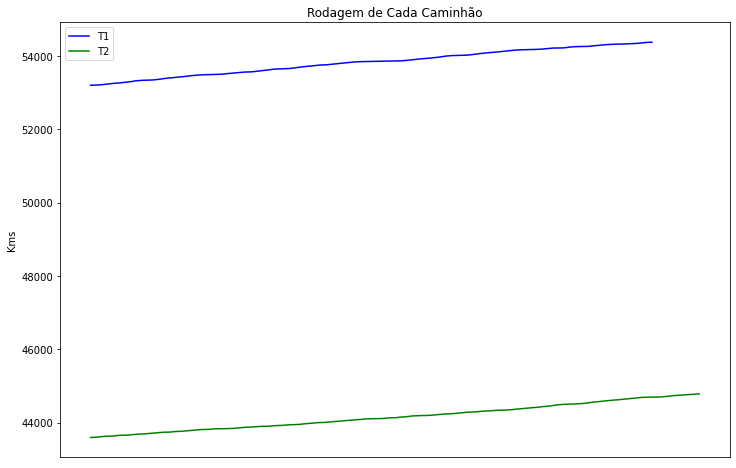

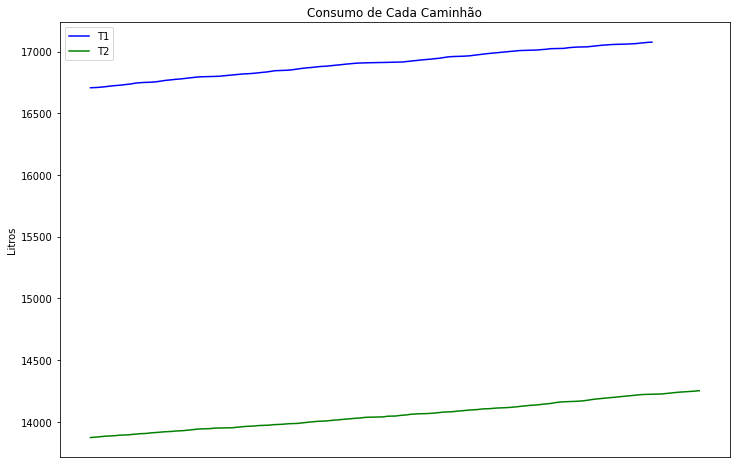

In [27]:
#Observando visualmente os dados / Visually observing the data

#Há algum veículo que roda mais do que o outro? / Is there any vehicle that is more driven?
P1 = df_t_1['odometer_km']
P2 = df_t_2['odometer_km']

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 8))
ax.plot(P1, color='b', label='T1')
ax.plot(P2, color='g', label='T2')
ax.set_ylabel("Kms")
ax.set_title("Rodagem de Cada Caminhão")
ax.legend(loc='upper left')
ax.axes.get_xaxis().set_visible(False)

#Há algum veículo que consome mais do que o outro? / Is there any vehicle with a higher consumption?
C1 = df_t_1['acc_fuel_use_lt']
C2 = df_t_2['acc_fuel_use_lt']

fig2, ax2 = plt.subplots(1, 1, sharex=True, figsize=(12, 8))
ax2.plot(C1, color='b', label='T1')
ax2.plot(C2, color='g', label='T2')
ax2.set_ylabel("Litros")
ax2.set_title("Consumo de Cada Caminhão")
ax2.legend(loc='upper left')
ax2.axes.get_xaxis().set_visible(False)


Não foi possível encontrar disparidades / Unable to find disparities.

Text(0.5, 1.0, 'Relação de Consumo do Caminhão 2')

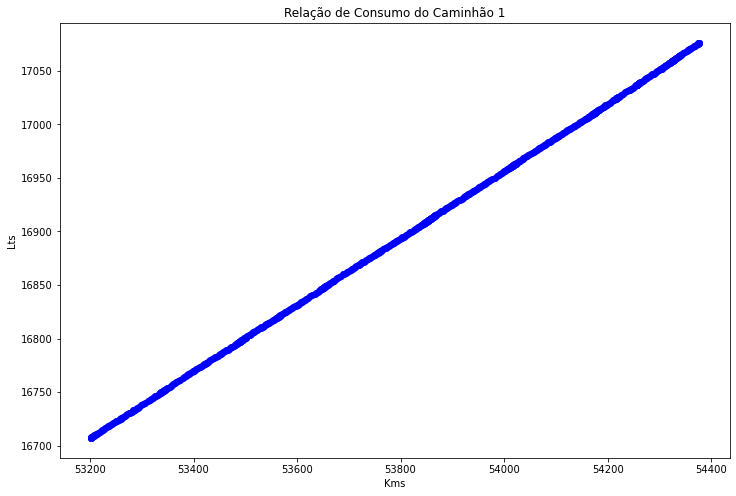

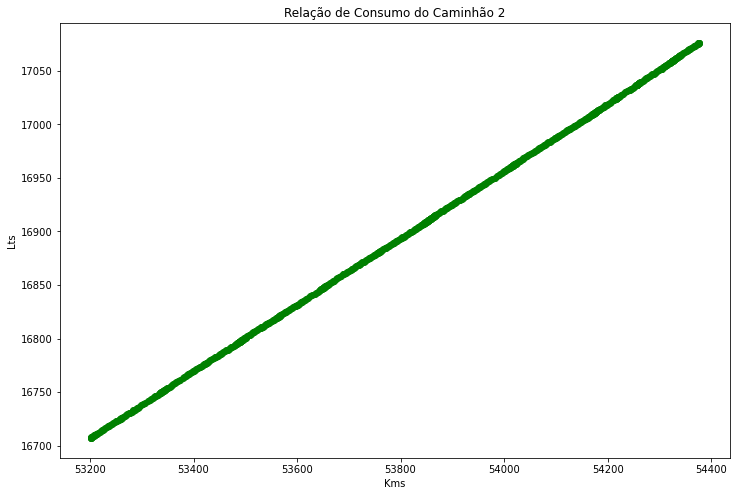

In [28]:
#Qual a relação entre consumo e rodagem? / What's the relation between consumption and shooting?
x = df_t_1['odometer_km']
y = df_t_1['acc_fuel_use_lt']

fig3, ax3 = plt.subplots(1, 1, sharex=True, figsize=(12, 8))
ax3.scatter(x, y, color='b')
ax3.set_xlabel("Kms")
ax3.set_ylabel("Lts")
ax3.set_title("Relação de Consumo do Caminhão 1")

x2 = df_t_2['odometer_km']
y2 = df_t_2['acc_fuel_use_lt']

fig4, ax4 = plt.subplots(1, 1, sharex=True, figsize=(12, 8))
ax4.scatter(x, y, color='g')
ax4.set_xlabel("Kms")
ax4.set_ylabel("Lts")
ax4.set_title("Relação de Consumo do Caminhão 2")

In [29]:
#Adicionando coluna de estado / Adding status column
df_t_1.insert(4,"status", "Okänt", True)
df_t_2.insert(4,"status", "Okänt", True)

In [30]:
#Função para identificar paradas do veículo, baseado em SPG / Function to identify stops, based on GPS
def is_it_stopped(df,idx):
    for i in idx:
            if(i==0):
                df.at[i,'status']='riding'
                print("index "+str(i)+" defined.")
            elif(i!=0):
                lat1=df.at[i-1,'latitude']
                lon1=df.at[i-1,'longitude']
                lat2=df.at[i,'latitude']
                lon2=df.at[i,'longitude']
                
                if((lat1==lat2)&(lon1==lon2)):
                    df.at[i,'status']='stopped'
                else:
                    df.at[i,'status']='riding'
            else:
                print("received unknown number, please verify")

In [31]:
is_it_stopped(df_t_1,n_idx_1)
is_it_stopped(df_t_2,n_idx_2)

index 0 defined.
index 0 defined.



Aqui, a intenção era descobrir possíveis pontos de parada, baseado nos dados do GPS. 
Porém, não foi possível pois as paradas identificadas são muito curtas.
Nesse caso, usando conhecimento de negócio, é possível identificar paradas para almoço e paradas noturnas, baseando-se na variação do tempo (Δt), conforme ficará evidenciado abaixo.

Here, the intention was to find possible stop spots, based on GPS data. However, this was unsuccesfull due to the identified stops being too short. In this situation, using business knowledge, it's possible to discover lunch and night stops, by the analysis of time variation, as is shown below.

In [32]:
#Prep.
df_t_1.insert(5,"delta_t", 0, True)
df_t_2.insert(5,"delta_t", 0, True)

In [33]:
#Função para identificar paradas do veículo, baseado em tempo / Function to identify stops, based on timestamp

def identify_stops(df, idx):
    for i in idx:
        if(i==0):
                print("value "+str(df.at[i,'delta_t'])+" is already defined.")
        elif(i!=0):
            df.loc[i,'delta_t']=df.at[i,'timestamp_t']-df.at[i-1,'timestamp_t']
        else:
             print("received unknown index, please verify")

In [34]:
identify_stops(df_t_1,n_idx_1)
identify_stops(df_t_2,n_idx_2)

value 0 is already defined.


/home/lambert/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


value 0 is already defined.


In [35]:
#Nova função de estado baseada na variação do tempo / New status function based on time variation
def is_it_stopped(df,idx):
    for i in idx:
            if(i==0):
                df.at[i,'status']='riding'
                print("index "+str(i)+" defined.")
            elif(i!=0):
                dt=df.at[i,'delta_t']
               
                if((dt.seconds>1800)&(dt.seconds<9000)):
                    df.at[i,'status']='short stop' #inferior a 2.5h, não permite carga completa
                elif(dt.seconds>=9000):
                    df.at[i,'status']='long stop' #superior a 2.5h, permite carga completa
                else:
                    df.at[i,'status']='riding'
                #Observação: Essa função considera um conjunto de dados já tratado e portanto dispensa tratamentos adicionais
            else:
                print("received unknown number, please verify")

In [36]:
#Alterando registros na coluna de estado / Changing values at the status column
is_it_stopped(df_t_1,n_idx_1)
is_it_stopped(df_t_2,n_idx_2)

index 0 defined.
index 0 defined.


In [37]:
#Recuperando locais de parada / Getting stop sites

t1_s_stops=df_t_1[df_t_1.status=='short stop']
t2_s_stops=df_t_2[df_t_2.status=='short stop']

t1_l_stops=df_t_1[df_t_1.status=='long stop']
t2_l_stops=df_t_2[df_t_2.status=='long stop']

short_stops=t1_s_stops.append(t2_s_stops, ignore_index=True)
long_stops=t1_l_stops.append(t2_l_stops, ignore_index=True)

In [38]:
#ANÁLISES / ANALYSIS SECTION

#mostando no mapa / showing in the map

m = folium.Map(location=[57.735714, 13.040152], tiles='cartodbpositron', zoom_start=8.5, min_zoom=8.5, control_scale=True)

#inserindo coordenadas de percurso / inserting travel coord.

for pt1 in df_t_1.itertuples():
    folium.CircleMarker([pt1.latitude,pt1.longitude], radius=2, color='blue', tooltip=str(pt1.latitude)+" - "+str(pt1.longitude)).add_to(m)
for pt2 in df_t_2.itertuples():
    folium.CircleMarker([pt2.latitude,pt2.longitude], radius=2, color='green', tooltip=str(pt2.latitude)+" - "+str(pt2.longitude)).add_to(m)

#inserindo coordenadas de parada / inserting travel coord.

for pts in short_stops.itertuples():
    folium.CircleMarker([pts.latitude,pts.longitude], radius=2, color='yellow', tooltip="short stop").add_to(m)
for ptl in long_stops.itertuples():
    folium.CircleMarker([ptl.latitude,ptl.longitude], radius=2, color='red', tooltip="long stop").add_to(m)

#impressão do map / show map
m

Com esses dados é possível identificar algumas rotas típicas, elencadas a seguir:

1. Gotemburgo - Stenungsund
2. Gotemburgo - Vårgårda
3. Gotemburgo - Kungsbacka
4. Gotemburgo - Jönköping

Mas, qual a distância entre esses locais? É possível visualizar as coordenadas no mapa.

In [39]:
Gtbrg = (57.707152, 11.989326)
Stgsn = (58.063299, 11.815659)
Vrgrd = (58.031599, 12.809911)
Kgbck = (57.480121, 12.063585)
Jnkpn = (57.763042, 14.153404)

GtS=haversine(Gtbrg,Stgsn)
GtV=haversine(Gtbrg,Vrgrd)
GtK=haversine(Gtbrg,Kgbck)
GtJ=haversine(Gtbrg,Jnkpn)

print("From Göteborg to (in KM): "+
        "\nStenungsund: ≈"+str(round(GtS,2))+
        "\nVårgårda: ≈"+str(round(GtV,2))+
        "\nKungsbacka: ≈"+str(round(GtK,2))+
        "\nJönköping: ≈"+str(round(GtJ,2)))

From Göteborg to (in KM): 
Stenungsund: ≈40.91
Vårgårda: ≈60.47
Kungsbacka: ≈25.63
Jönköping: ≈128.6


In [40]:
#Para uma visuzalização mais agradável, são impressas somente as paradas / printing the stops only

#mostando no mapa / showing in the map

m2 = folium.Map(location=[57.735714, 13.040152], tiles='cartodbpositron', zoom_start=8.5, min_zoom=8.5, control_scale=True)

#inserindo coordenadas de parada / inserting travel coord.

for pts in short_stops.itertuples():
    folium.CircleMarker([pts.latitude,pts.longitude], radius=3, color='yellow', tooltip="short stop").add_to(m2)
for ptl in long_stops.itertuples():
    folium.CircleMarker([ptl.latitude,ptl.longitude], radius=3, color='red', tooltip="long stop").add_to(m2)

#impressão do map / show map
m2

<h3> 1. Which would be the best spots to have battery chargers? </h3>

To answer this question, it's necessary to consider the available electric vehicles:

- Type: FH-FM-FMX Electric 	Charge time in hours (DC): 2.5 	Autonomy in KM: up to 300.0    
    Use: Heavy duty
    
    
- Type: FE Electric 	Charge time in hours (DC): 2.5 	Autonomy in KM: up to 200.0    
    Use: Regional Transport
    
    
- Type:	FL Electric 	Tempo de Carga em Horas (DC): 2.5 	Autonomy in KM: up to 300.0    
    Use: City transport
    

Considering these vehicles and the routes previously presented, it would be possible to perform the Göteborg-Stenungsund, Göteborg-Vårgårda and Göteborg-Kungsbacka routes with any of the vehicles and with only one full charge, to be realized in Göteborg. However, our data shows only short stops at this city, it would be necessary to have additional recharge stations at the destiny.
Regarding the Göteborg-Jönköping route, to be realized with a single charge, it should be performed with the FL or FH-FM-FMX types of trucks, which have a higher autonomy, again, considering the charge in Göteborg. Nonetheless, there's a long stop in Jönköping, allowing the use of any of the vehicles.

Considering the above, departing from Göteborg, it would demanda recharge stations at the arrival-cities, to short recharges, besides a short charge at the origin and a full charge at Jönköping.

That meaning, **from a infrastructure perspective**, the replacement is **viable**.

<h3> 2. What is the current fuel consumption? What autonomy is needed? </h3>

In [41]:
#Consumo T1
df_t_1.describe()

,latitude,longitude,heading,odometer_km,acc_fuel_use_lt
count,689.000000,689.000000,689.000000,689.000000,689.000000
mean,57.727530,12.755203,176.716981,53827.346154,16902.772801
std,0.070590,0.723635,98.854749,342.369125,107.084411
min,57.480121,11.957279,0.000000,53201.100000,16707.120000
25%,57.683789,12.052646,83.000000,53530.000000,16810.120000
50%,57.725319,12.572658,184.000000,53852.900000,16910.190000
75%,57.769359,13.274510,264.000000,54151.100000,17003.280000
max,57.870831,14.159804,359.000000,54376.700000,17076.320000


In [42]:
#Consumo T1
delta_distance=54376.7-53201.1
delta_fuel=17076.3-16707.12
consumption=delta_fuel/delta_distance

print("Totais T1: "+
        "\nDistância percorrida (em KM): "+str(round(delta_distance,2))+
        "\nCombustível utilizado (em L): "+str(round(delta_fuel,2))+
        "\nConsumo (em KM/L): "+str(round(consumption,2)))

Totais T1: 
Distância percorrida (em KM): 1175.6
Combustível utilizado (em L): 369.18
Consumo (em KM/L): 0.31


In [43]:
#Consumo T2
df_t_2.describe()

,latitude,longitude,heading,odometer_km,acc_fuel_use_lt
count,747.000000,747.000000,747.000000,747.000000,747.000000
mean,57.811271,12.395045,167.038822,44163.493676,14054.955462
std,0.104067,0.566276,103.717353,343.003180,109.274843
min,57.661118,11.815564,0.000000,43594.500000,13872.480000
25%,57.728630,11.994128,70.000000,43867.150000,13960.325000
50%,57.771463,12.215649,167.000000,44134.100000,14046.660000
75%,57.871045,12.574032,255.000000,44448.000000,14145.805000
max,58.063299,14.160911,359.000000,44785.500000,14251.430000


In [44]:
#Consumo T2
delta_distance=44785.5-43594.5
delta_fuel=14251.43-13872.48
consumption=delta_fuel/delta_distance

print("Totais T2: "+
        "\nDistância percorrida (em KM): "+str(round(delta_distance,2))+
        "\nCombustível utilizado (em L): "+str(round(delta_fuel,2))+
        "\nConsumo (em KM/L): "+str(round(consumption,2)))

Totais T2: 
Distância percorrida (em KM): 1191.0
Combustível utilizado (em L): 378.95
Consumo (em KM/L): 0.32


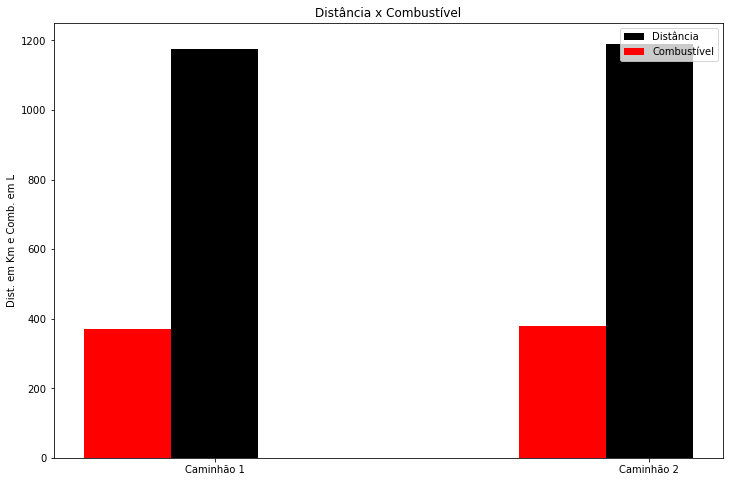

In [45]:
dtp = [1175, 1191]
cbu = [369, 378]
espessura = 0.2
rotulos = ['Caminhão 1', 'Caminhão 2']
x = np.arange(len(rotulos))

def p1(x):
    return x + (espessura/2)
def p2(x):
    return x - (espessura/2)

x_dtp = list(map(p1,x))
x_cbu = list(map(p2,x))
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 8))
ax.bar(x_dtp, dtp, espessura, color='black', label='Distância', tick_label=rotulos)
ax.bar(x_cbu, cbu, espessura, color='red', label='Combustível')
ax.set_ylabel("Dist. em Km e Comb. em L")
ax.set_title('Distância x Combustível')
ax.legend(loc='upper right')

The current consumption is about 0.30 Km/l. It would require more than 3 liters of diesel to each kilometer. The absurd proximity between both trucks indicates they are probably the same make and model.

The minimal autonomy, as analyzed above, would be in the figure of 130 kilometers. It's possible to conclude that all truck models presented are able to comply with this requisite.



<h3> 3. What is the environmental impact? </h3>

According to IPEA (Applied Economics Research Institure), "Os veículos movidos a diesel emitem mais CO2 por unidade de volume ou peso
de combustível em relação aos demais modais motorizados. Utilizou-se neste trabalho
um fator de emissão médio de 2,6 kg de CO 2 para cada litro de diesel queimado na
combustão (...)" 
(Carvalho, Carlos Henrique Ribeiro, Emissões Relativas de Poluentes do Transporte Motorizado de Passageiros nos Grandes Centros Urbanos Brasileiros, Brasília, 2011). 

Meaning: The average level of CO² emissions is of 2,6 Kg per liter of diesel.

In [46]:
#Encontrando o consumo diário
consumo_médio_t1_t2 = (369+378)/2
consumo_diário = consumo_médio_t1_t2/5
print(consumo_diário)

#se usarmos a mesma emissão média do estudo do IPEA, podemos calcular o impacto ambiental diário e anual
impacto_ambiental_d = consumo_diário*2.6

impacto_anual=impacto_ambiental_d*252 #252 dias úteis no ano
print("Impacto ambiental anual:"+
        "\nNo ano, seriam emitidos menos "+str(round(impacto_anual,2))+" kg de CO² na atmosfera.")

74.7
Impacto ambiental anual:
No ano, seriam emitidos menos 48943.44 kg de CO² na atmosfera.


That is, to each year of the electric transition, 49 TON of C0² would not be thrown into the atmosfere. Considering this value ins multiplied by each vehicle, considering only the vehicles available in this dataframe, **approximately 100 TON of CO² would not be thrown into the atmosfere, each year**, not taking into account other poluents.

<h3> 4. Considering only fuel, would this transition be of financial advantage? <h3>

According to data available in Statista, the per-liter cost of diesel in Sweden is currently of € 1.48 to the year of 2021.
That, in the conversion of August 20, is equivalent to kr 14.73 (Svenska Krona). We already obtained an average daily consumption of 74.7 liters of diesel.

https://www.statista.com/statistics/603731/diesel-fuel-prices-sweden/

In [47]:
consumo_anual = 74.7*252
print(consumo_anual)
custo_anual_euro=consumo_anual*1.48
custo_anual_sek=consumo_anual*14.73
print("Custo anual em euro: "+str(custo_anual_euro))
print("Custo anual em coroas suecas: "+str(custo_anual_sek))

18824.4
Custo anual em euro: 27860.112
Custo anual em coroas suecas: 277283.412


Still acording to data available at Statista, the average cost of the KWh in Sweden was € 0.17 in the second semester of 2020.
That's equivalent to kr 1.75. Below it's possible to obtain the average daily riden distance of 236.6 km.

https://www.statista.com/statistics/418124/electricity-prices-for-households-in-sweden/

In [48]:
#Encontrando a distância média diária / Finding the average daily distance
dist_média_t1_t2 = (1175+1191)/2
dist_diária = dist_média_t1_t2/5
print("Distância Diária (KM):")
print(dist_diária)

#Encontrando a eficiência / Finding the efficiency
capacidade_kwh=540
autonomia_km = 300
eficiência=capacidade_kwh/autonomia_km
print("Eficiência: (Kwh/Km)")
print(round(eficiência,2))

#Encontrando o consumo / Finding the consumption
consumo_diário=dist_diária*eficiência
consumo_anual = consumo_diário*252
print("Consumo anual (Kwh):")
print(consumo_anual)
custo_anual_euro=consumo_anual*0.17
custo_anual_sek=consumo_anual*1.75
print("Custo anual em euro: "+str(custo_anual_euro))
print("Custo anual em coroas suecas: "+str(custo_anual_sek))


Distância Diária (KM):
236.6
Eficiência: (Kwh/Km)
1.8
Consumo anual (Kwh):
107321.76
Custo anual em euro: 18244.6992
Custo anual em coroas suecas: 187813.08


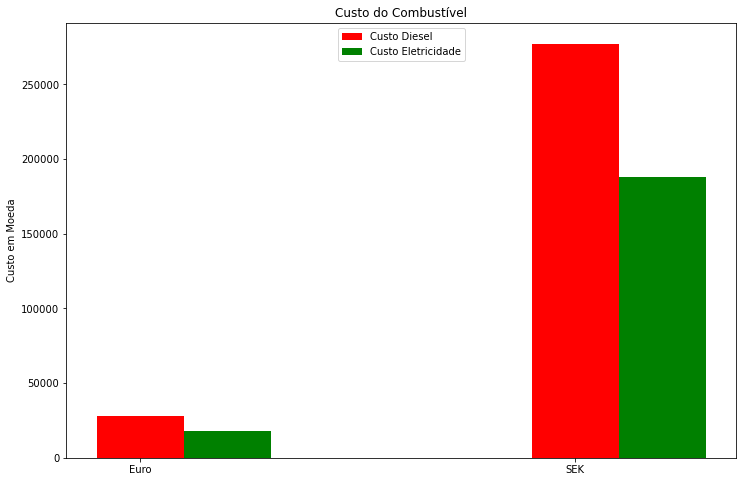

In [49]:
cad = [27860.11, 277283.41]
cae = [18244.69, 187813.08]
espessura = 0.2
rotulos = ['Euro', 'SEK']
x = np.arange(len(rotulos))

def p1(x):
    return x + (espessura)
def p2(x):
    return x + (espessura*2)

x_cad = list(map(p1,x))
x_cae = list(map(p2,x))
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 8))
ax.bar(x_cad, cad, espessura, color='red', label='Custo Diesel', tick_label=rotulos)
ax.bar(x_cae, cae, espessura, color='green', label='Custo Eletricidade')
ax.set_ylabel("Custo em Moeda")
ax.set_title('Custo do Combustível')
ax.legend(loc='upper center')

<h1> Conclusion and Next Steps </h1>
 
Considering the above, it's possible to understand that not only the transition is possible, but it also brings a financial advantage, beyond the obvious environmental gain. 

However, some aspects could be better analyzed:

 1. The operations base appears to be situated at Göteborg, however, there are no long-stop data at this spot, which may imply this dataset is not complete enough to this kind of analysis.
 2. To this study, only the Direct Current charger was considered. We know, however, that there is an Alternating Current. The use of an AC charger implies a higher charging time. Including this data, it would be possible to investigate which type of charger is better to each location, if the cost of aquisition and maintainance is also available. If the cost is alike, the faster charge would always be the best option.
 3. It would be interesting to have further data about the kind of transport operation is provided by this company, as the choice of the vehicles is due, also, to the type of the payload and the payload capacity. Therefore, it would be possible to optimize the vehicle choice, by finding the most attractive financially that is able to comply with the service demands.